# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



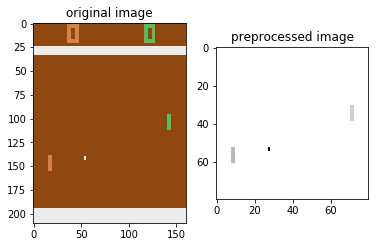

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
#         self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4)
#         self.size=1*20*20
        in_channels = 2
        conv_channels = [4, 16]
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=conv_channels[0], kernel_size=5, stride=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=5, stride=3),
            nn.ReLU())
        self.conv_out_size = 16 * 8 * 8
        
        # 1 fully connected layer
#         self.fc = nn.Linear(self.size, 1)
#         self.sig = nn.Sigmoid()
        self.fc_layers = nn.Sequential(
            nn.Linear(self.conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1))
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = self.conv_layers(x)
        # flatten the tensor
#         print(x.size())
        x = x.view(-1, self.conv_out_size)
#         print(x.size())
        x = self.fc_layers(x)
        return self.sig(x)


# run your own policy!
policy=Policy().to(device)
# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [5]:
import numpy as np

raw_frame1, _, _, _ = env.step(0)
raw_frame2, _, _, _ = env.step(1)
raw_frame3, _, _, _ = env.step(0)
raw_frame4, _, _, _ = env.step(1)
print(f"raw frame shape: {raw_frame1.shape}")
frames = pong_utils.preprocess_batch([raw_frame1, raw_frame2])
print(f"frames size: {frames.size()}")
policy = Policy()
policy.forward(frames)

raw frame shape: (210, 160, 3)
frames size: torch.Size([1, 2, 80, 80])


tensor([[ 0.5077]])

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


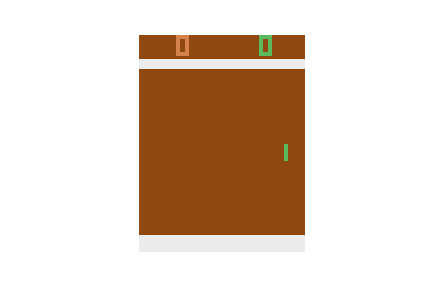
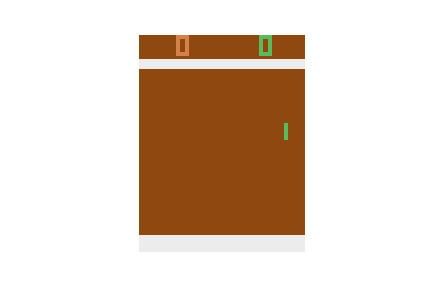
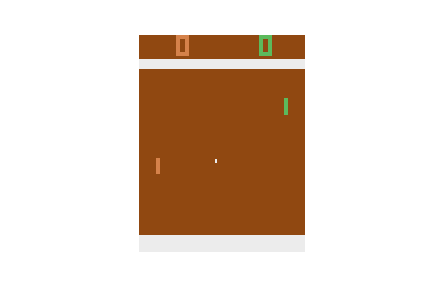
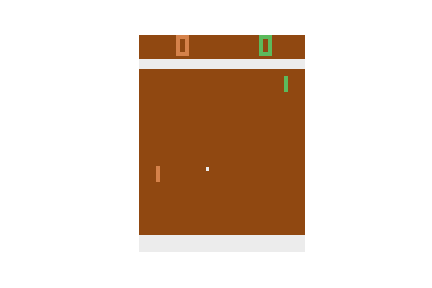
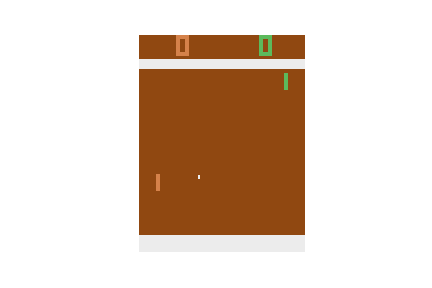
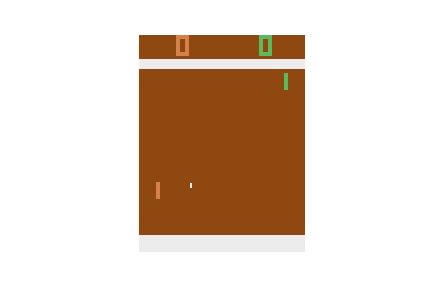
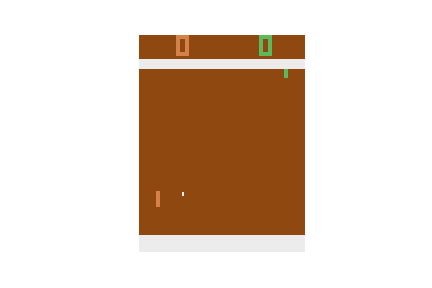
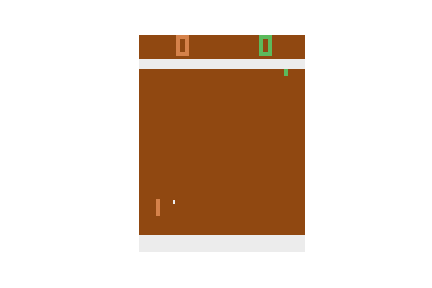
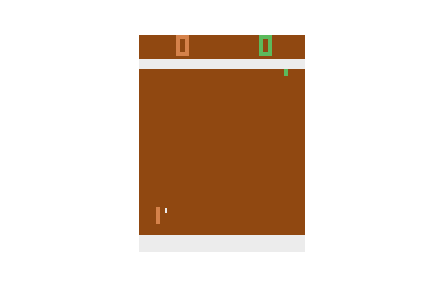
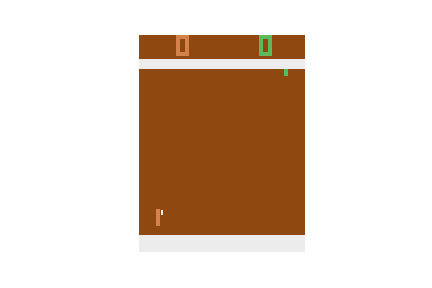
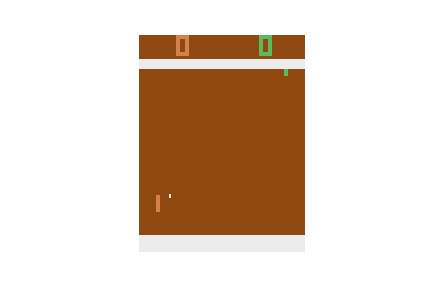
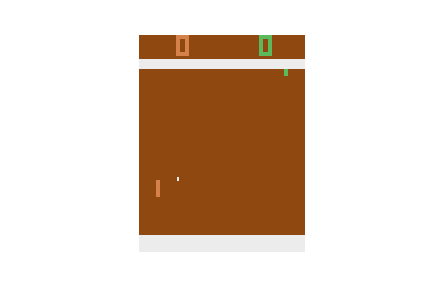
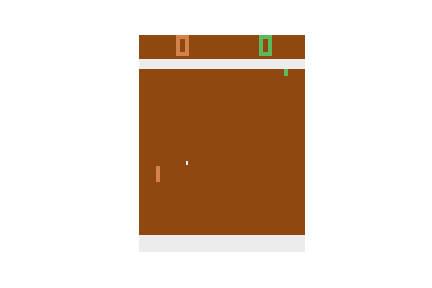
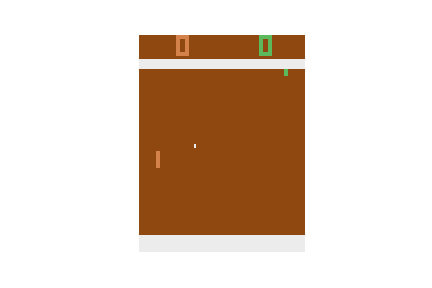
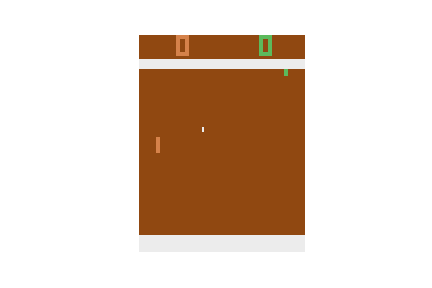
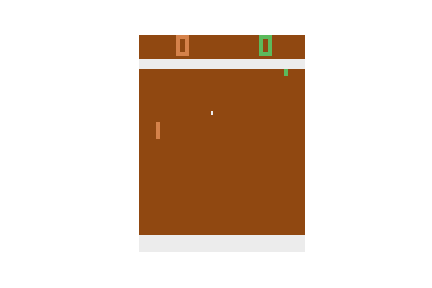
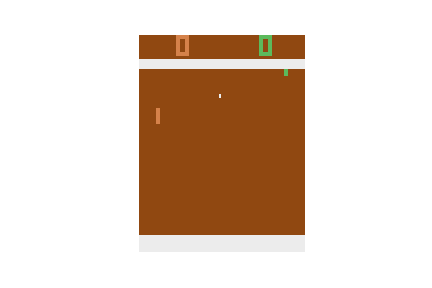
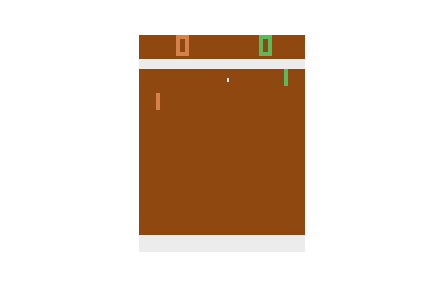
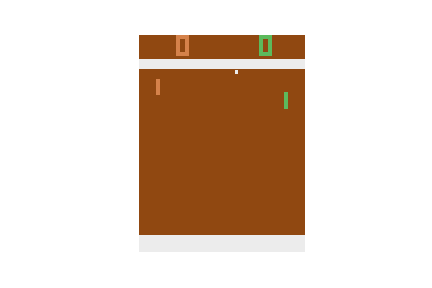
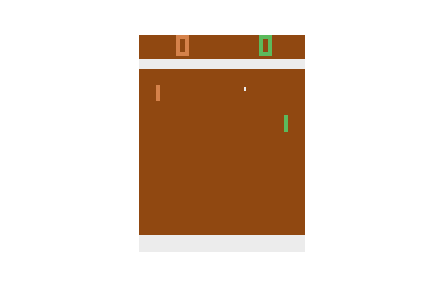
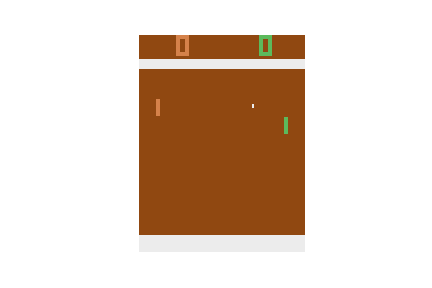
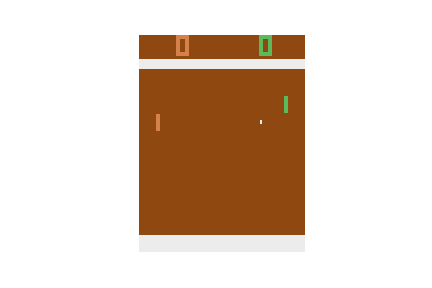
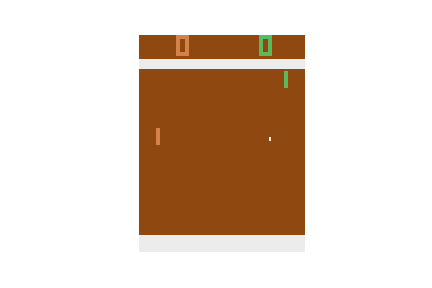
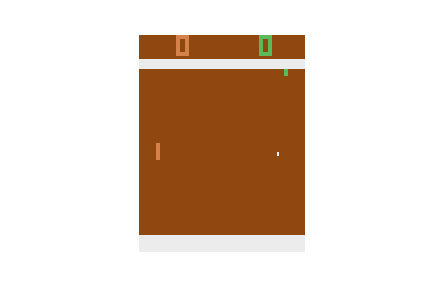
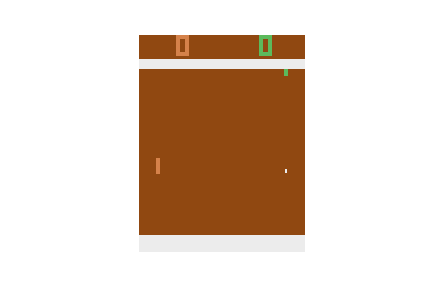
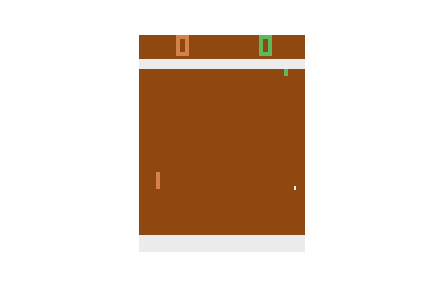
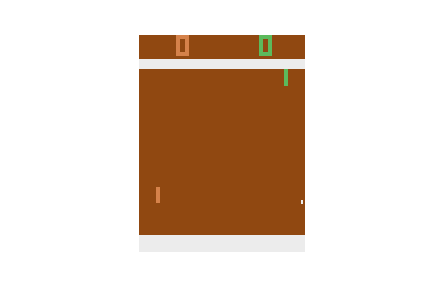
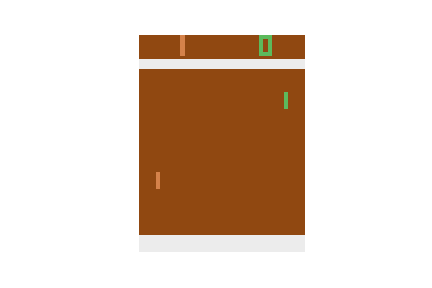
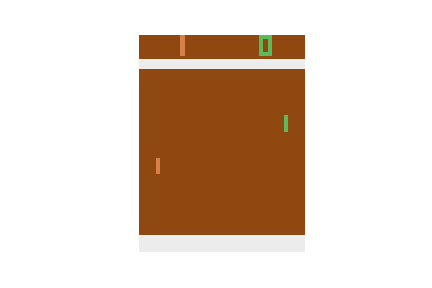
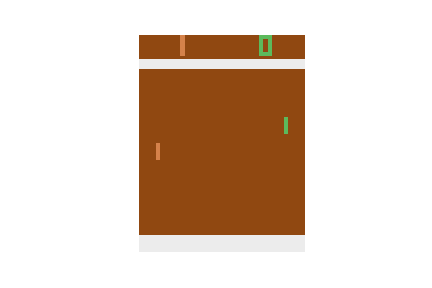
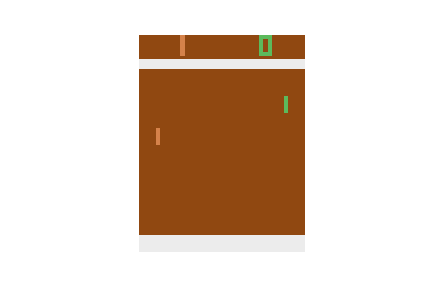
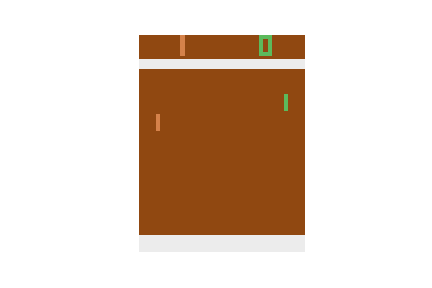
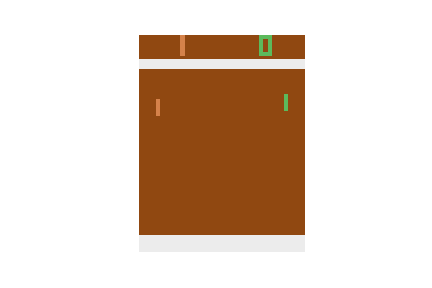
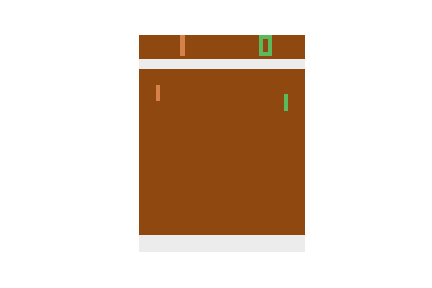
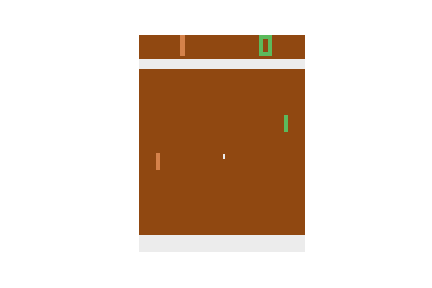
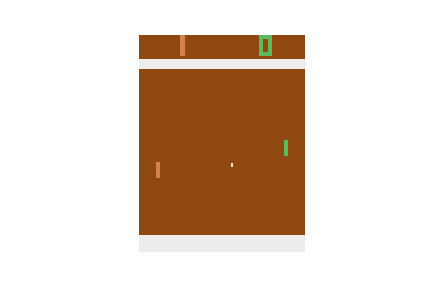
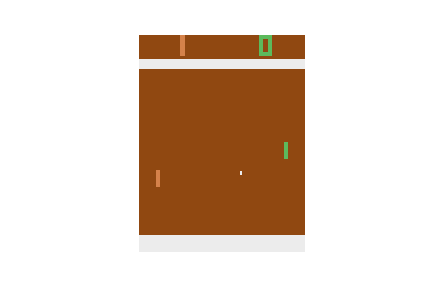
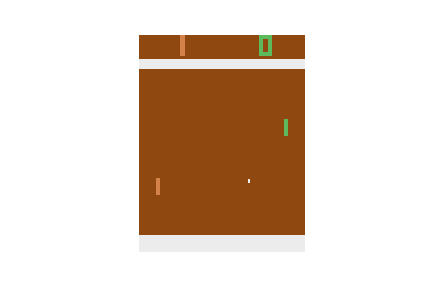
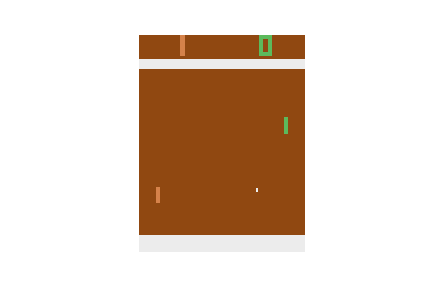
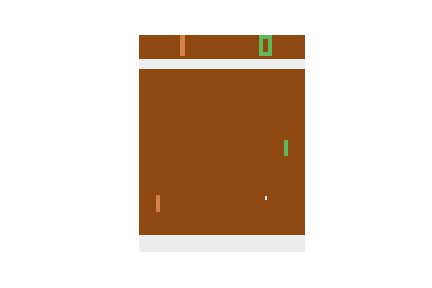
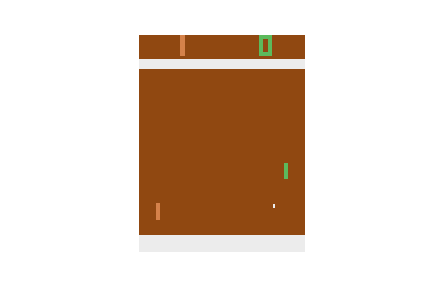
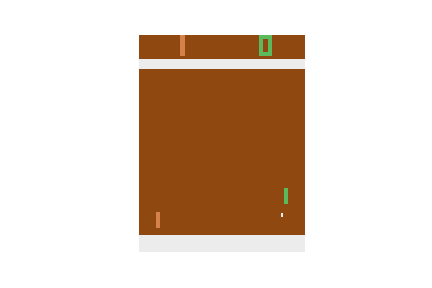
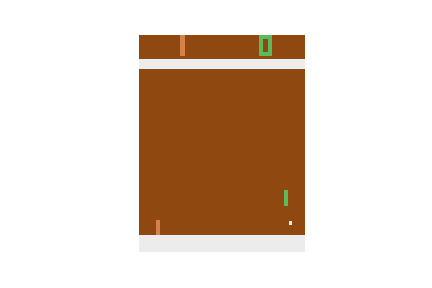
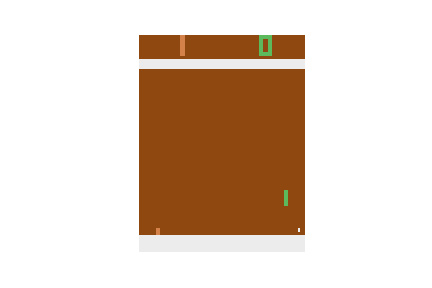
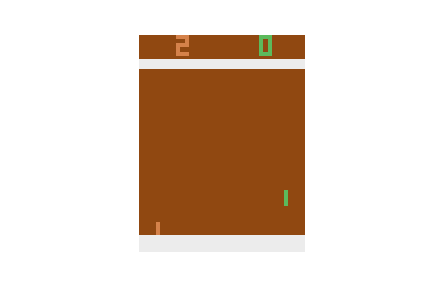
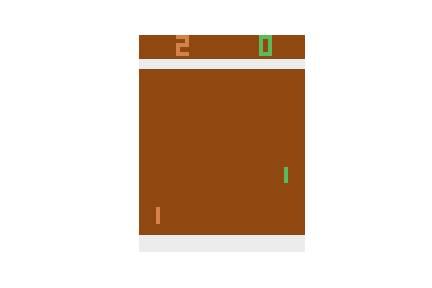
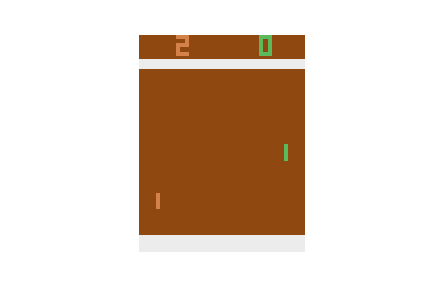
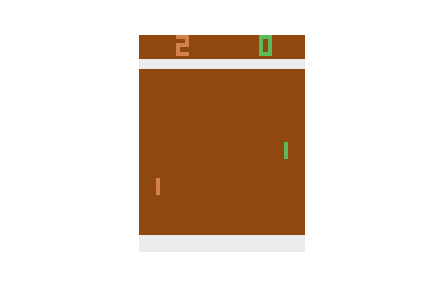
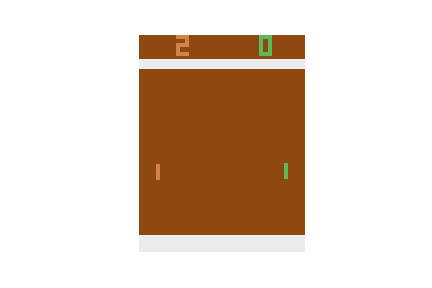
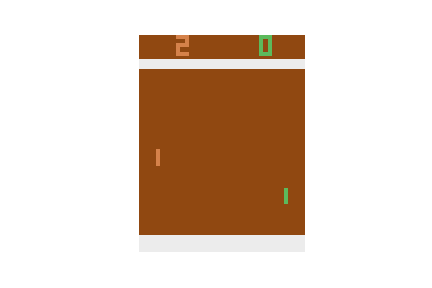
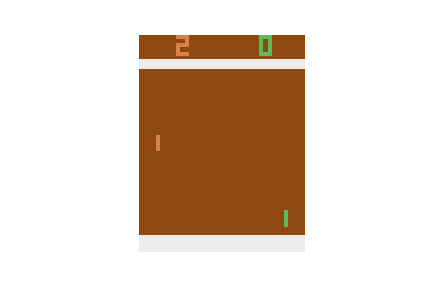
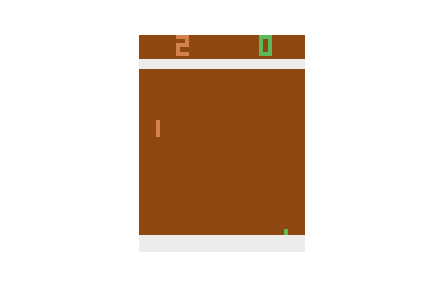
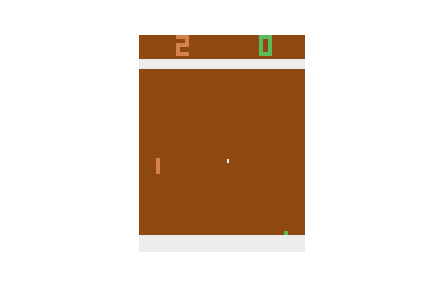
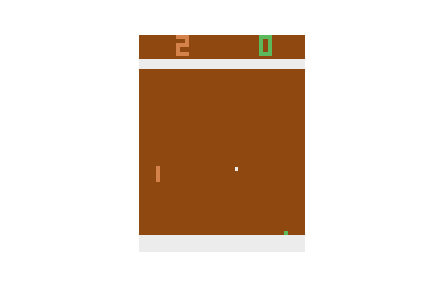
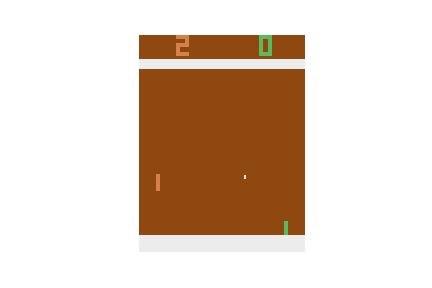
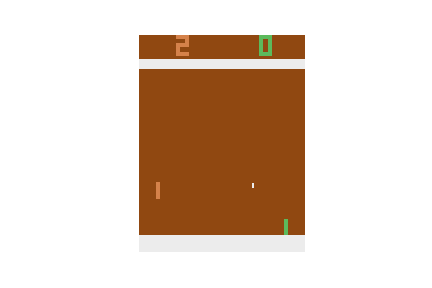
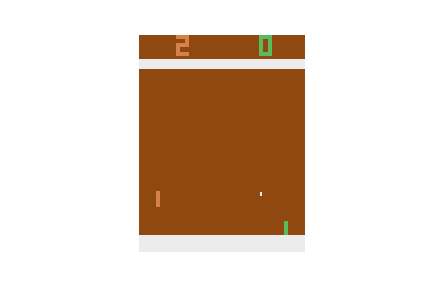
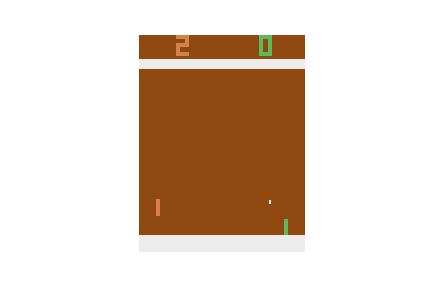
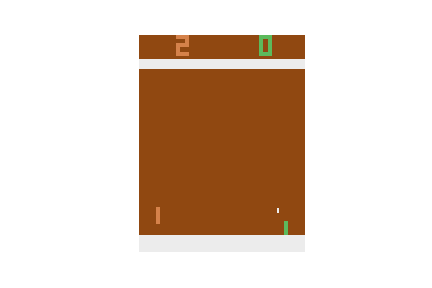
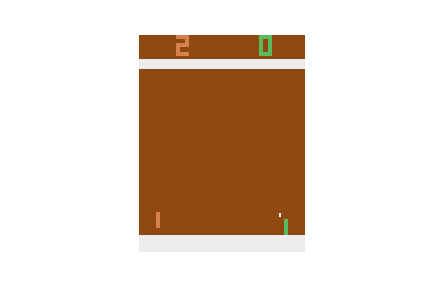
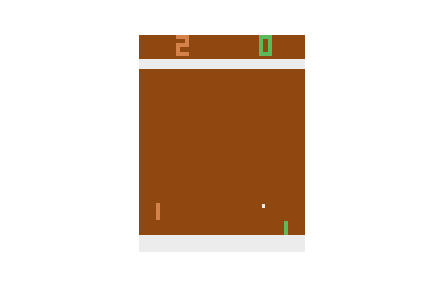
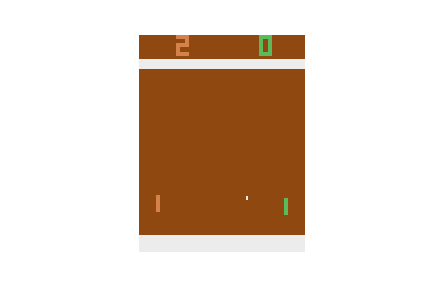
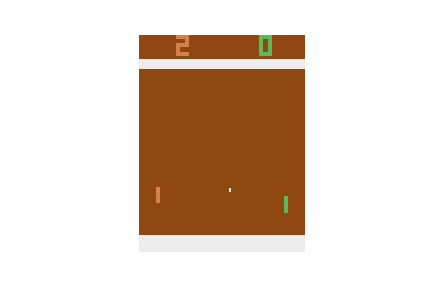
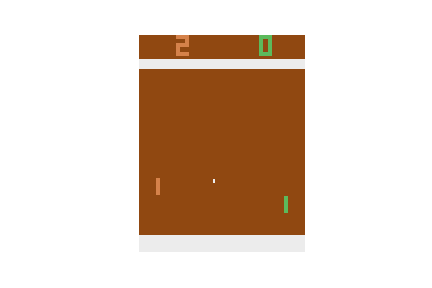
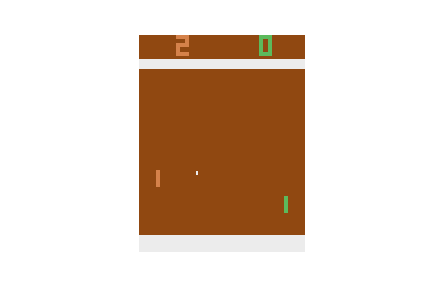
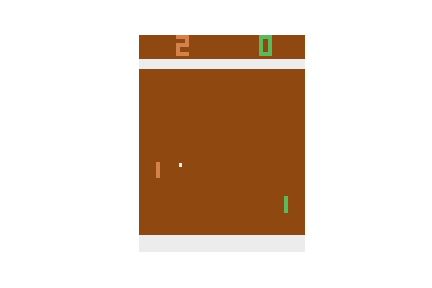
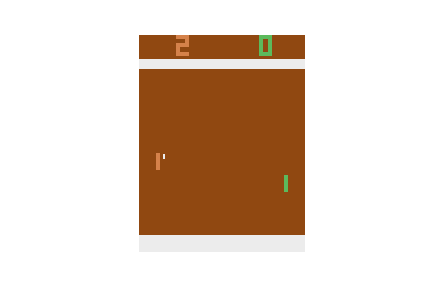
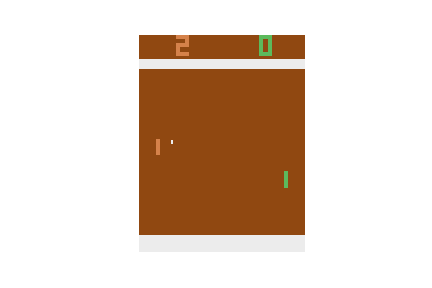
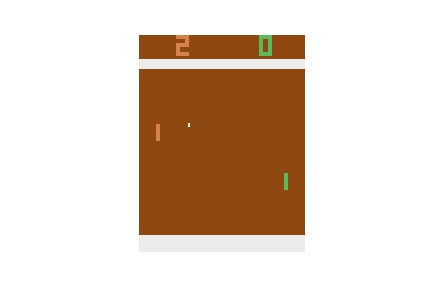
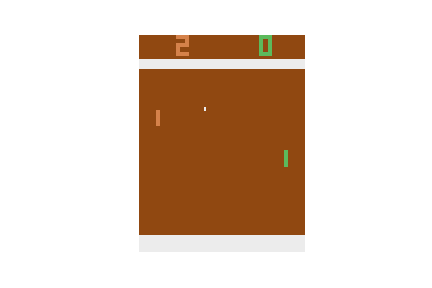
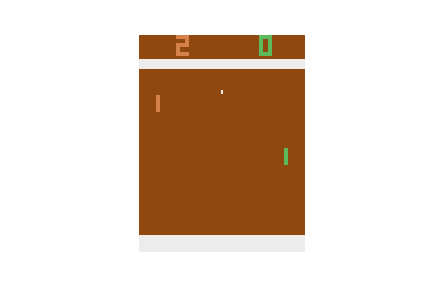
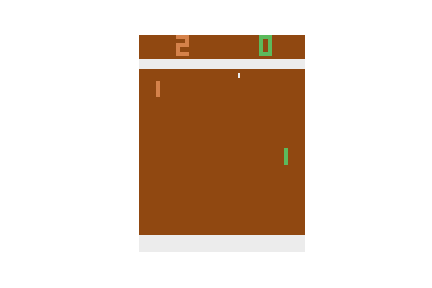
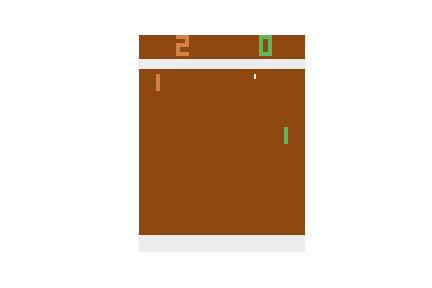
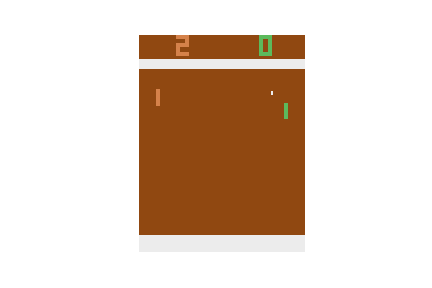
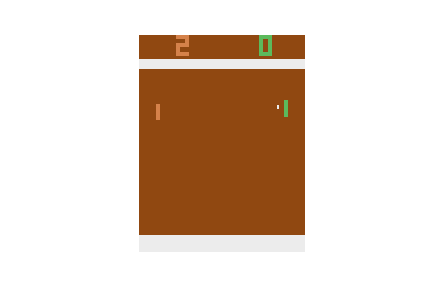
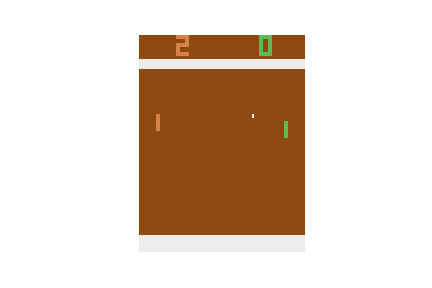
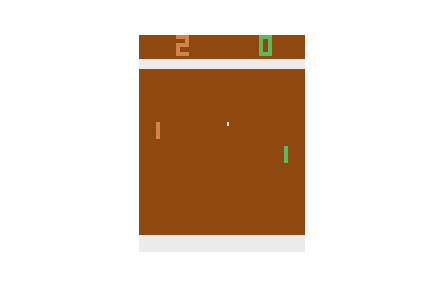
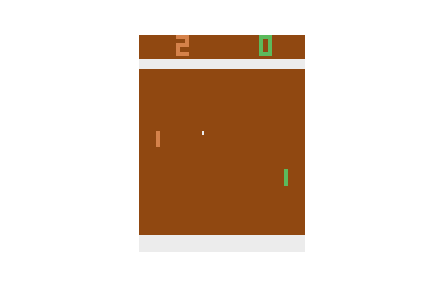
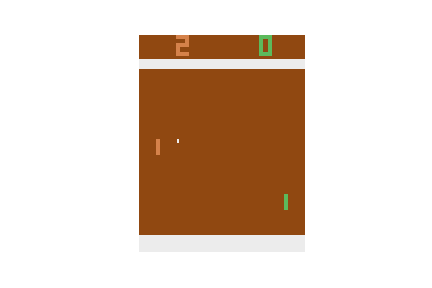
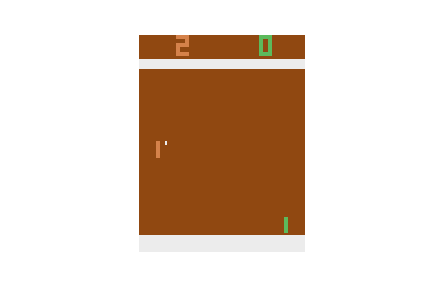
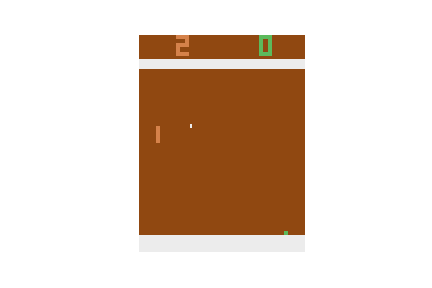
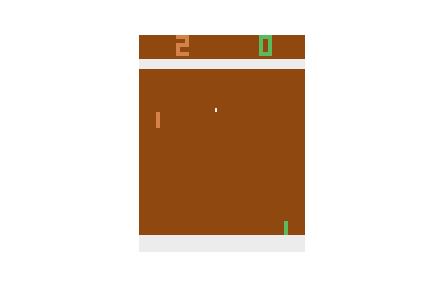
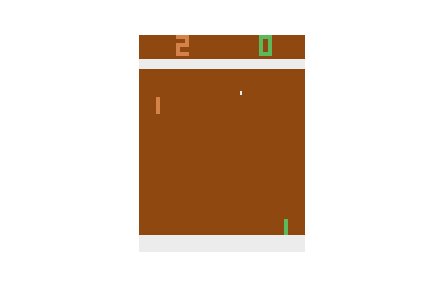
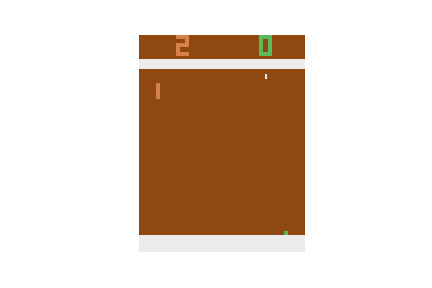
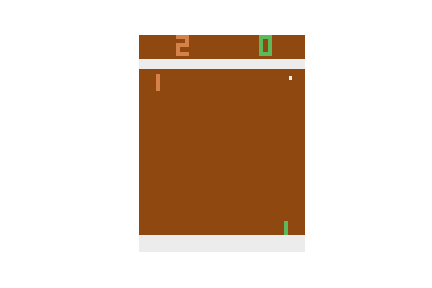
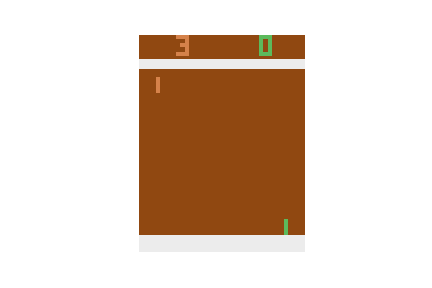
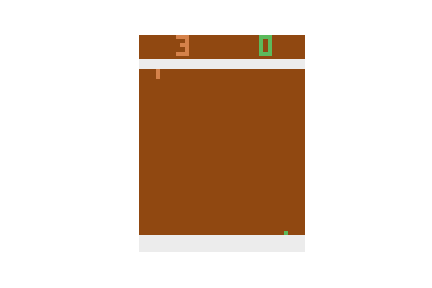
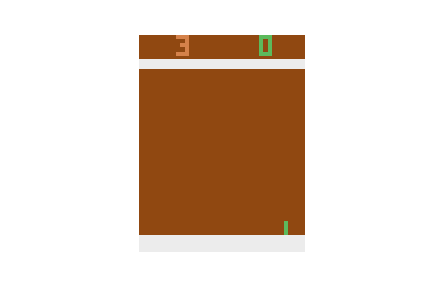
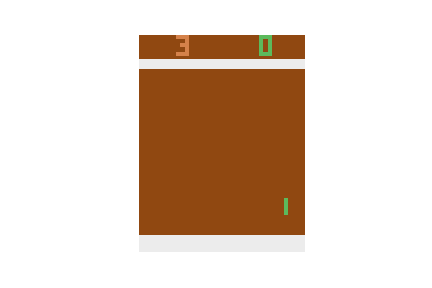
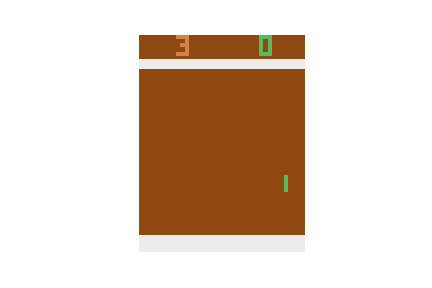
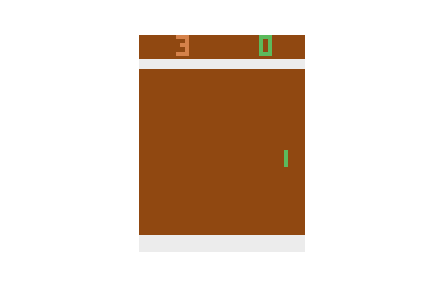
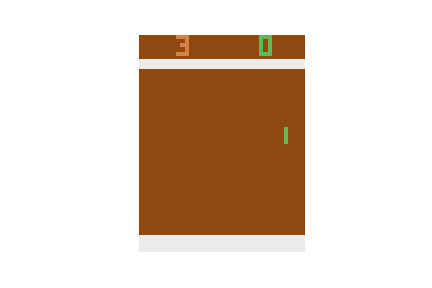
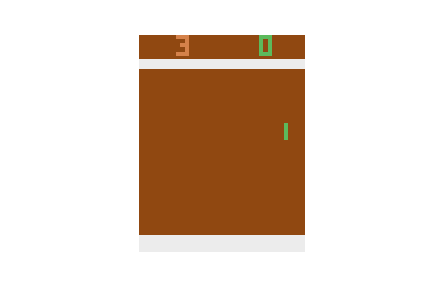
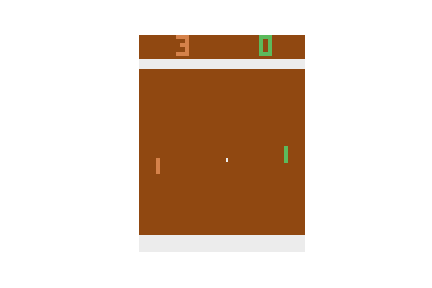
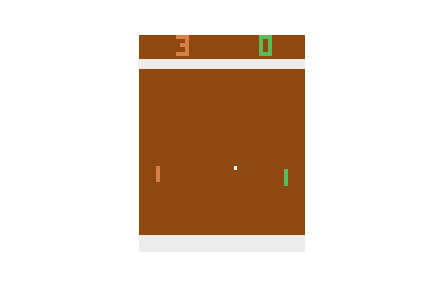
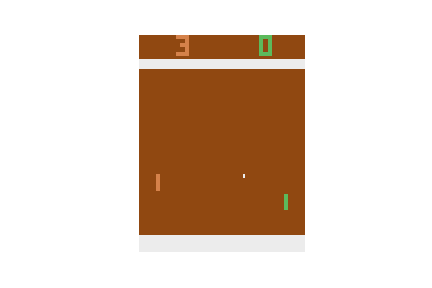
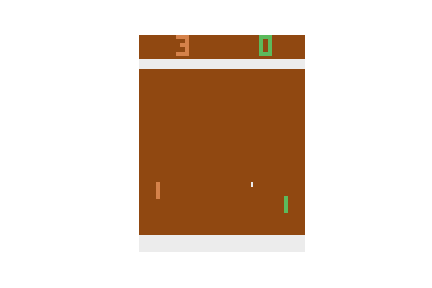
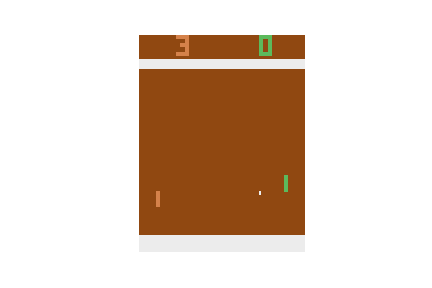
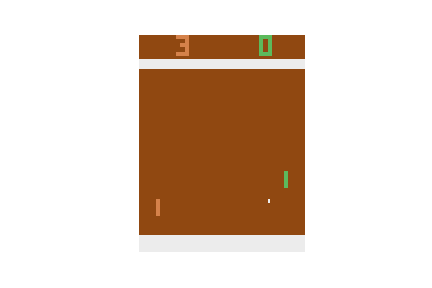
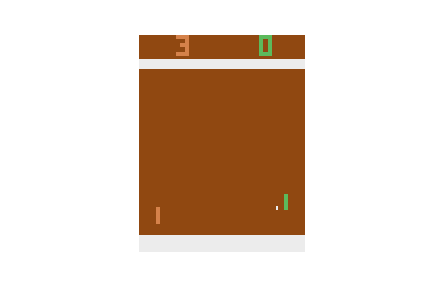
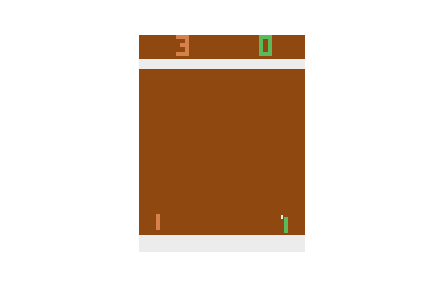
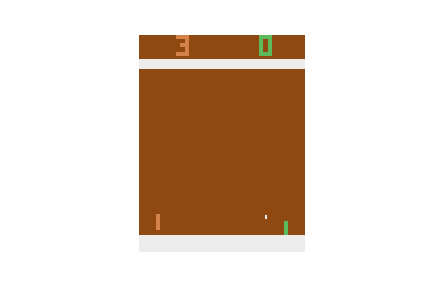
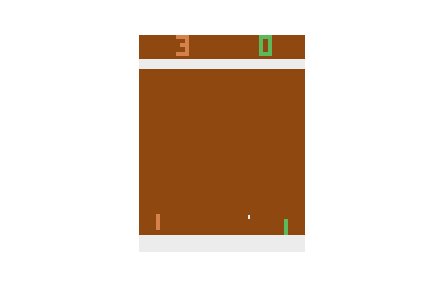
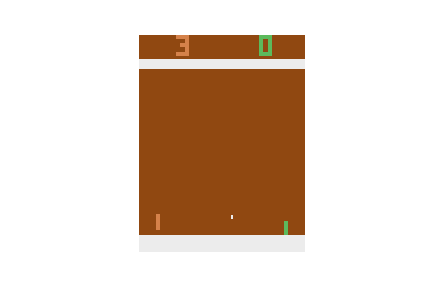
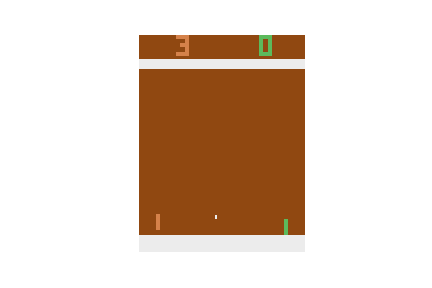
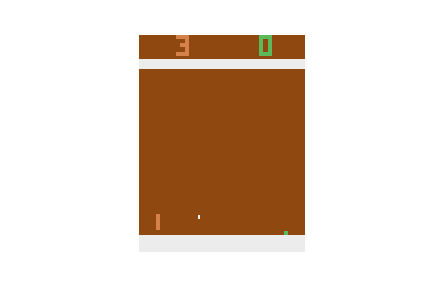
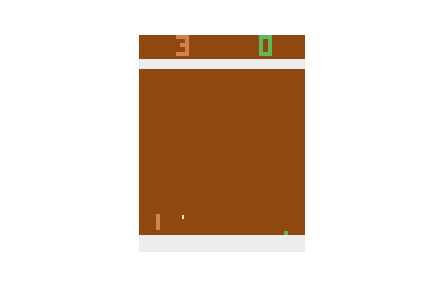
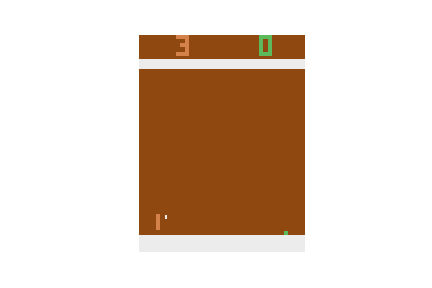
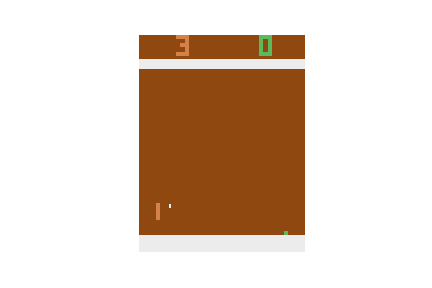
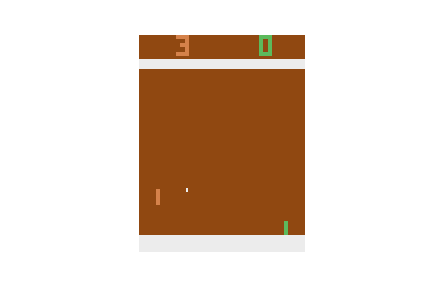
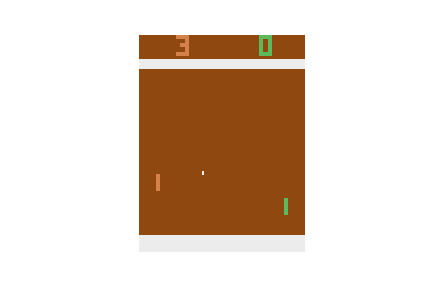
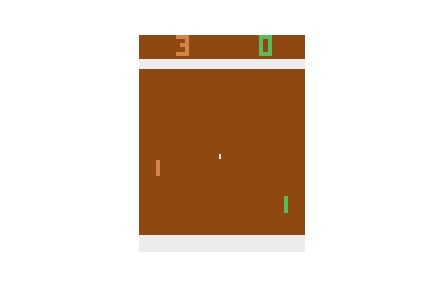
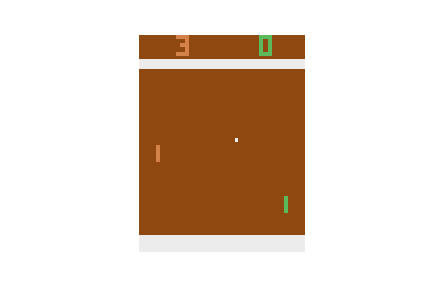
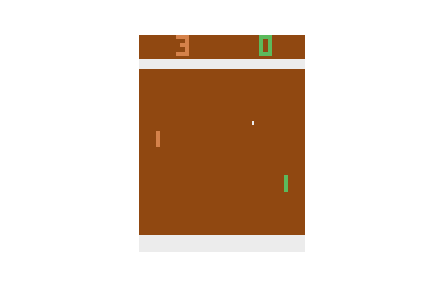
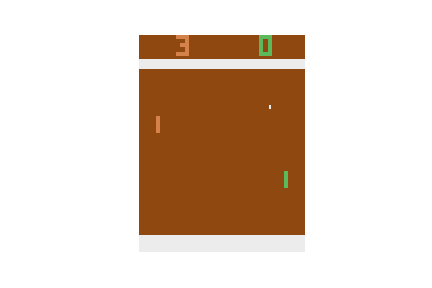
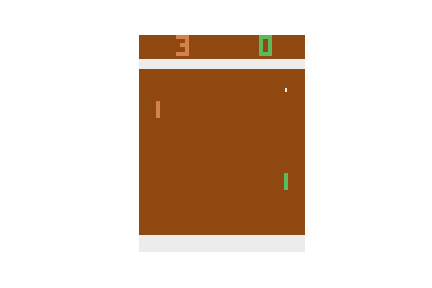
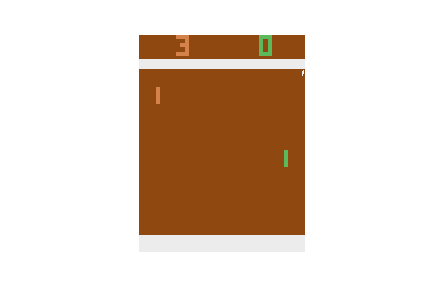
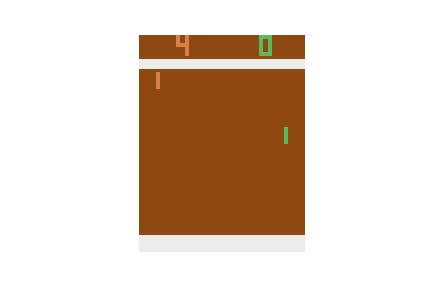
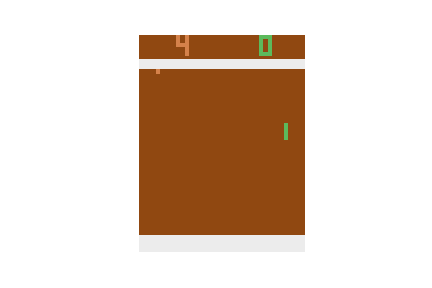
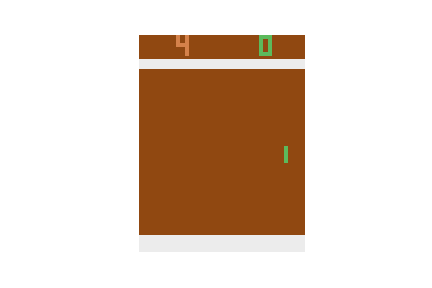
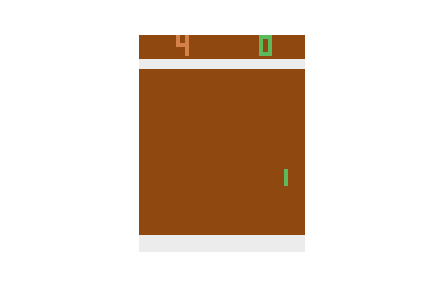
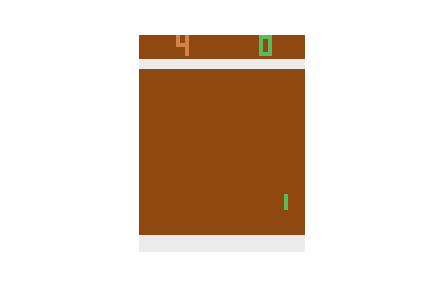
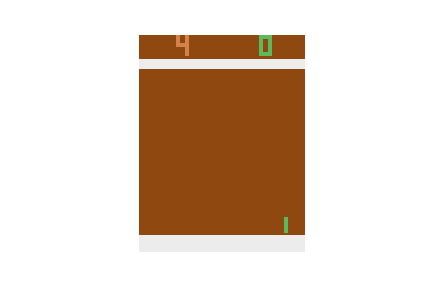
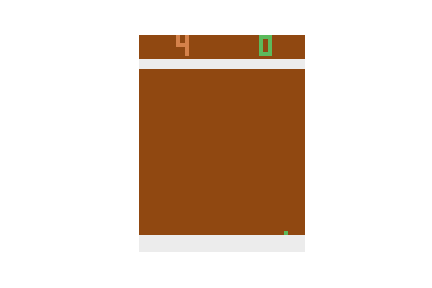
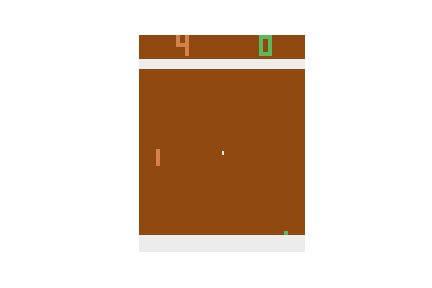
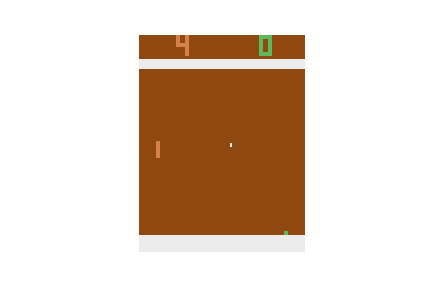
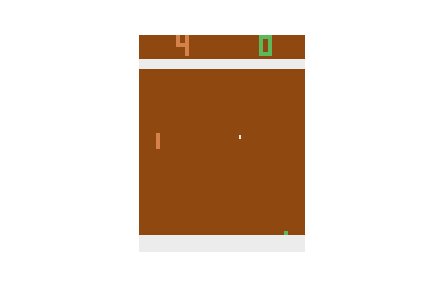
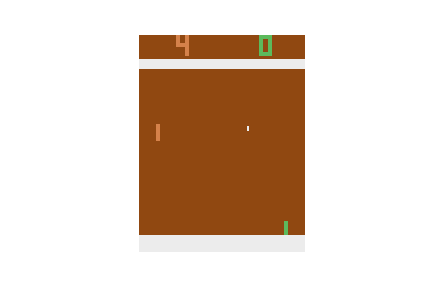
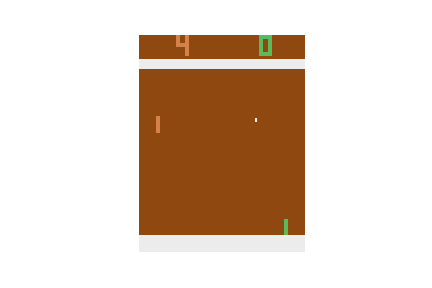
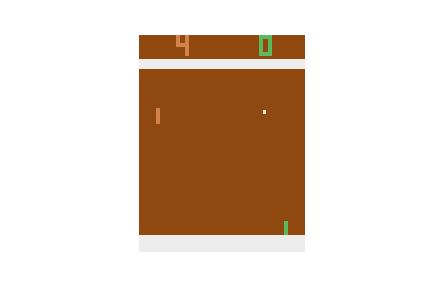
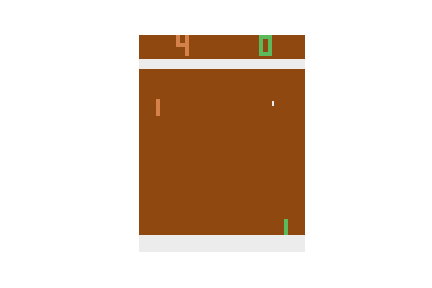
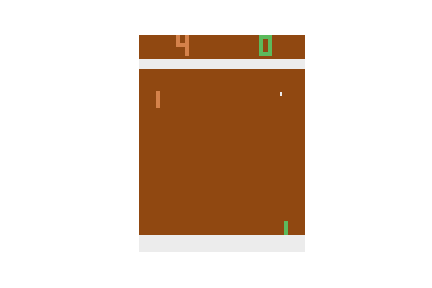
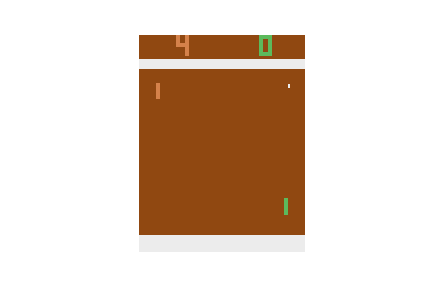
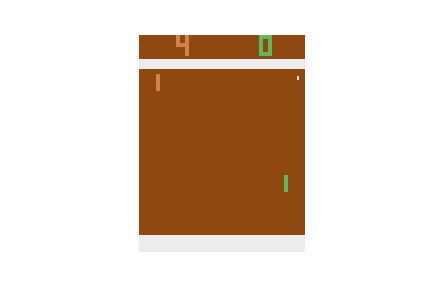
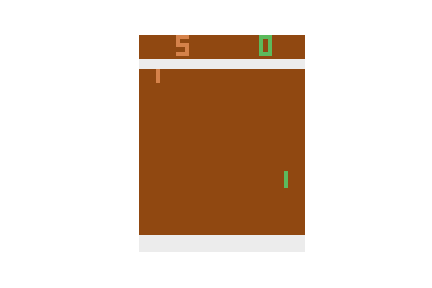
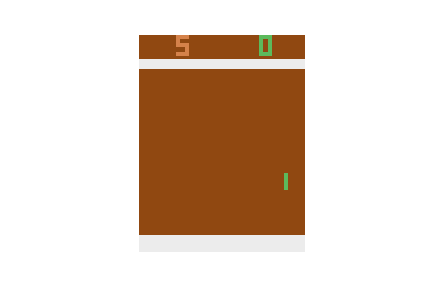
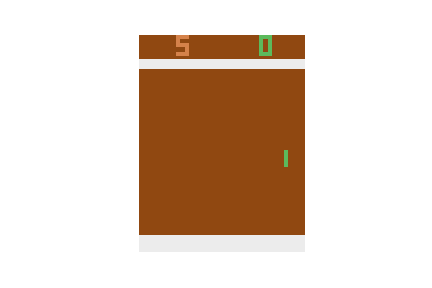
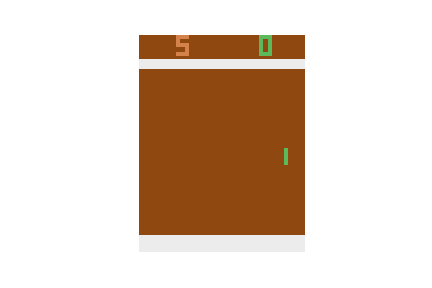
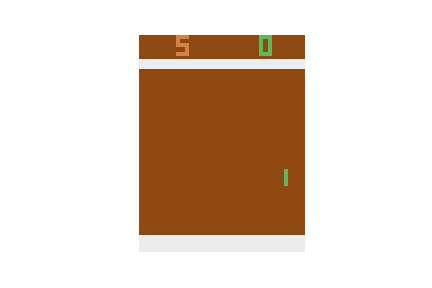
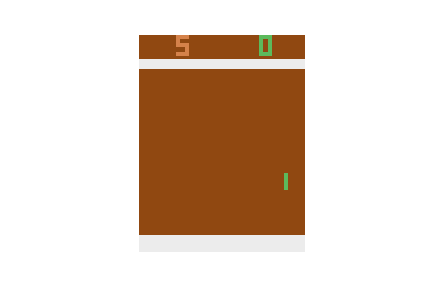
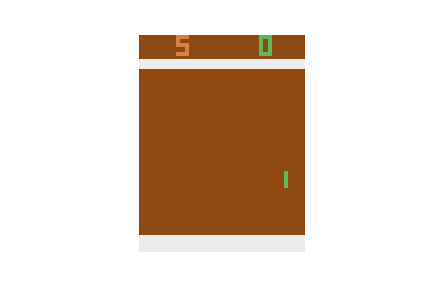
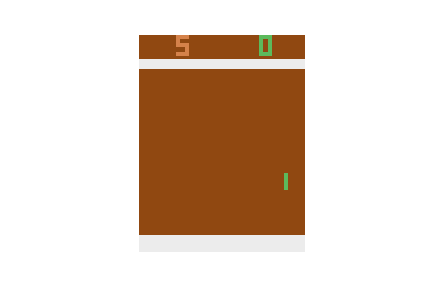
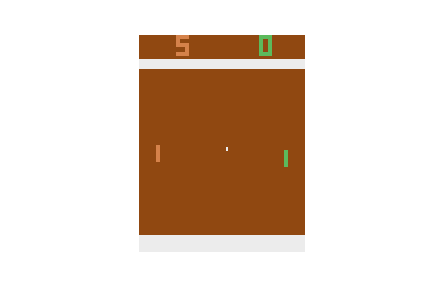
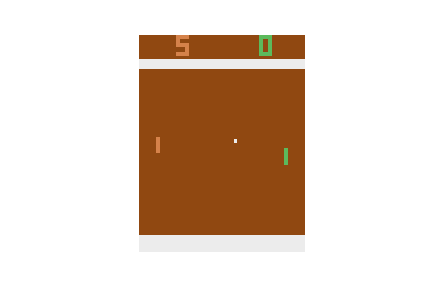
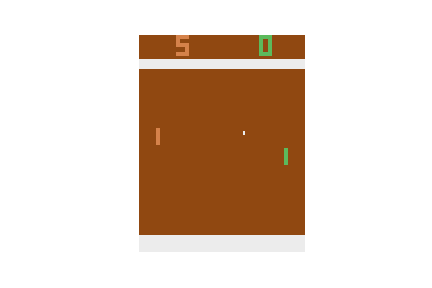
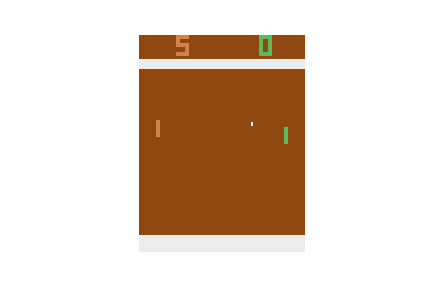
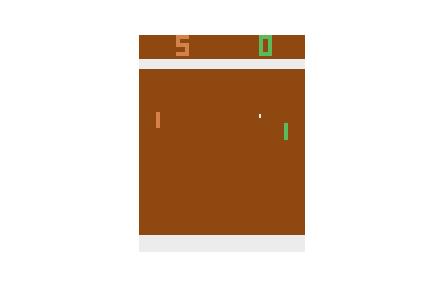
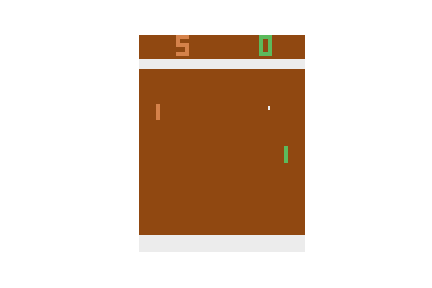
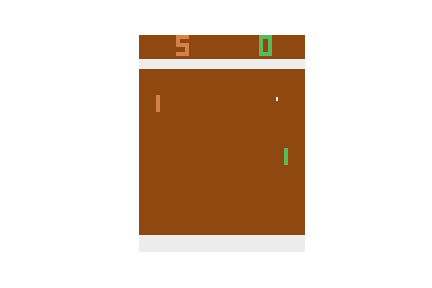
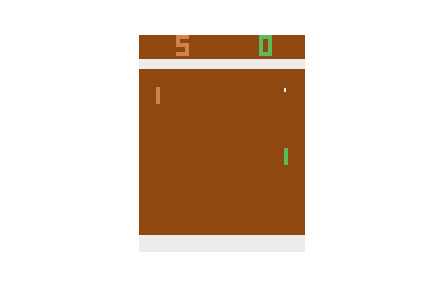
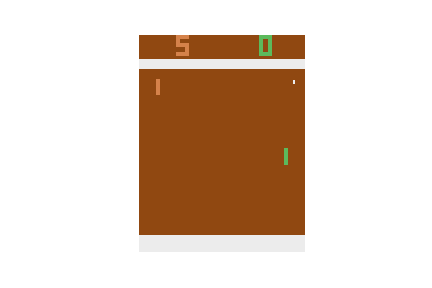
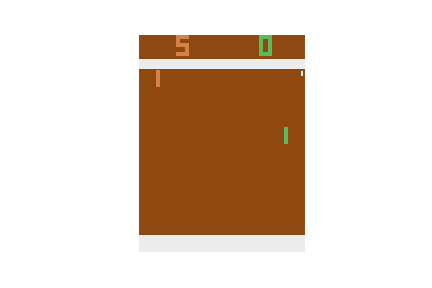
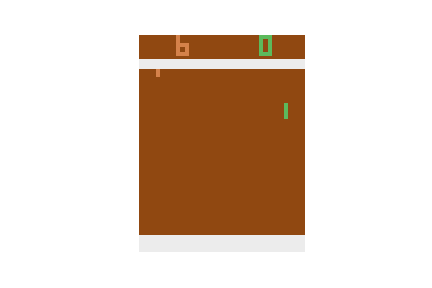
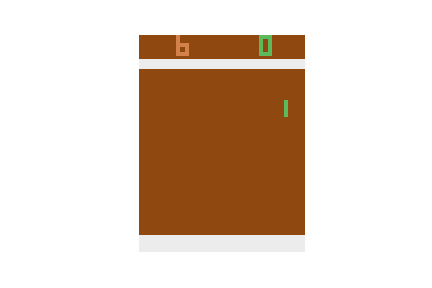
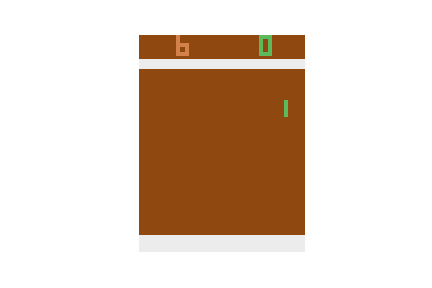
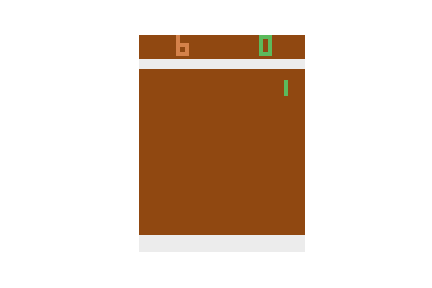
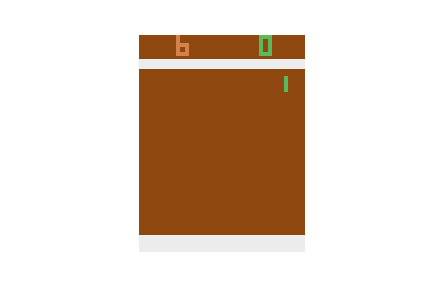
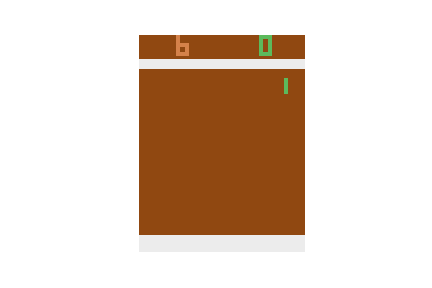
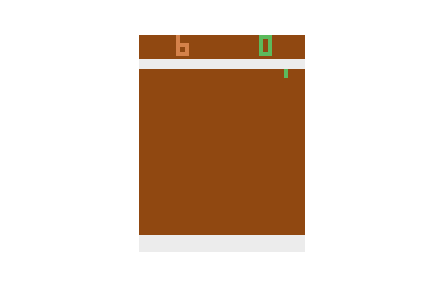
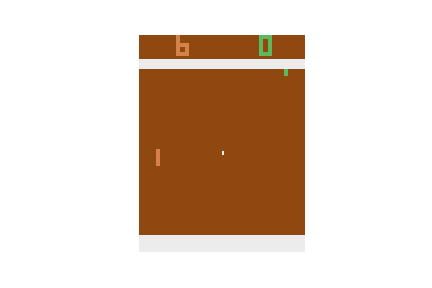
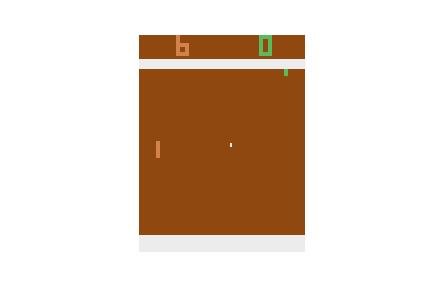
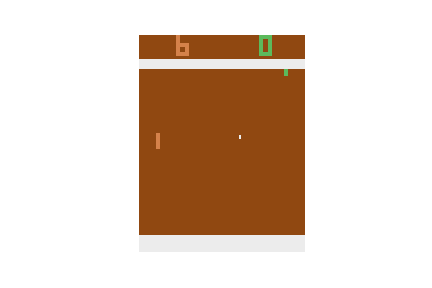
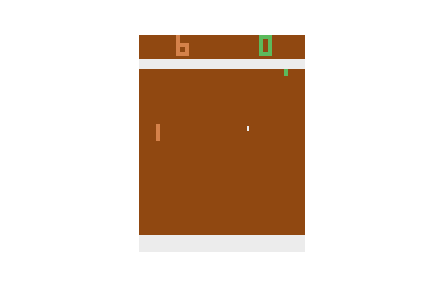
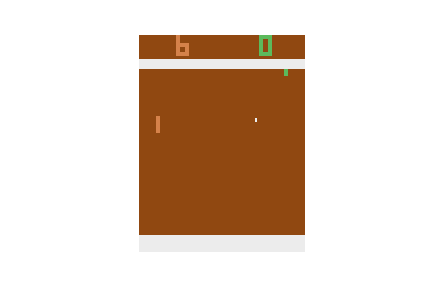
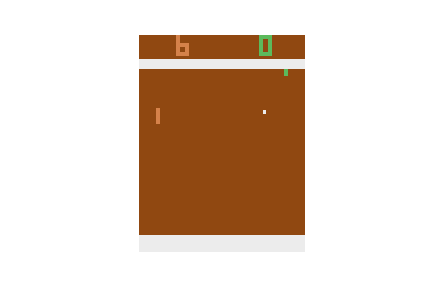
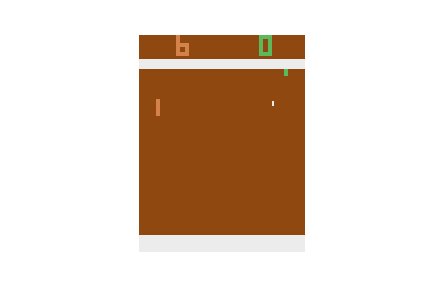
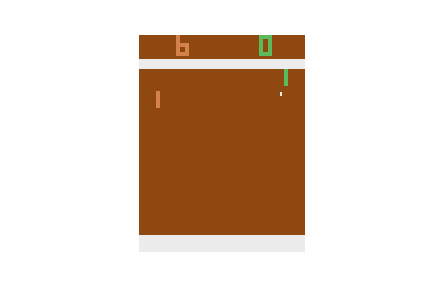
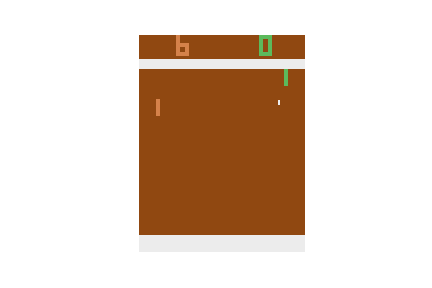
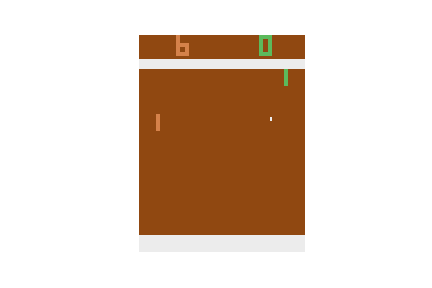
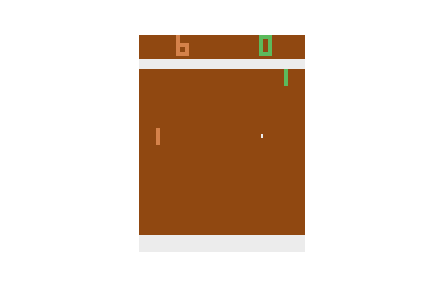
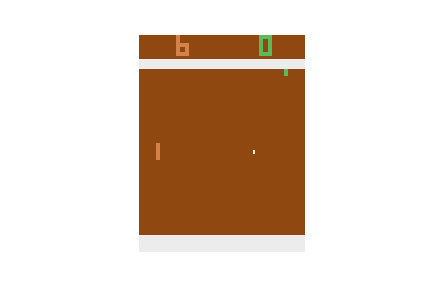
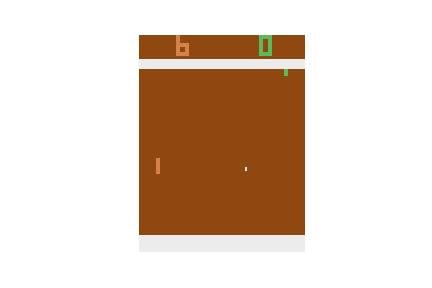
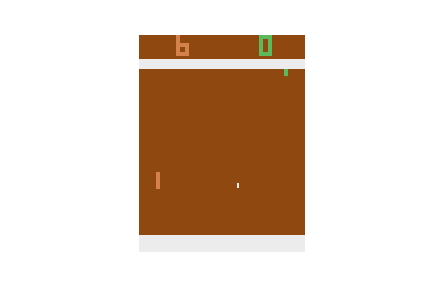
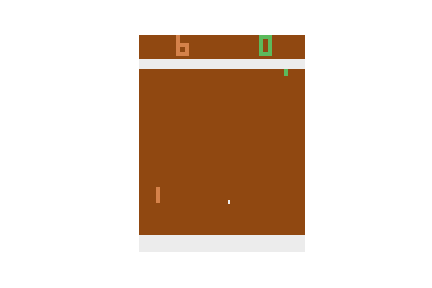
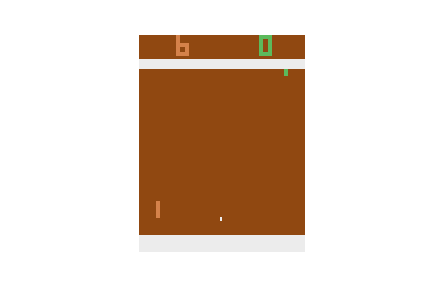
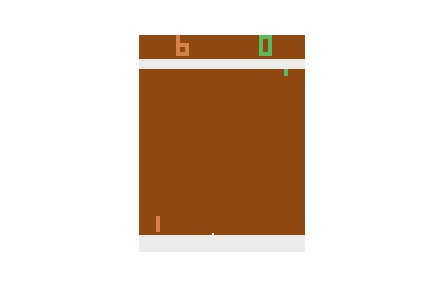
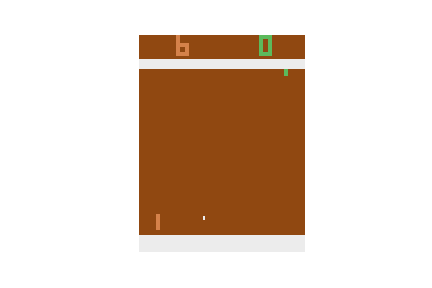
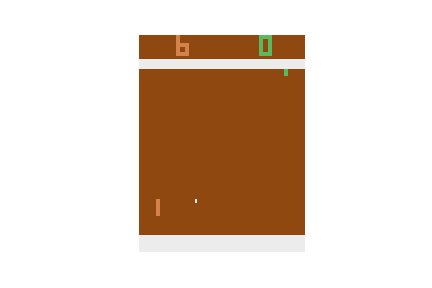
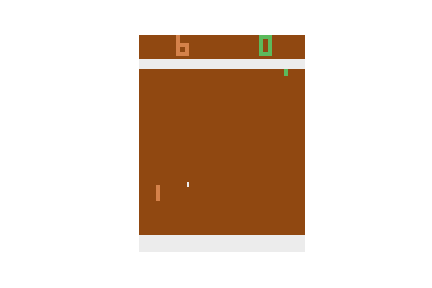
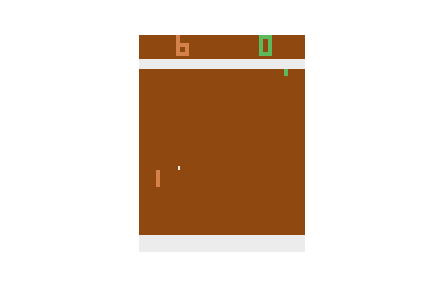
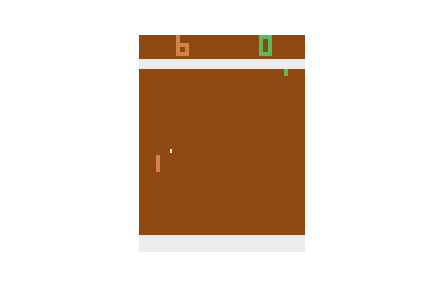
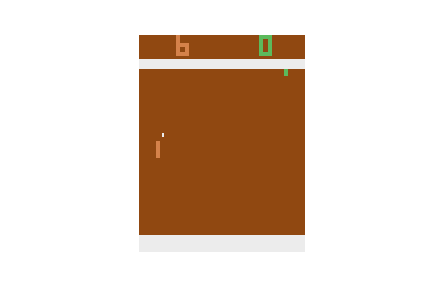
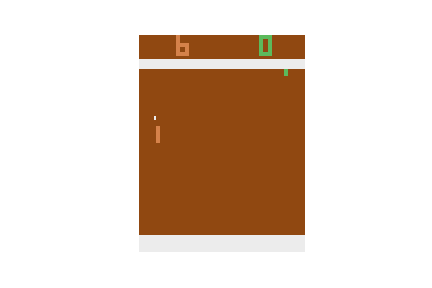
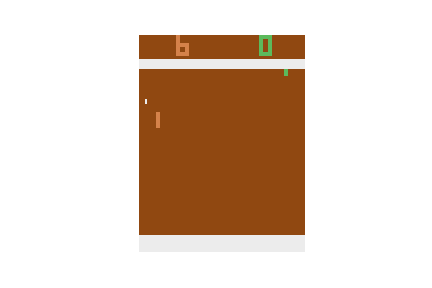
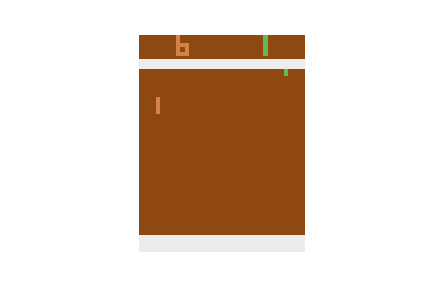
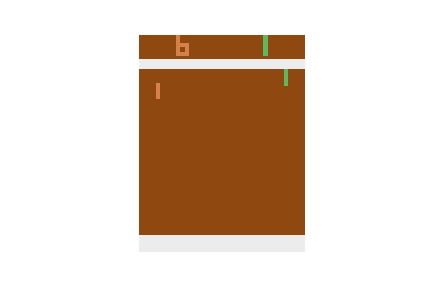
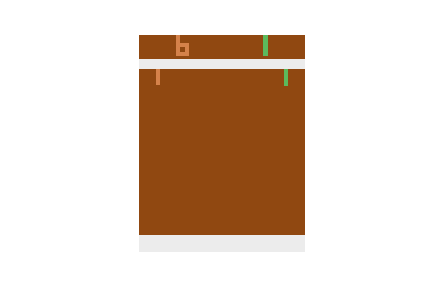
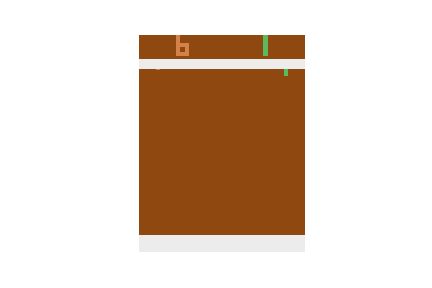
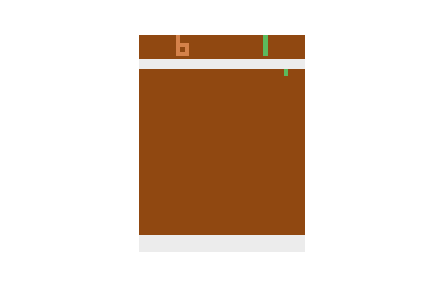
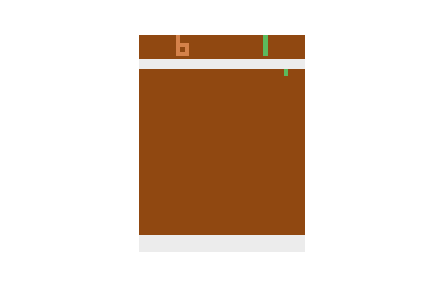
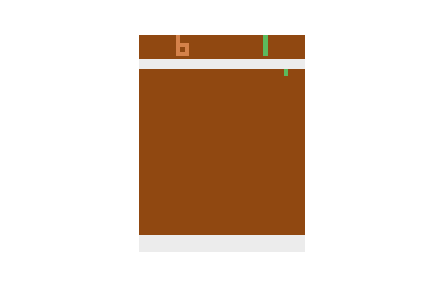
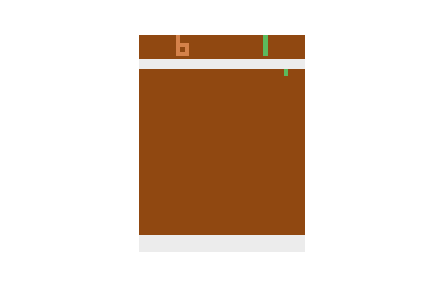
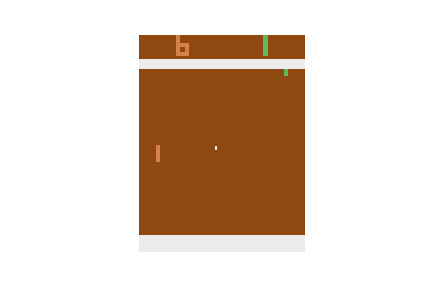
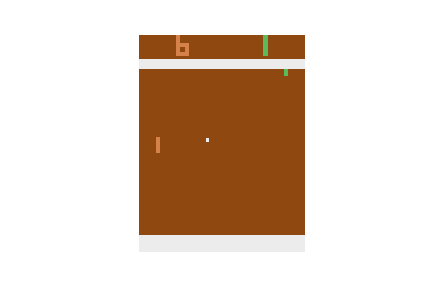
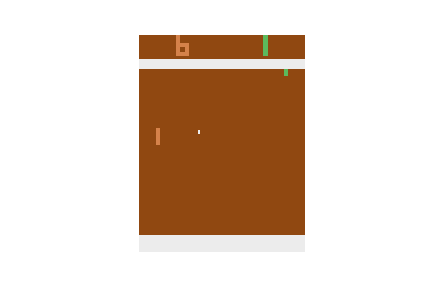
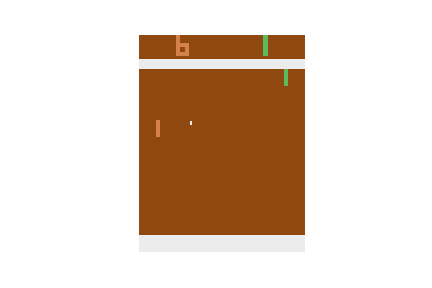
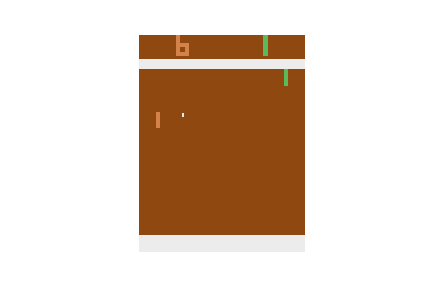
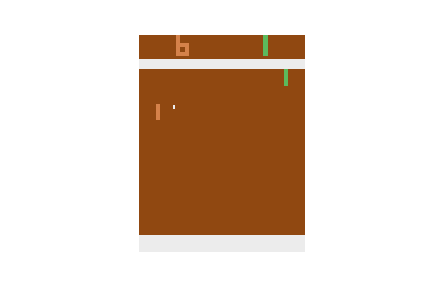
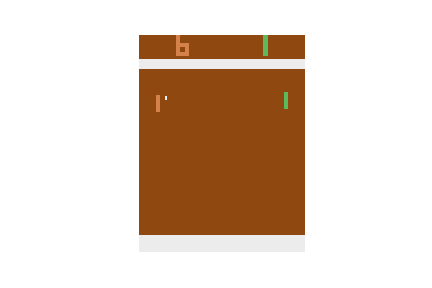
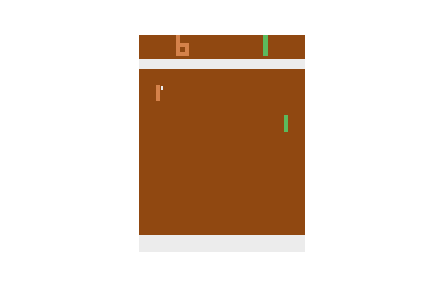

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [5]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
#     print(f"old_probs type: {type(old_probs)}, old_probs.shape: {np.shape(old_probs)}")
    
#     print(f"states type: {type(states)}, states len: {len(states)}")
#     print(f"state 0 size: {states[0].size()}, state value type: {states[0].type()}")
    
#     print(f"actions type: {type(actions)}, actions.shape: {len(actions)}")
#     print(f"action 0 shape: {actions[0].shape}")
    
#     print(f"rewards type: {type(rewards)}, rewards.size: {len(rewards)}")
#     print(f"rewards 0 shape: {rewards[0].shape}")
    
#     print(f"new_probs type: {type(new_probs)}, rewards.size: {new_probs.size()}")
#     print(f"new_probs 0 shape: {new_probs[0].shape}")
#     old_probs type: <class 'list'>, old_probs.shape: (320, 8)
#     states type: <class 'list'>, states len: 320
#     state 0 size: torch.Size([8, 2, 80, 80]), state value type: torch.FloatTensor
#     actions type: <class 'torch.Tensor'>, actions.shape: 320
#     action 0 shape: torch.Size([8])
#     rewards type: <class 'list'>, rewards.size: 320
#     rewards 0 shape: (8,)
#     new_probs type: <class 'torch.Tensor'>, rewards.size: torch.Size([320, 8])
#     new_probs 0 shape: torch.Size([8])

    n_trajectories = np.shape(old_probs)[1]
#     print(f"n_trajectories: {n_trajectories}")
    n_rewards = np.shape(old_probs)[0]
    
    discounts = torch.tensor([discount**i for i in range(n_rewards+1)], dtype = torch.float, device=device)
    rewards = torch.tensor(rewards, dtype = torch.float, device=device)
    R_future = []
#     print(f"discounts.size(): {discounts.size()}")
#     discounts.size(): torch.Size([321])
    for traj in range(n_trajectories):
        R_traj = torch.tensor([[rewards[i:, traj].dot(discounts[:-(i+1)])] for i in range(n_rewards)], dtype = torch.float, device=device)
#         print(f"R_traj.mean(): {R_traj.mean()}")
#         print(f"R_traj.std(): {R_traj.std()}")
#         print(f"R_traj: {R_traj[:2]}")
#         raise Exception("stop here")
        R_traj_normalized = (R_traj - R_traj.mean())/(R_traj.std() + 1.0e-10)
        R_future.append(R_traj_normalized)
    R_future = torch.cat(R_future, 1)
#     print(f"R_future.size(): {R_future.size()}")
#     R_future.size(): torch.Size([320, 8])
    
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    ratio = new_probs / old_probs
#     print(f"ratio.size(): {ratio.size()}")
#     raise Exception("stop here")
#     ratio.size(): torch.Size([320, 8])
    ratio_clipped = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    losses = torch.min(ratio * R_future, ratio_clipped * R_future)
#     print(f"losses size: {losses.size()}")
#     raise Exception("stop here")
    ####################################################

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(losses + beta*entropy)


In [13]:
# Future rewards
rewards = np.array([0, 1, 0, 0, 2])
discounts = np.array([0.9**i for i in range(n_rewards+1)])
R_future_discounted = torch.FloatTensor([rewards[i:].dot(discounts[:-(i+1)]) for i in range(n_rewards)])
R_future_normalized = (R_future_discounted - R_future_discounted.mean())/R_future_discounted.std()
print(f"n_rewards: {n_rewards}")
print(f"rewards: {rewards}, discounts: {discounts}")
print(f"R_future_discounted: {R_future_discounted}")
print(f"R_future_normalized: {R_future_normalized}")

n_rewards: 5
rewards: [0 1 0 0 2], discounts: [1.      0.9     0.81    0.729   0.6561  0.59049]
R_future_discounted: tensor([ 2.2122,  2.4580,  1.6200,  1.8000,  2.0000])
R_future_normalized: tensor([ 0.5870,  1.3302, -1.2035, -0.6592, -0.0545])


In [35]:
a1 = np.array([[1, 1], [2, 2]])
a2 = np.array([[1, 1], [2, 2]])
a1 * a2

[1]*2

np.array([[1, 2], [3, 4]]) * np.array([[1], [2]])

array([[1, 2],
       [6, 8]])

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [6]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!

#         L2 = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
#                                           epsilon=epsilon, beta=beta)
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
#         print(f"L: {L}, L2: {L2}")
#         raise Exception("stop here")
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -14.750000
[-12. -16. -15. -11. -16. -17. -16. -15.]


Episode: 40, score: -15.375000
[-16. -15. -16. -12. -16. -16. -16. -16.]


Episode: 60, score: -13.875000
[-15. -11. -12. -16. -13. -16. -15. -13.]


Episode: 80, score: -14.750000
[-17. -15. -12. -16. -16. -11. -16. -15.]


Episode: 100, score: -12.750000
[-16. -16. -10. -14. -17.  -8. -12.  -9.]


Episode: 120, score: -13.875000
[-15. -16. -13. -12. -11. -14. -17. -13.]


Episode: 140, score: -14.375000
[-15. -15.  -9. -16. -15. -16. -16. -13.]


Episode: 160, score: -15.500000
[-15. -16. -15. -16. -16. -16. -16. -14.]


Episode: 180, score: -14.750000
[-16. -15. -16. -15. -16.  -8. -16. -16.]


Episode: 200, score: -14.625000
[-14. -16. -15. -16. -14. -16. -12. -14.]


Episode: 220, score: -15.625000
[-16. -17. -16. -16. -12. -16. -16. -16.]


Episode: 240, score: -14.000000
[-12. -16. -14. -12. -14. -13. -14. -17.]


Episode: 260, score: -13.875000
[-12. -13. -16. -14. -11. -16. -15. -14.]


Episode: 280, score: -14.125000
[-17. -14. -11. -17. -16. -14. -15.  -9.]


Episode: 300, score: -13.625000
[ -7. -12. -16. -13. -15. -15. -16. -15.]


Episode: 320, score: -14.125000
[-14. -15. -17. -13. -16. -12. -12. -14.]


Episode: 340, score: -15.625000
[-16. -16. -15. -16. -15. -16. -15. -16.]


Episode: 360, score: -14.000000
[-15. -14. -12. -14. -14. -13. -16. -14.]


Episode: 380, score: -13.750000
[-16. -11. -14. -16. -11. -10. -17. -15.]


Episode: 400, score: -13.250000
[-12. -16. -12. -12. -15. -10. -13. -16.]


Episode: 420, score: -13.625000
[-12. -16. -16. -16. -16.  -9.  -9. -15.]


Episode: 440, score: -13.125000
[-10. -15. -15. -16. -12. -13. -14. -10.]


Episode: 460, score: -14.750000
[-16. -16. -16. -12. -15. -14. -16. -13.]


Episode: 480, score: -14.500000
[-15. -16. -12. -16. -15. -16. -11. -15.]


Episode: 500, score: -13.750000
[-15. -16.  -9. -14. -14. -16. -10. -16.]


Episode: 520, score: -13.625000
[-13. -11.  -9. -16. -16. -15. -16. -13.]


Episode: 540, score: -14.625000
[-14. -15. -16. -14. -14. -16. -12. -16.]


Episode: 560, score: -15.125000
[-16. -16. -16. -16. -15. -11. -16. -15.]


Episode: 580, score: -13.375000
[-12. -15. -12. -17. -16. -16.  -9. -10.]


Episode: 600, score: -12.625000
[ -9. -13.  -9. -13. -14. -15. -15. -13.]


Episode: 620, score: -11.750000
[-16. -12.  -8. -12. -15. -10. -12.  -9.]


Episode: 640, score: -13.125000
[-14. -16. -10. -14. -13. -11. -13. -14.]


Episode: 660, score: -13.750000
[-10. -15. -16. -10. -13. -15. -14. -17.]


Episode: 680, score: -12.625000
[-10. -16. -12. -13. -16.  -9. -16.  -9.]


Episode: 700, score: -13.875000
[-13. -12. -16. -13. -16. -14. -13. -14.]


Episode: 720, score: -13.500000
[-16.  -5. -15. -16. -16. -12. -12. -16.]


Episode: 740, score: -14.125000
[-12. -14. -14. -16. -15. -14. -13. -15.]


Episode: 760, score: -12.875000
[-16.  -6. -16. -15. -16. -13.  -8. -13.]


Episode: 780, score: -9.250000
[-12.  -9.  -6. -11.  -7.  -8.  -9. -12.]


Episode: 800, score: -11.625000
[ -8. -15. -11.  -9. -14. -12. -12. -12.]


Episode: 820, score: -11.625000
[ -8.  -9. -10.  -9. -13. -15. -14. -15.]


Episode: 840, score: -11.375000
[-12. -15. -14. -12. -11. -10.  -9.  -8.]


Episode: 860, score: -12.625000
[-10. -12. -11. -14. -15. -15. -11. -13.]


Episode: 880, score: -13.500000
[-13. -15. -13. -11. -15. -12. -13. -16.]


Episode: 900, score: -11.625000
[ -9. -14. -12. -13. -12. -11. -12. -10.]


Episode: 920, score: -11.125000
[-11. -10. -12. -13. -12. -13. -10.  -8.]


Episode: 940, score: -9.500000
[ -9.  -8. -11. -11. -11.  -6.  -7. -13.]


Episode: 960, score: -11.500000
[-14. -12.  -8. -11. -10. -11. -11. -15.]


Episode: 980, score: -12.750000
[-12.  -8. -11. -16. -16. -11. -16. -12.]


Episode: 1000, score: -11.000000
[-11.  -6. -10. -11. -10. -11. -15. -14.]



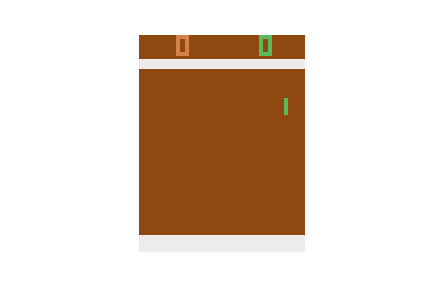
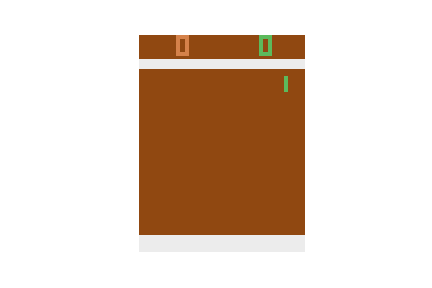
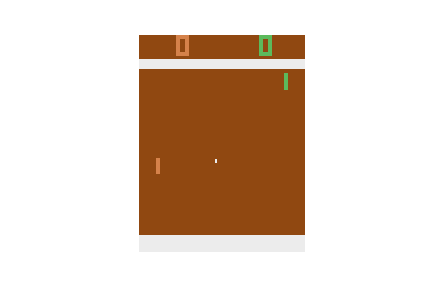
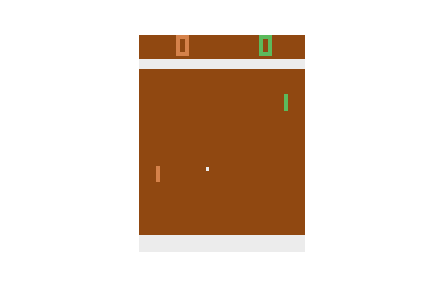
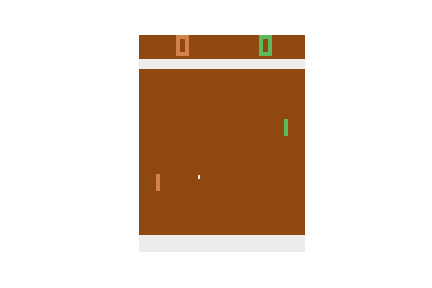
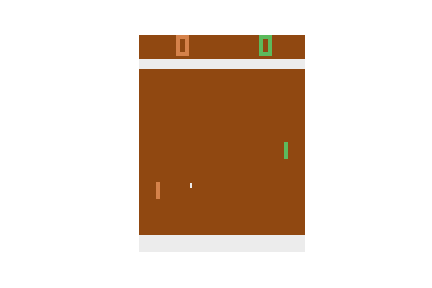
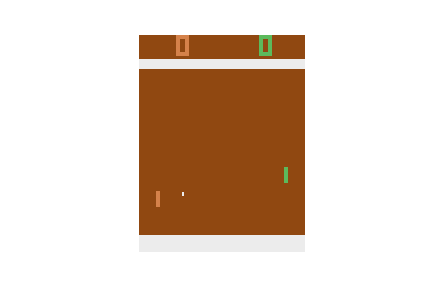
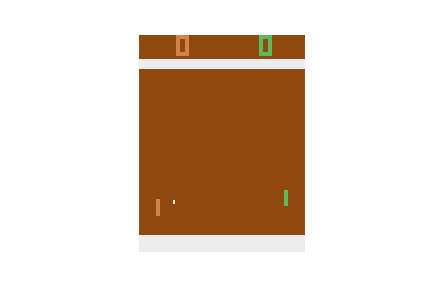
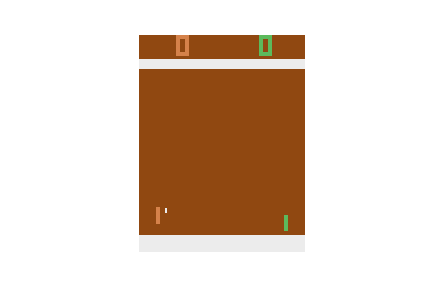
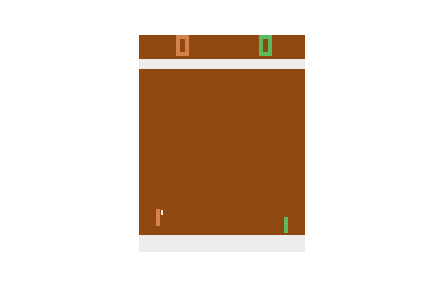
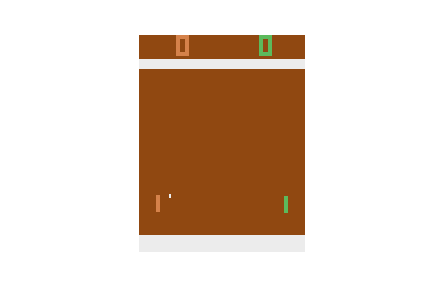
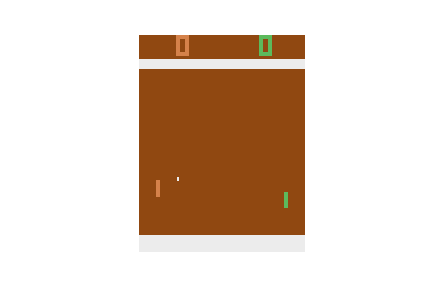
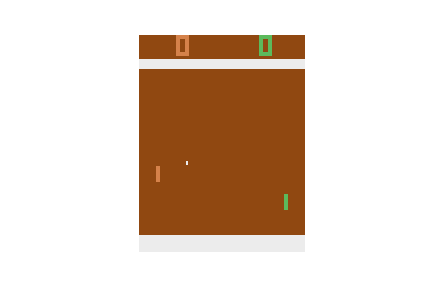
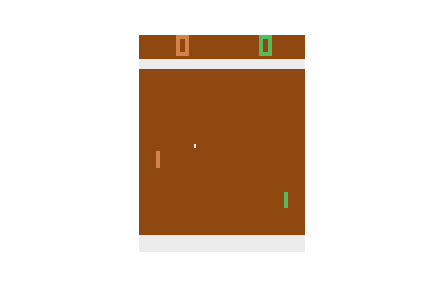
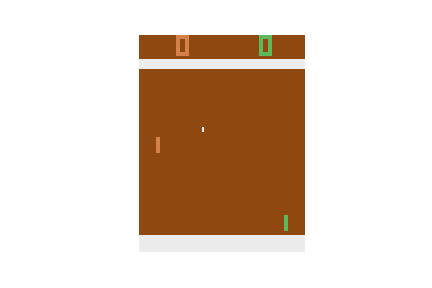
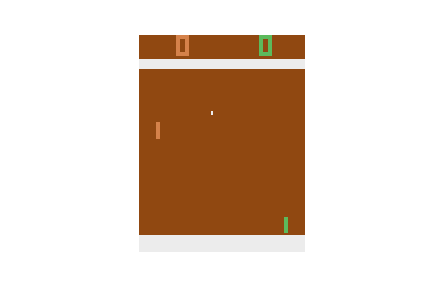
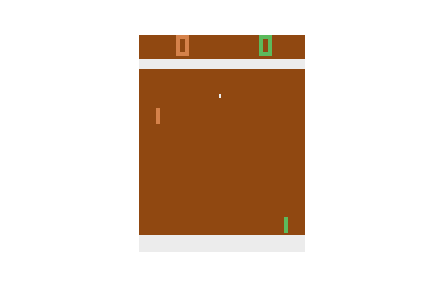
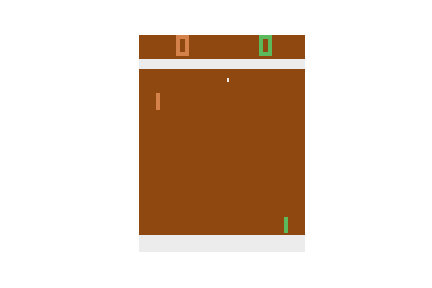
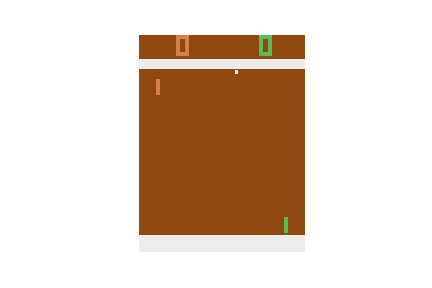
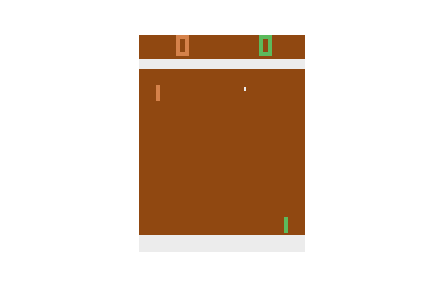
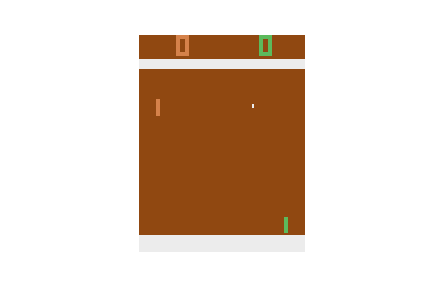
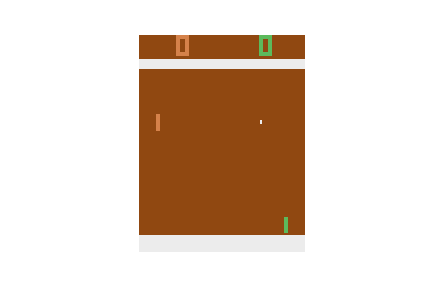
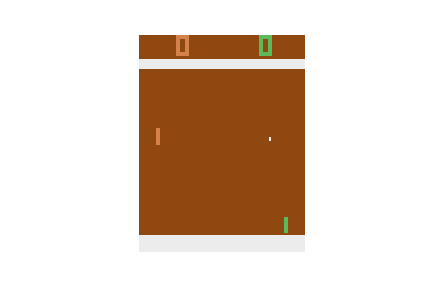
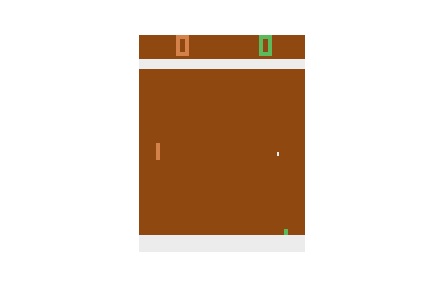
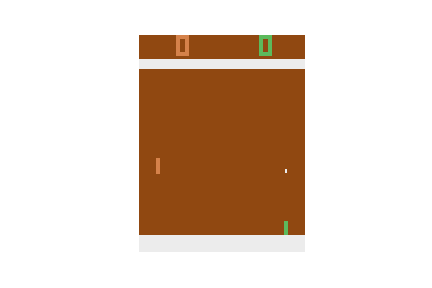
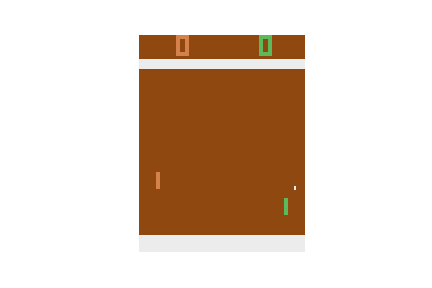
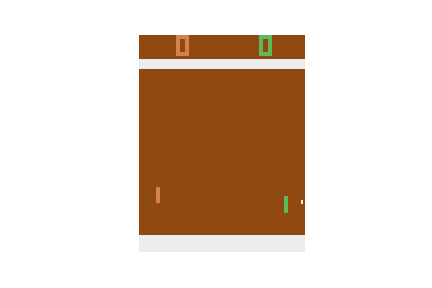
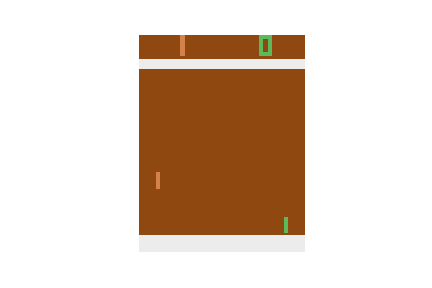
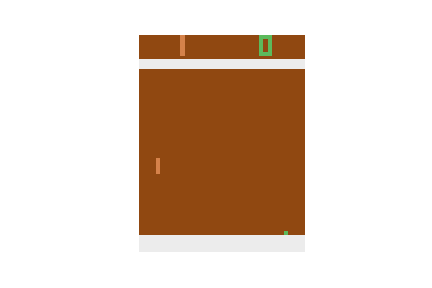
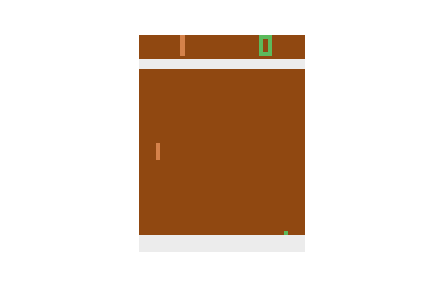
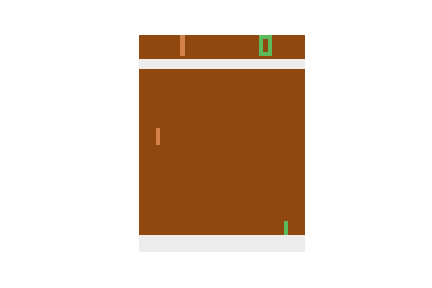
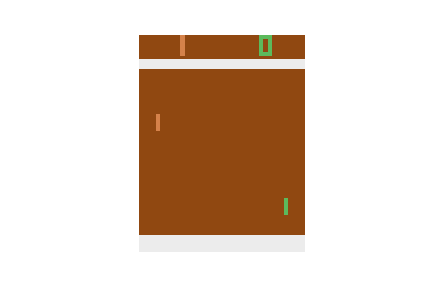
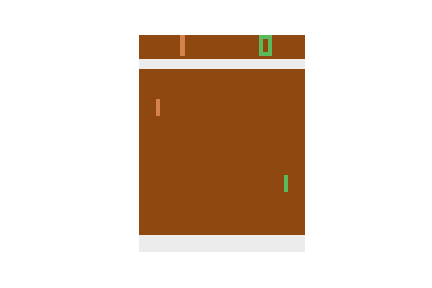
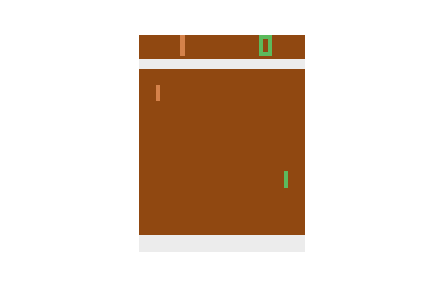
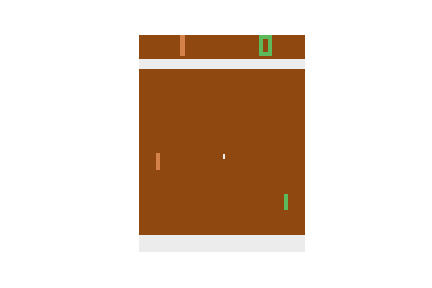
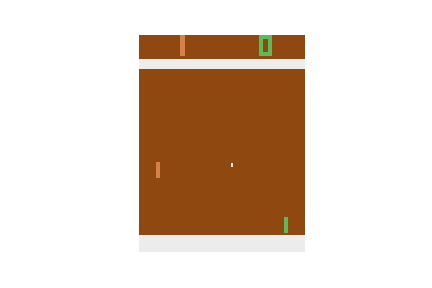
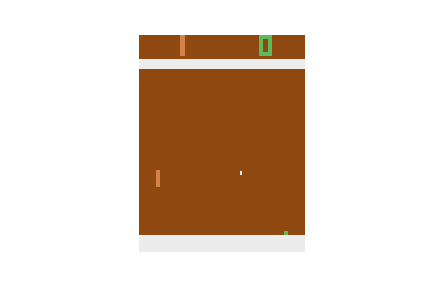
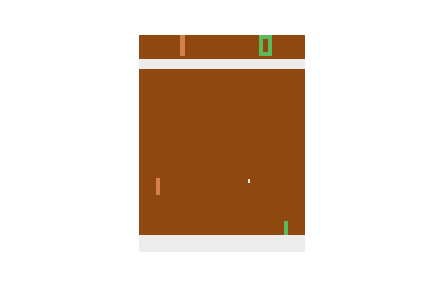
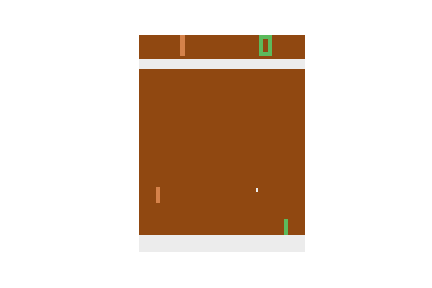
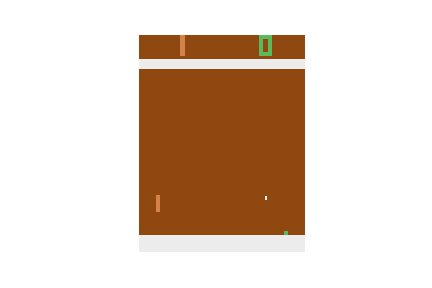
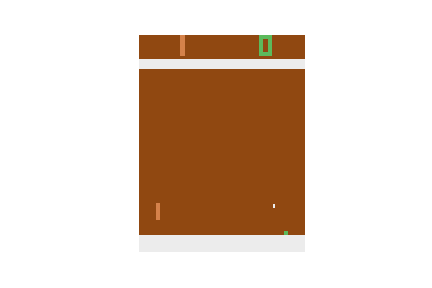
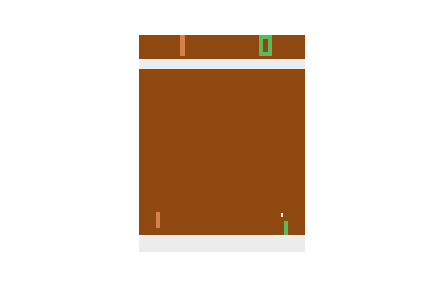
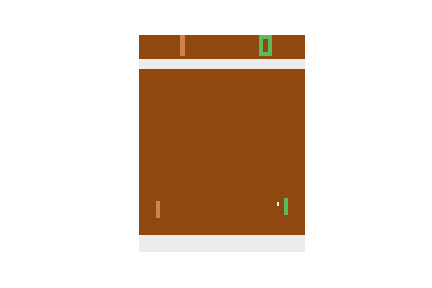
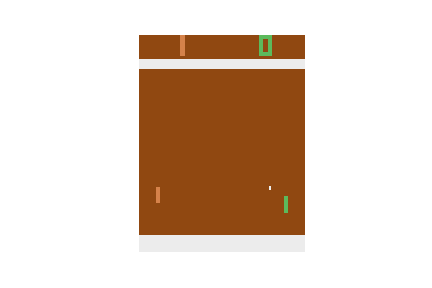
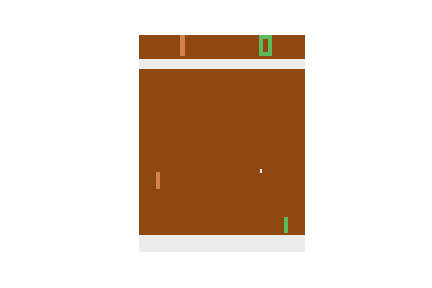
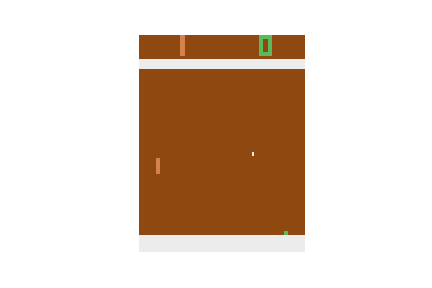
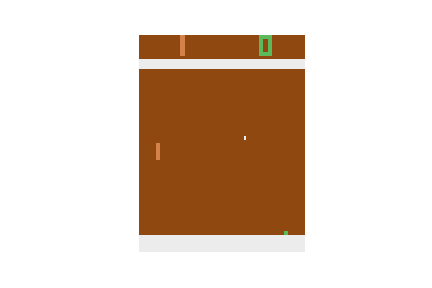
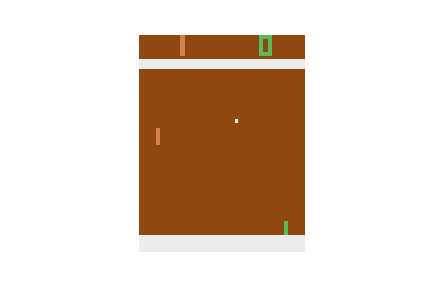
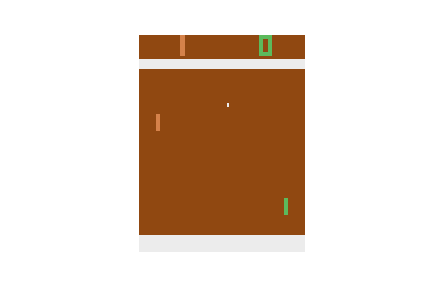
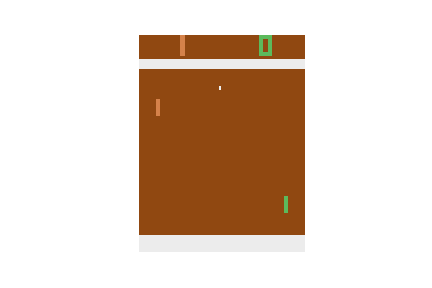
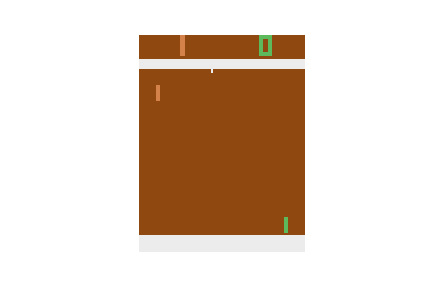
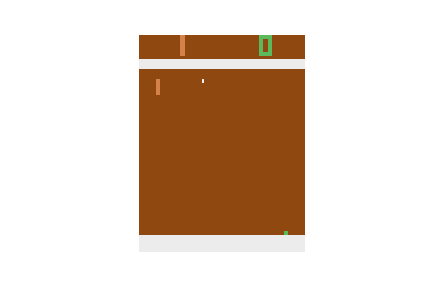
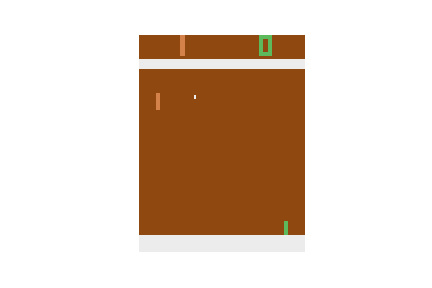
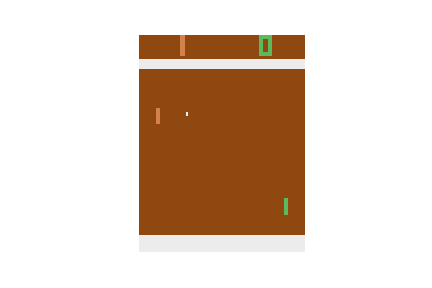
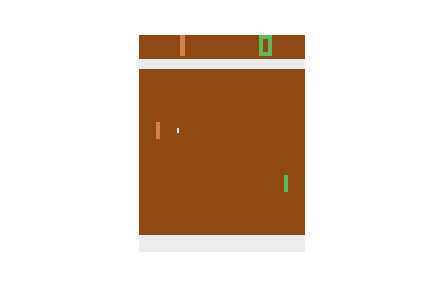
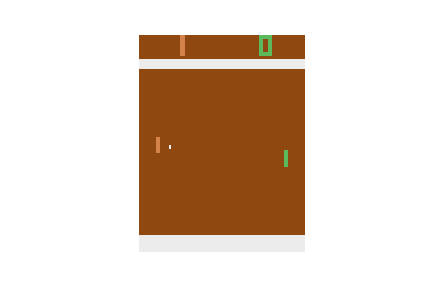
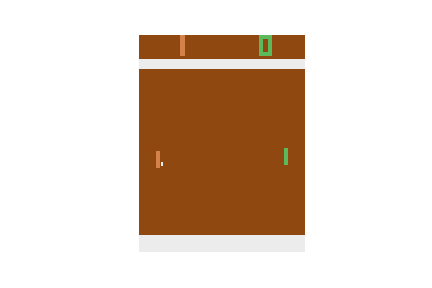
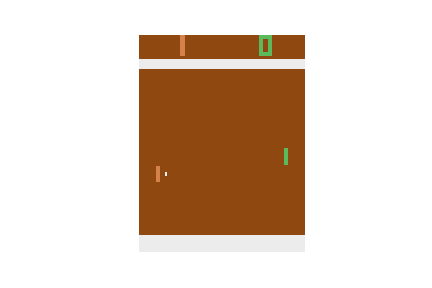
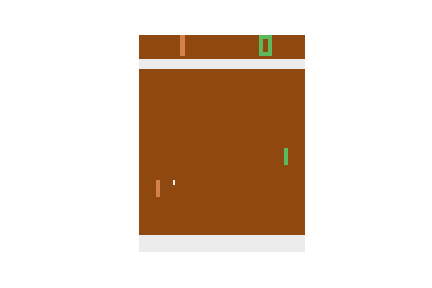
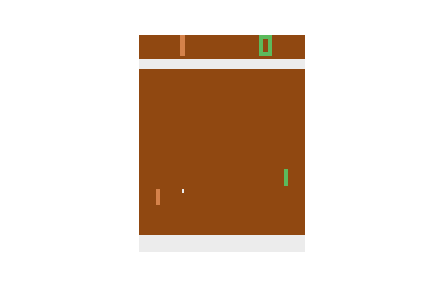
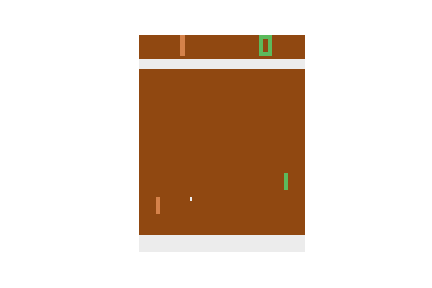
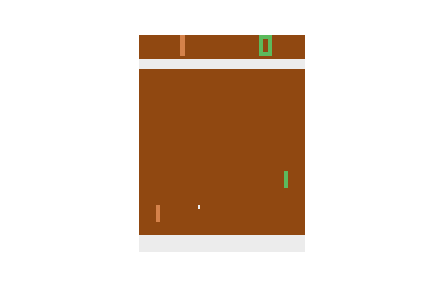
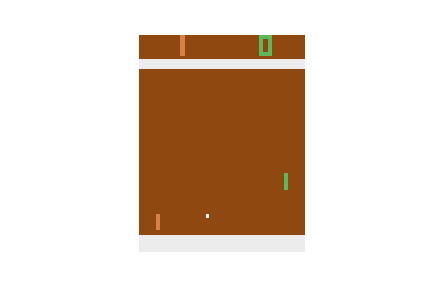
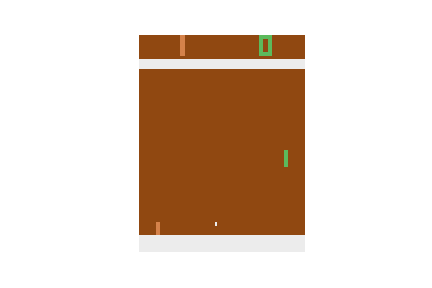
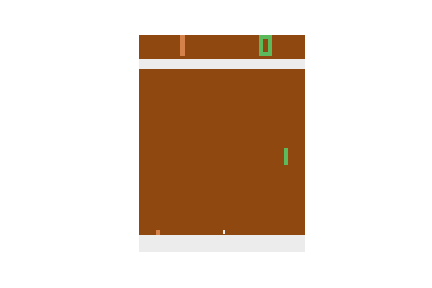
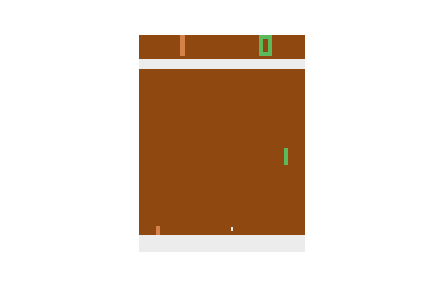
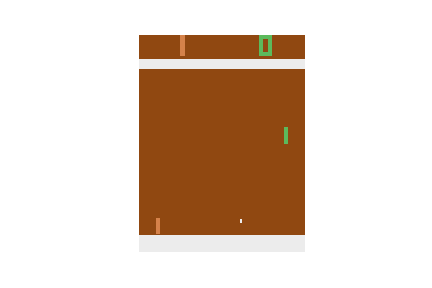
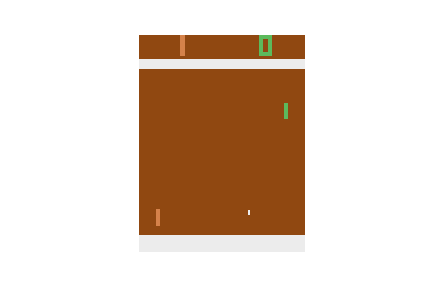
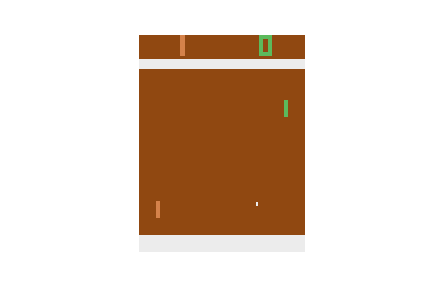
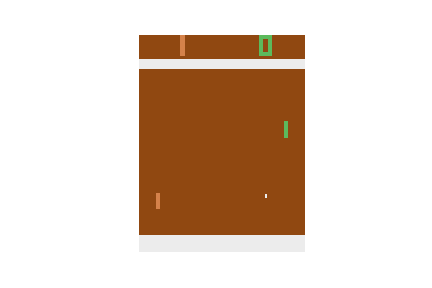
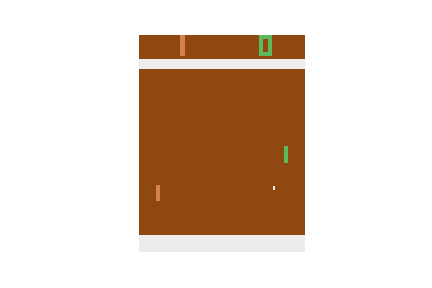
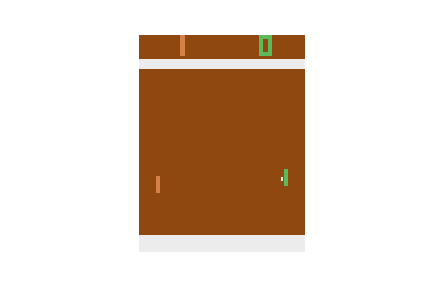
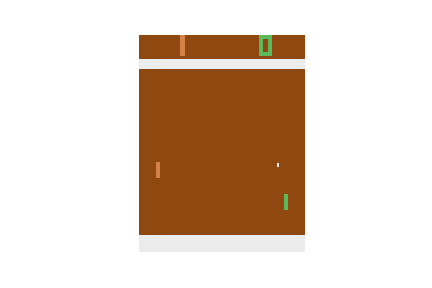
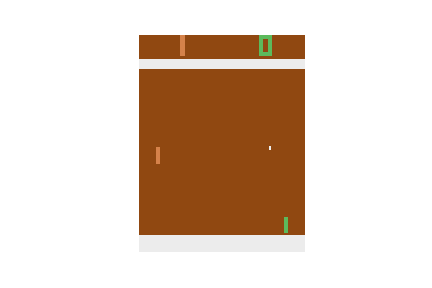
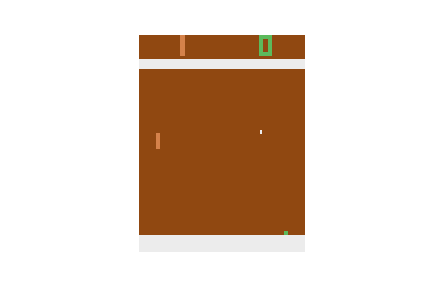
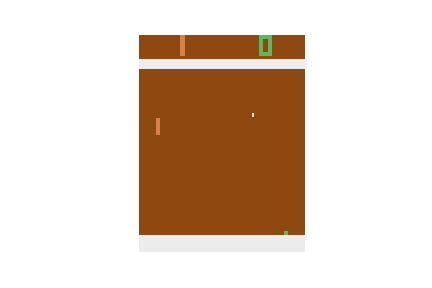
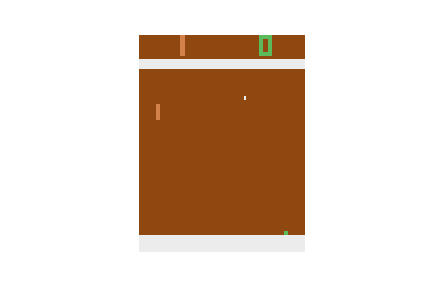
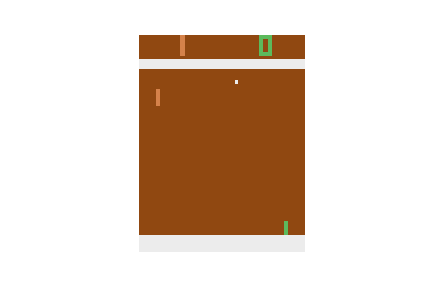
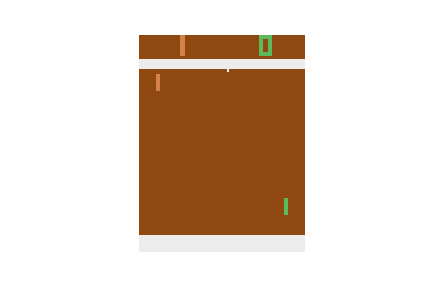
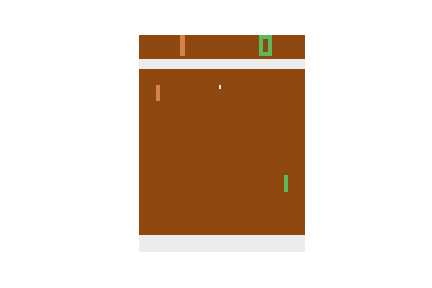
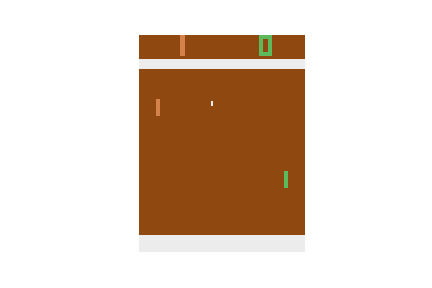
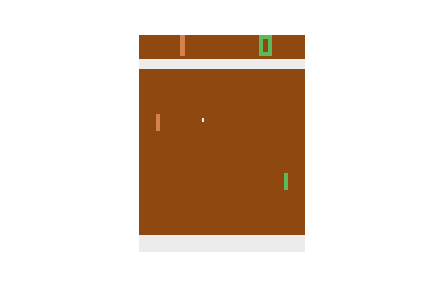
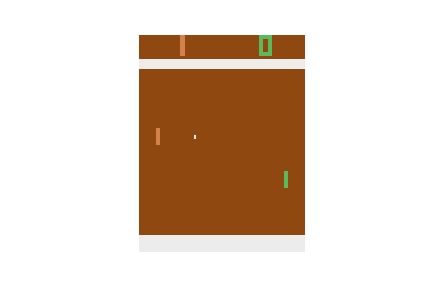
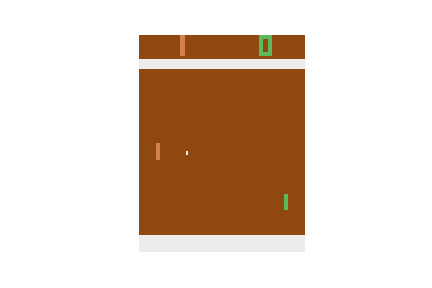
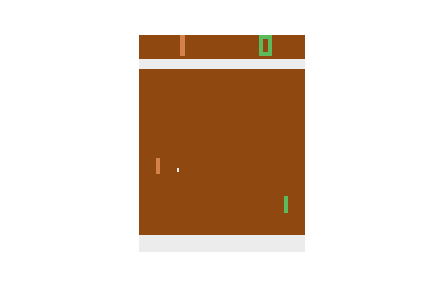
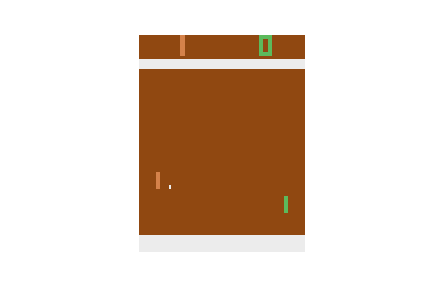
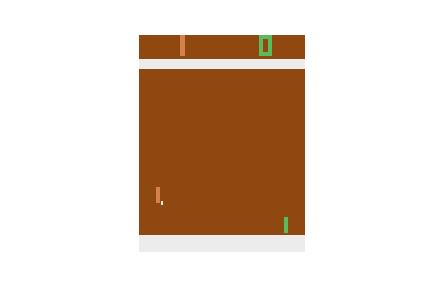
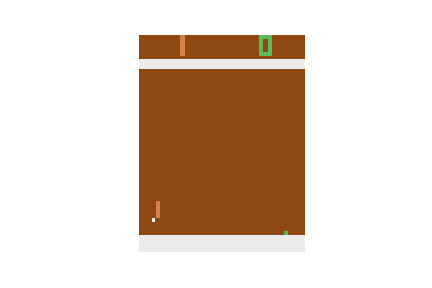
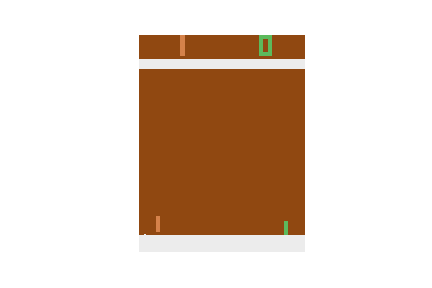
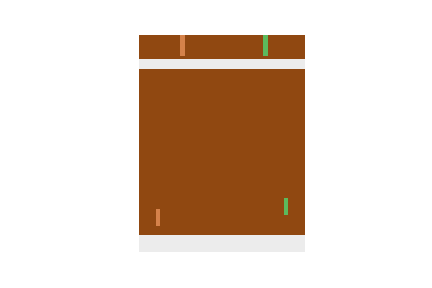
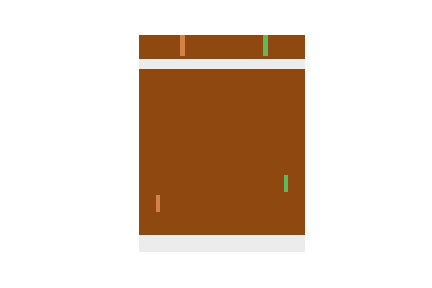
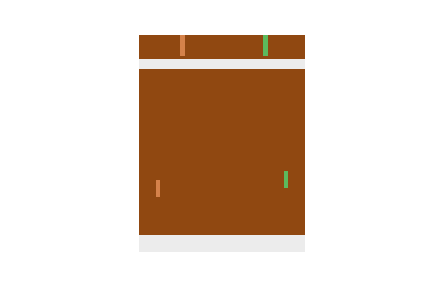
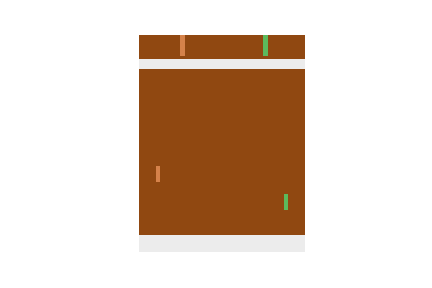
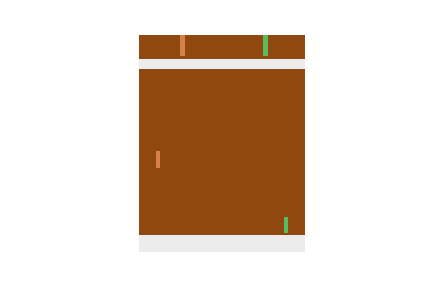
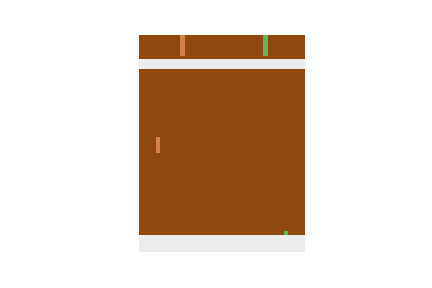
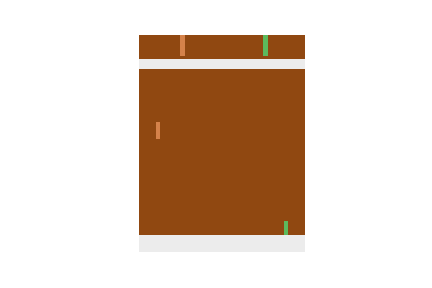
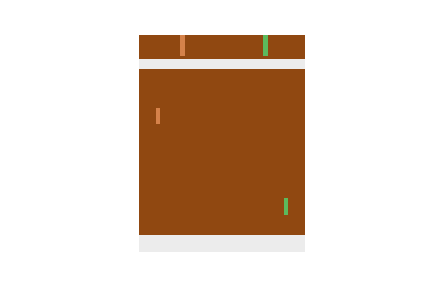
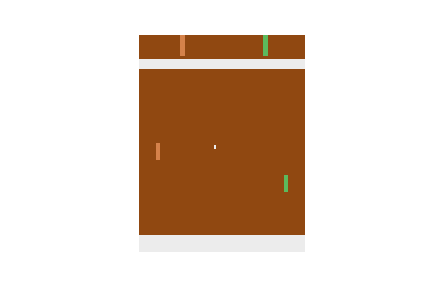
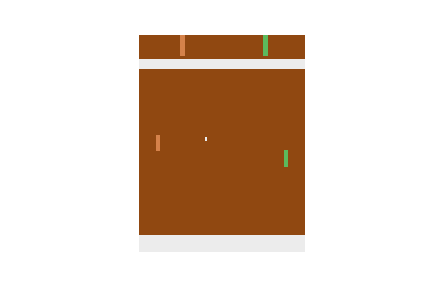
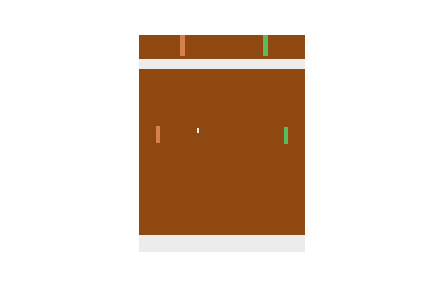
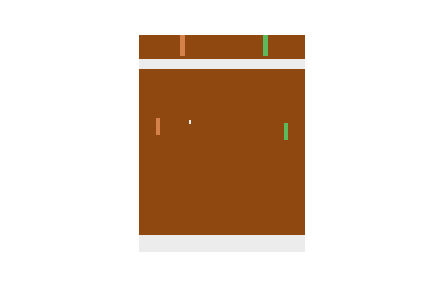
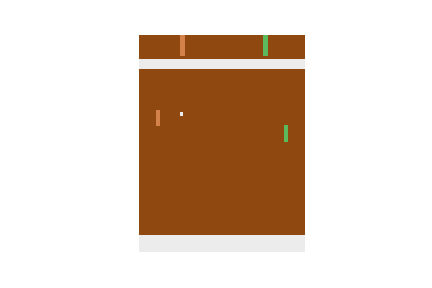
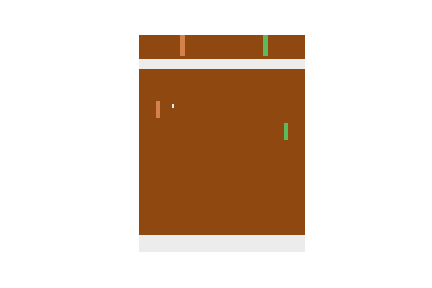
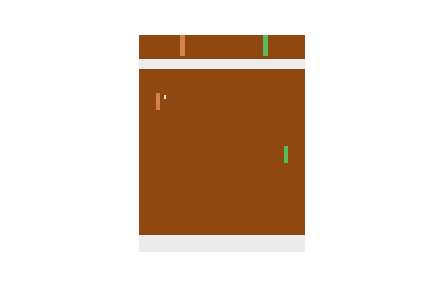
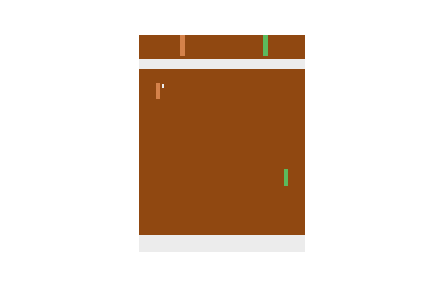
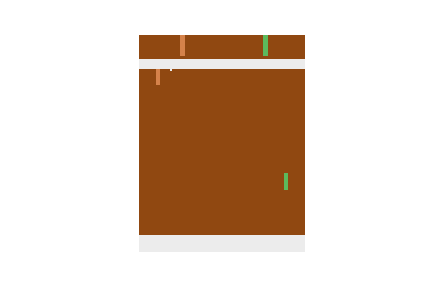
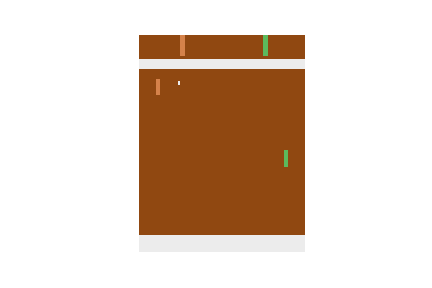
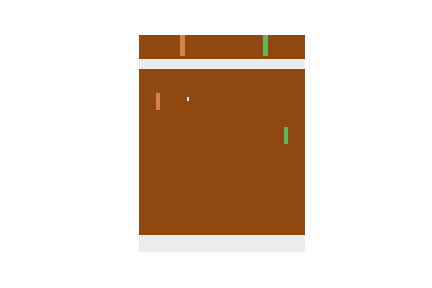
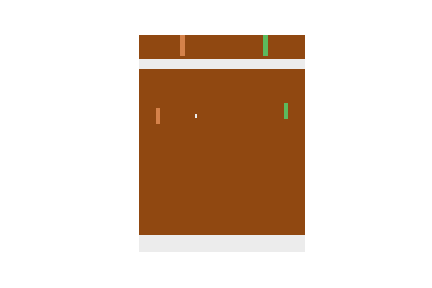
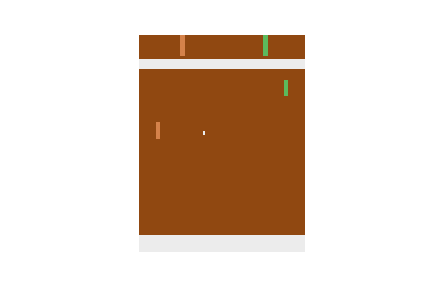
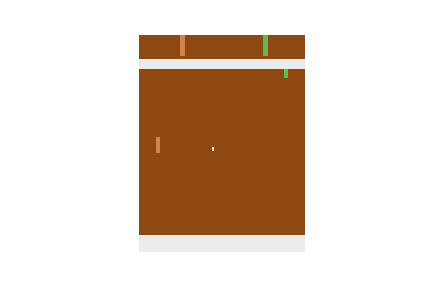
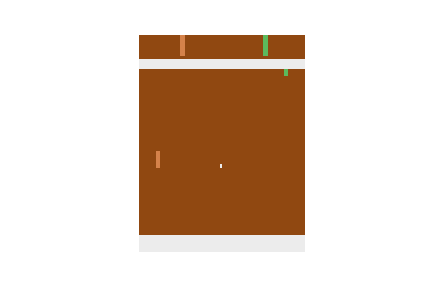
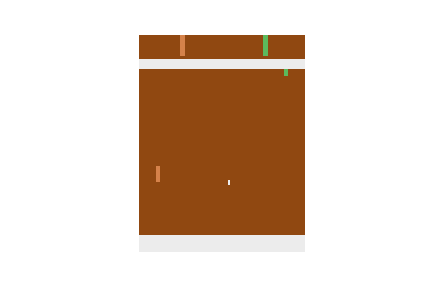
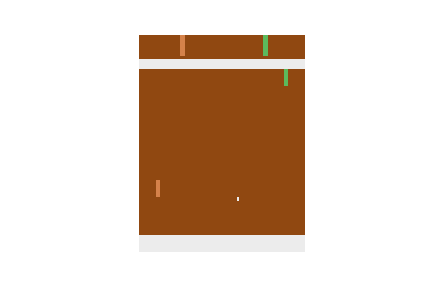
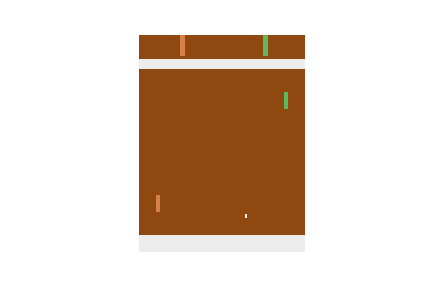
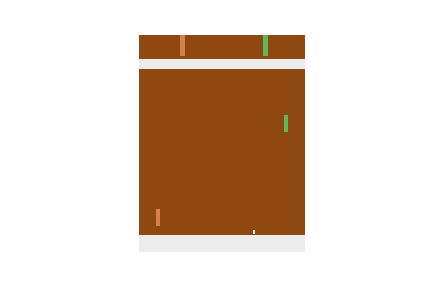
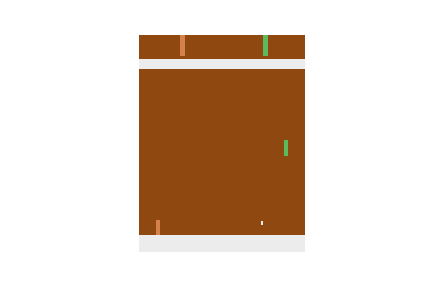
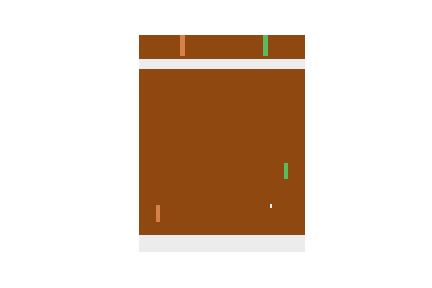
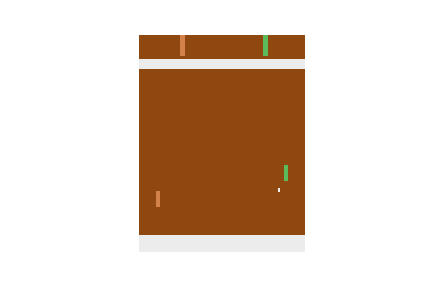
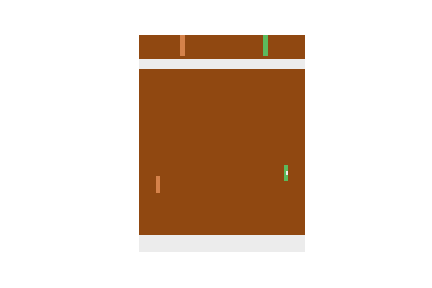
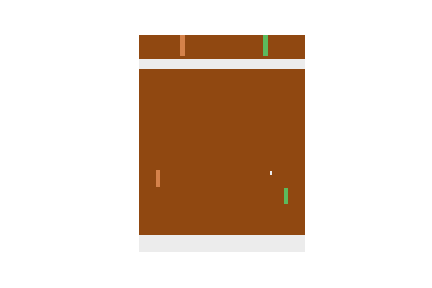
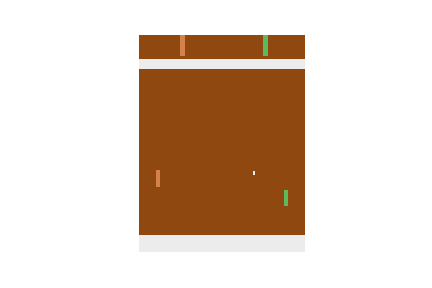
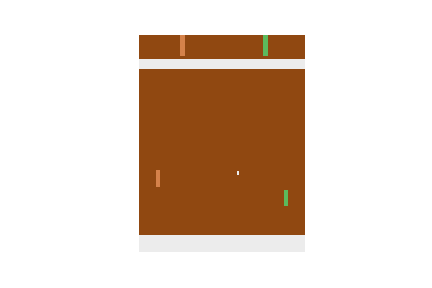
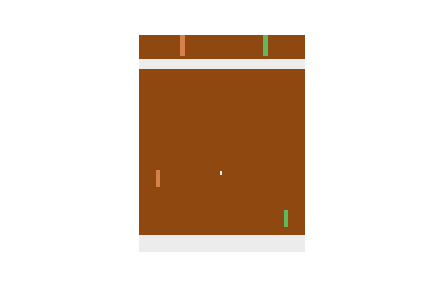
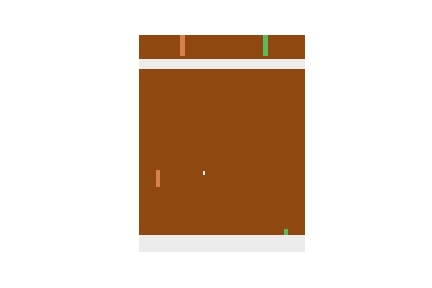
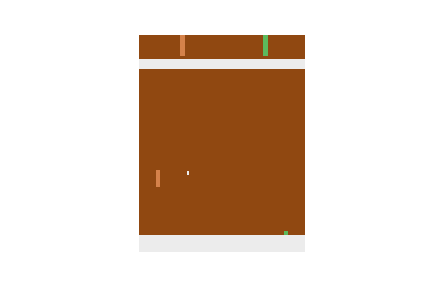
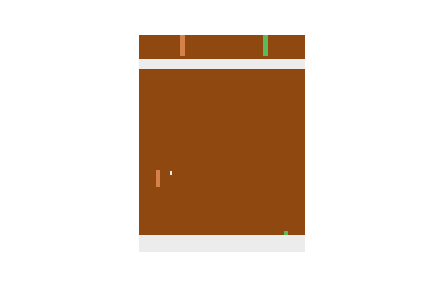
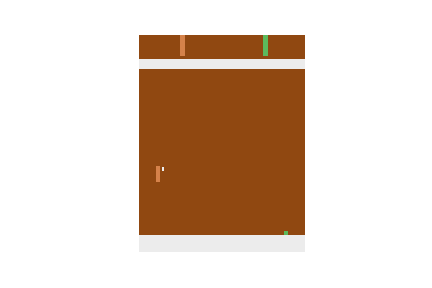
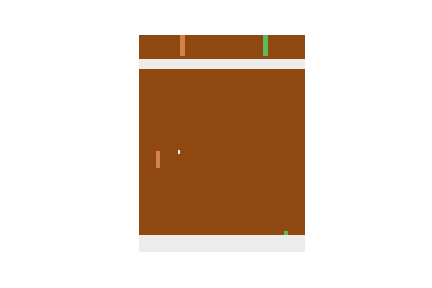
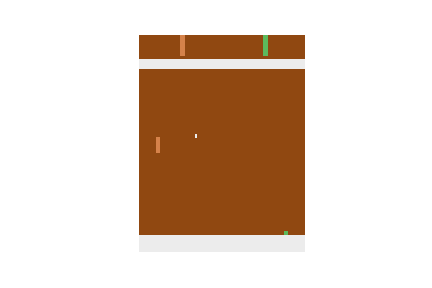
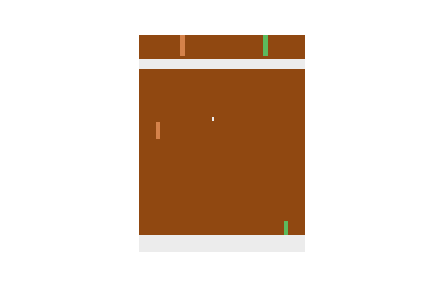
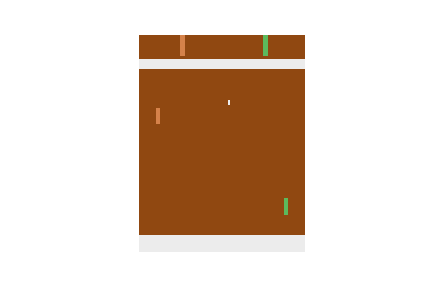
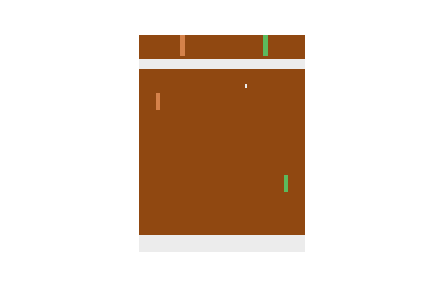
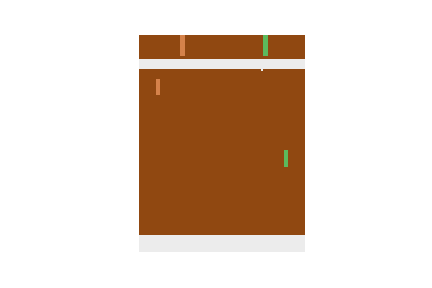
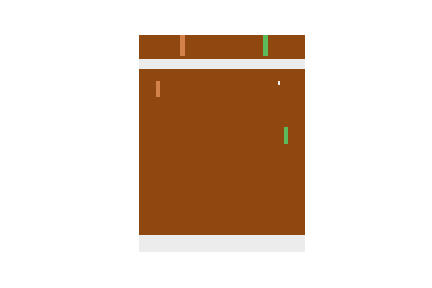
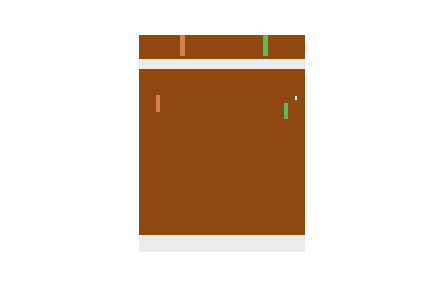
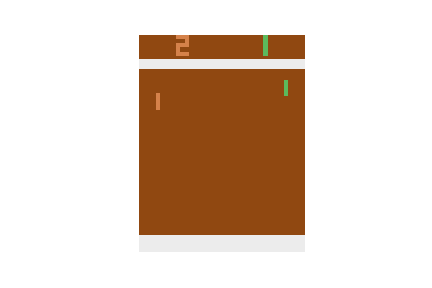
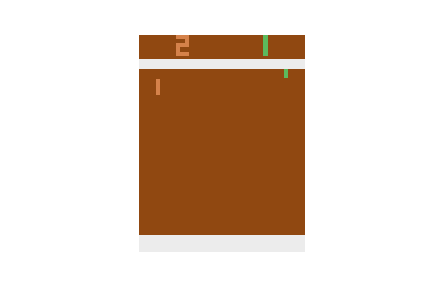
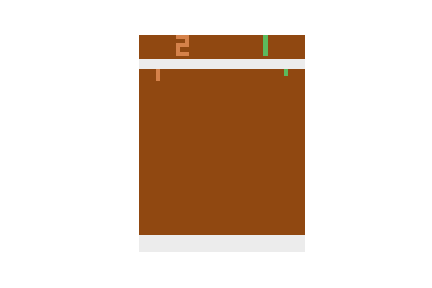
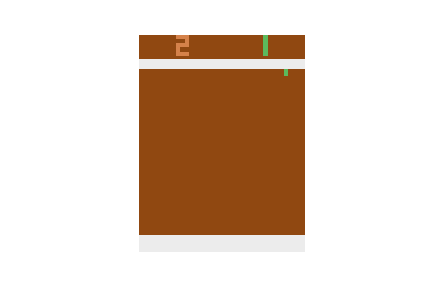
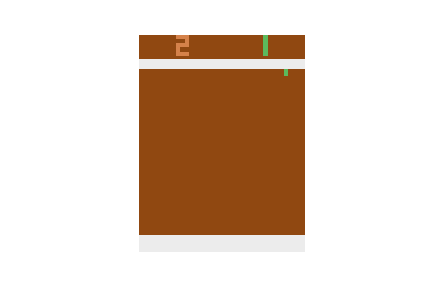
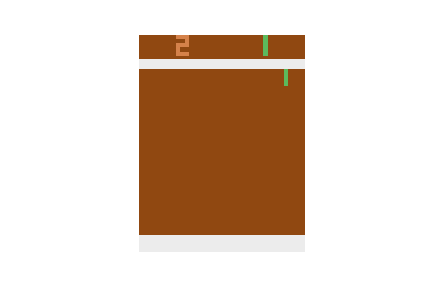
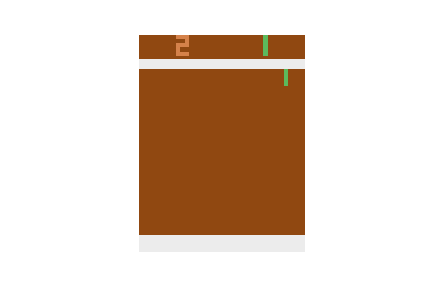
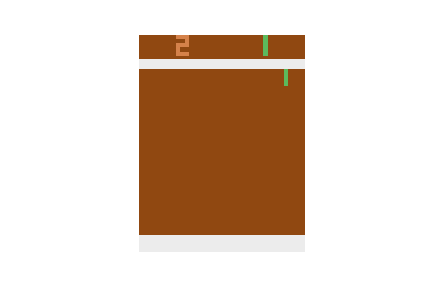
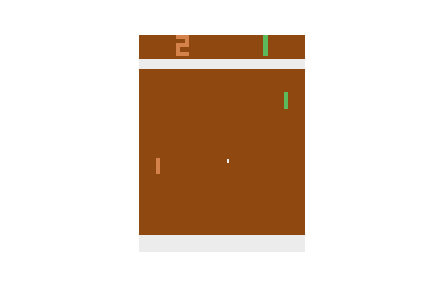
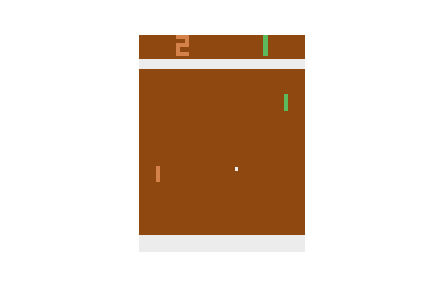
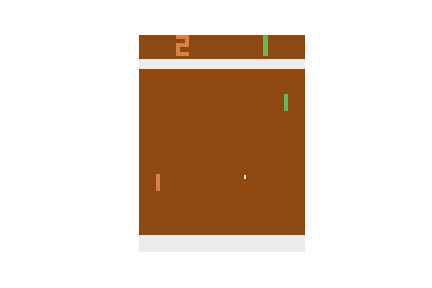
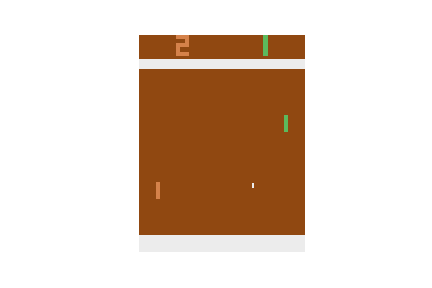
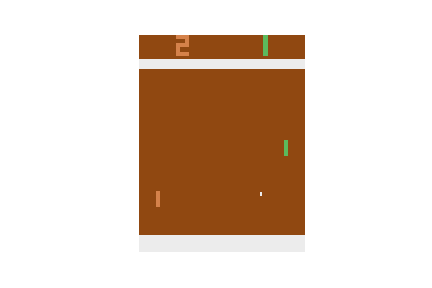
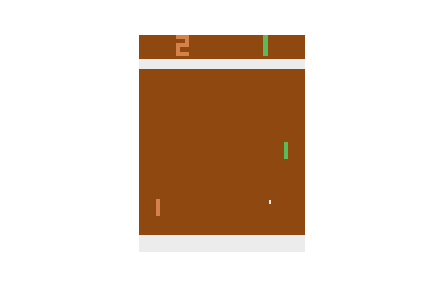
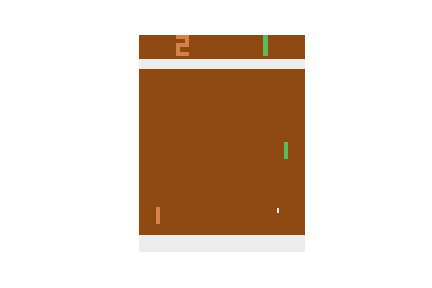
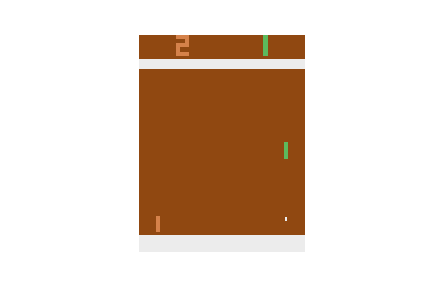
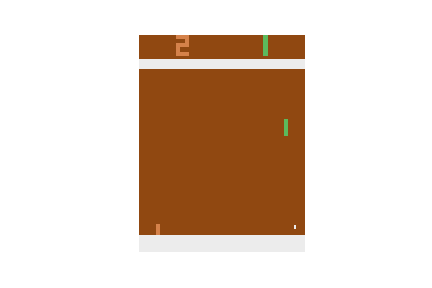
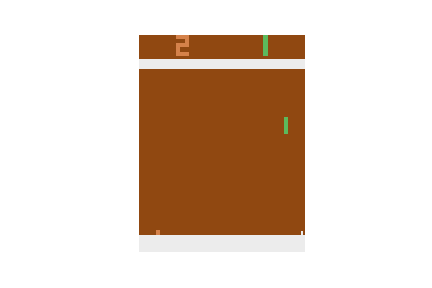
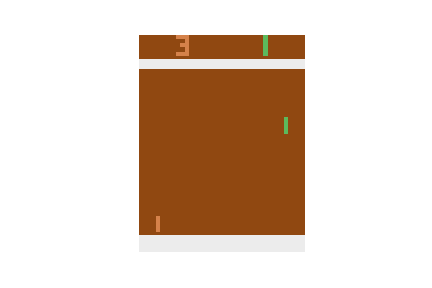
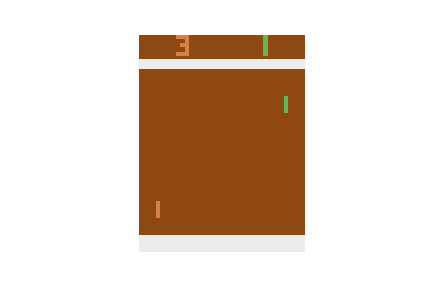
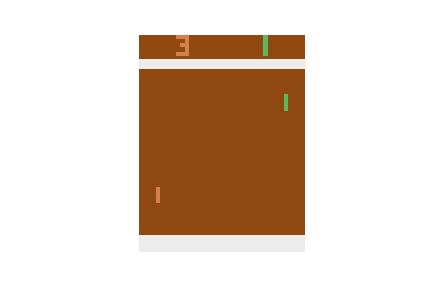
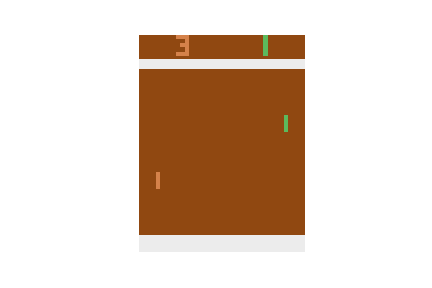
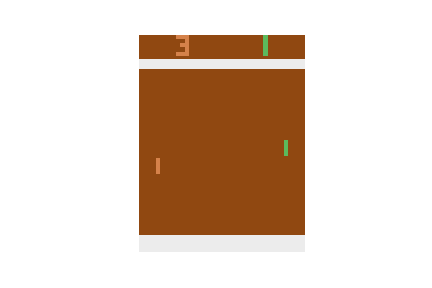
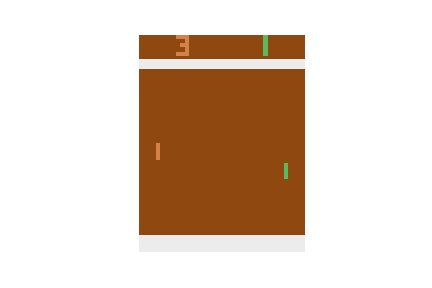
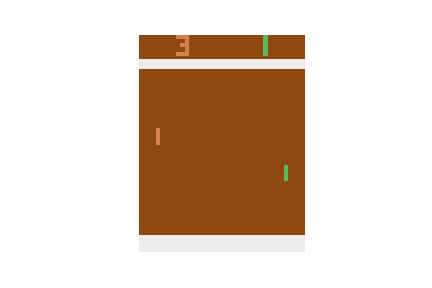
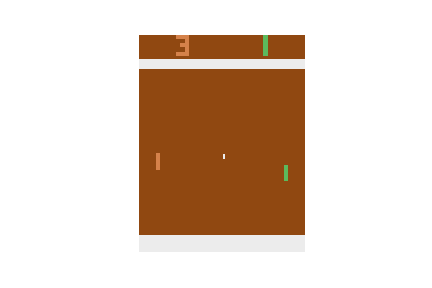
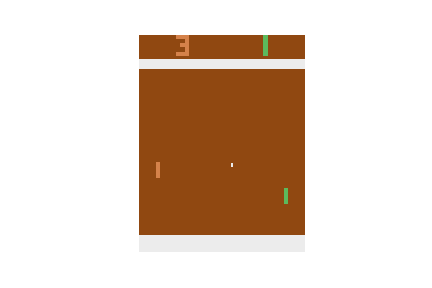
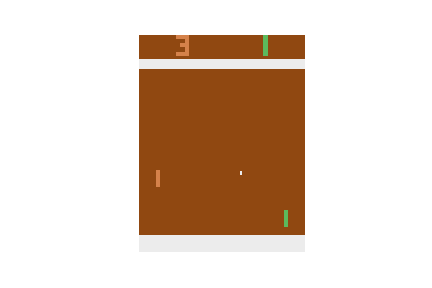
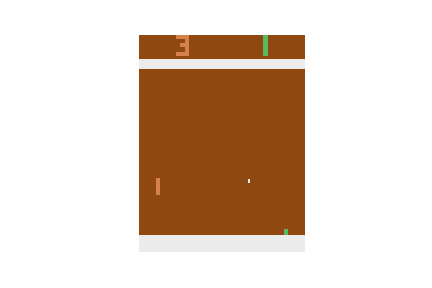
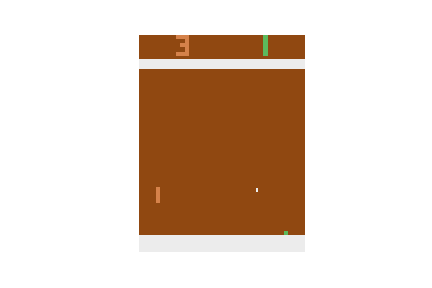
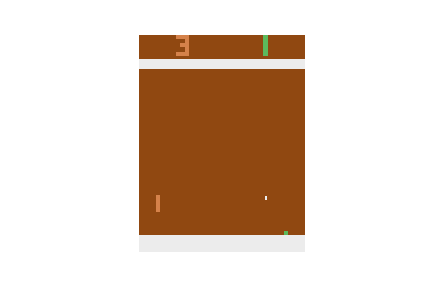
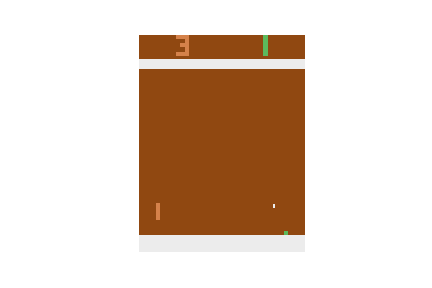
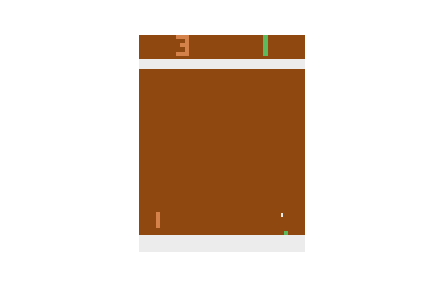
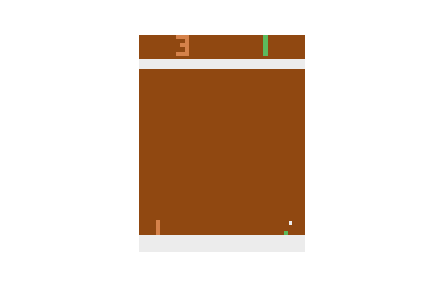
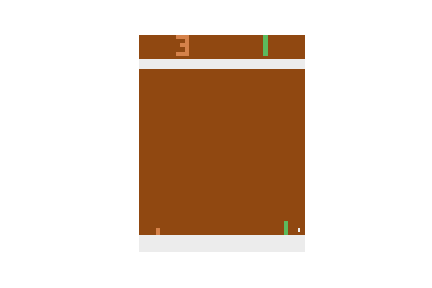
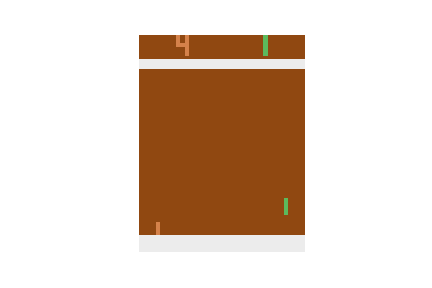
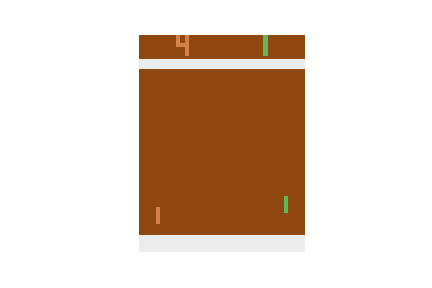
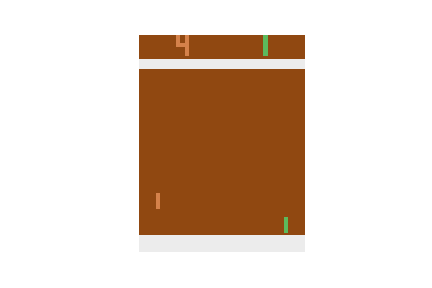
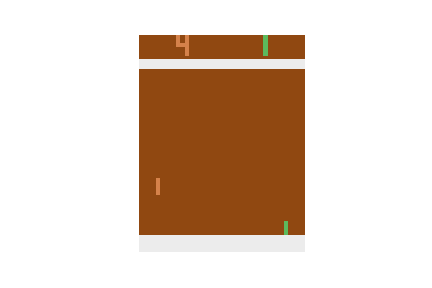
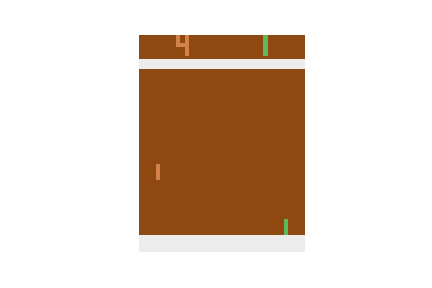
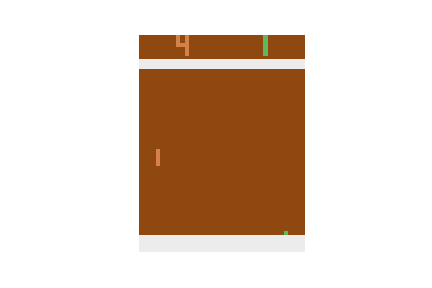
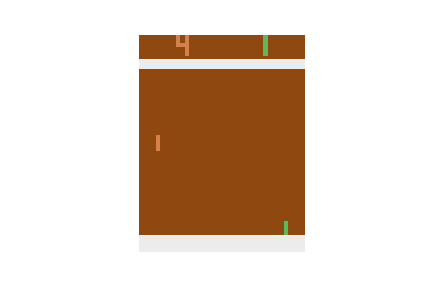
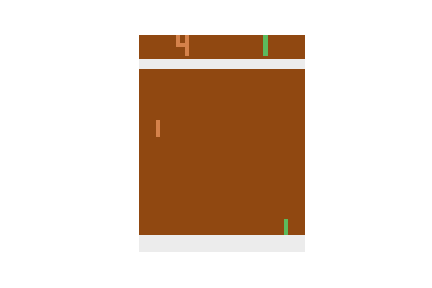
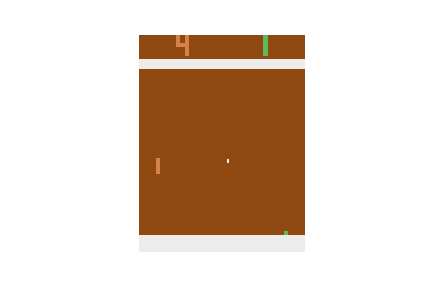
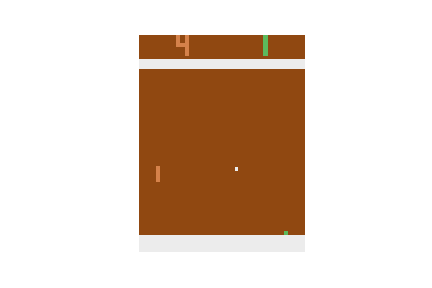
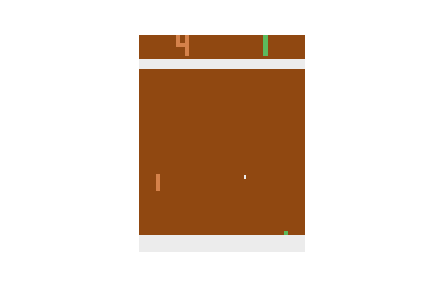
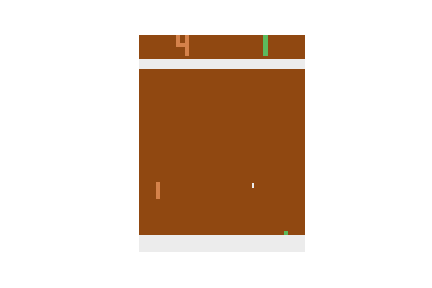
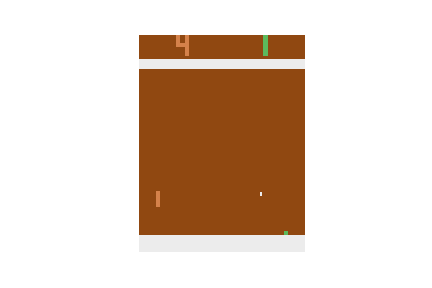
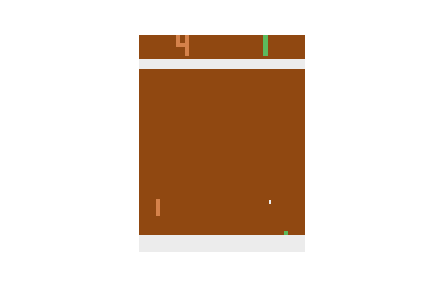
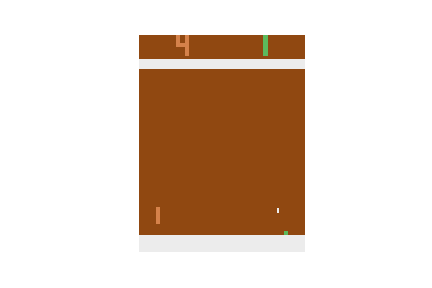
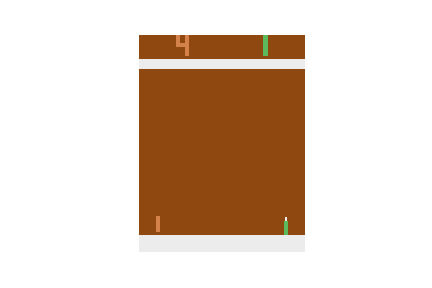
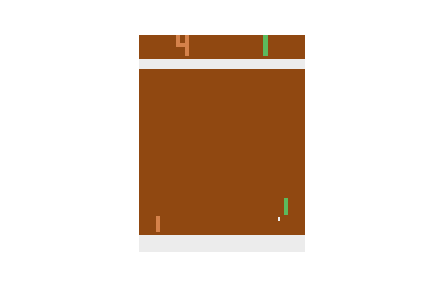
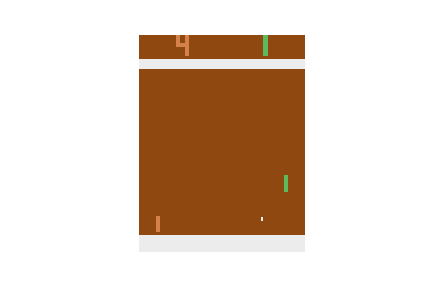
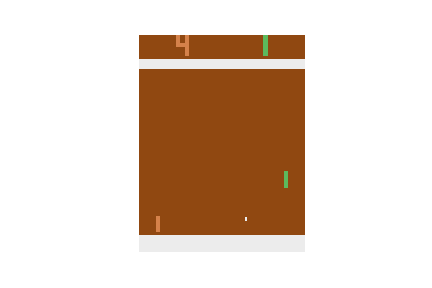
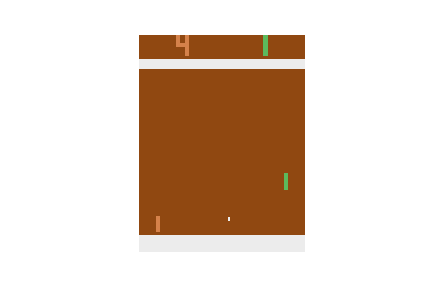
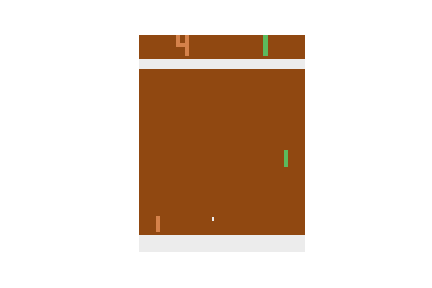
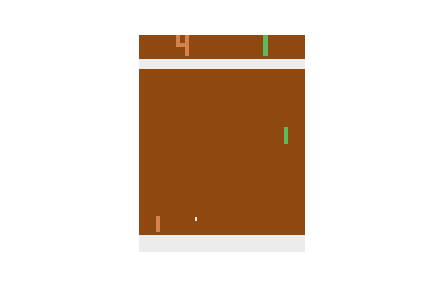
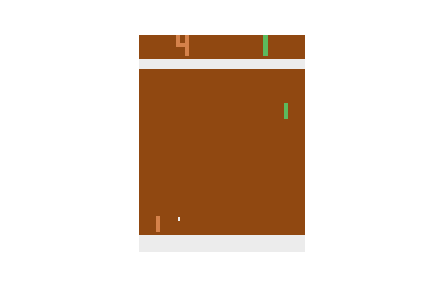
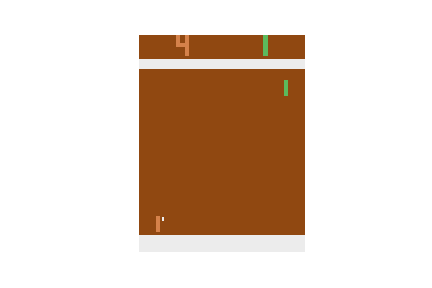
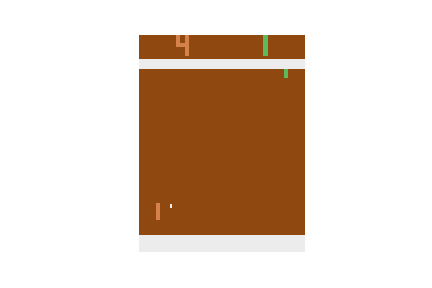
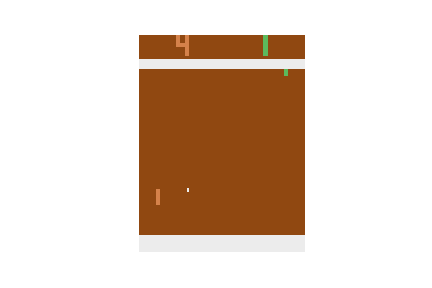
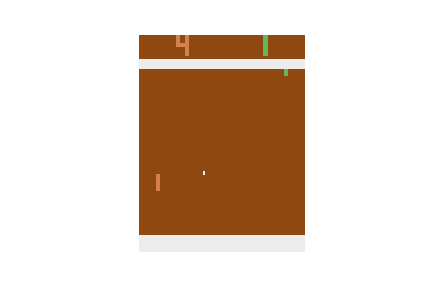
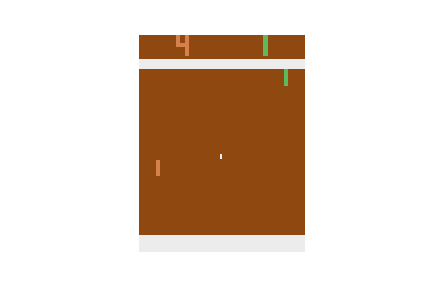
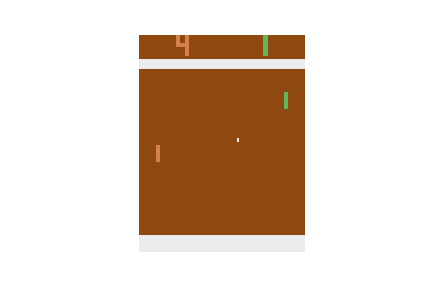
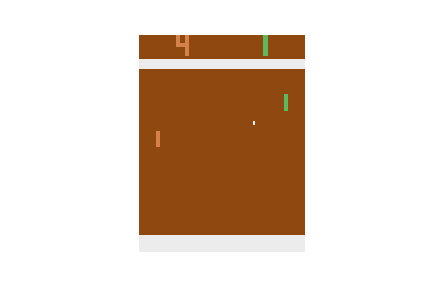
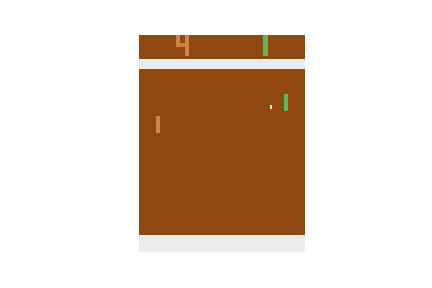
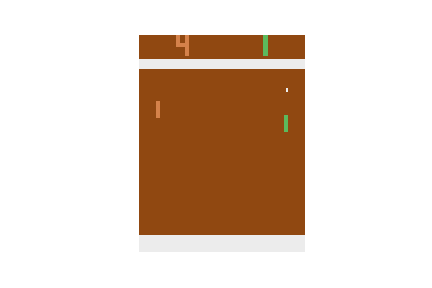
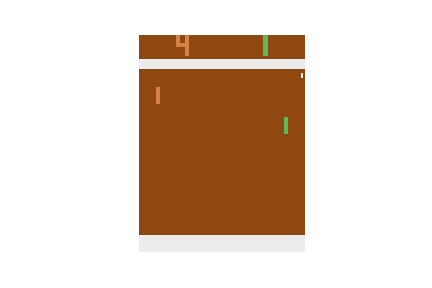
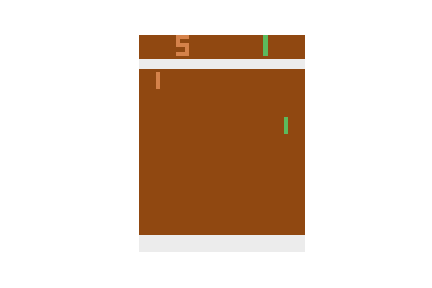
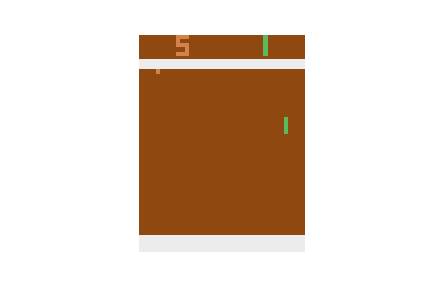
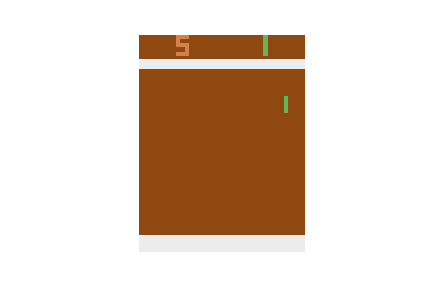
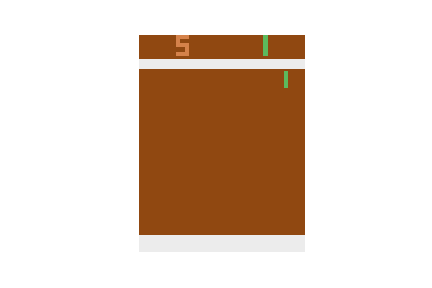
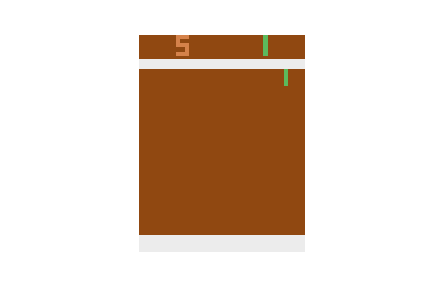
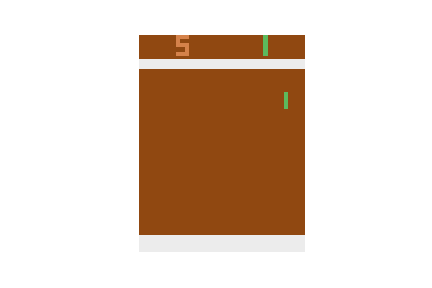
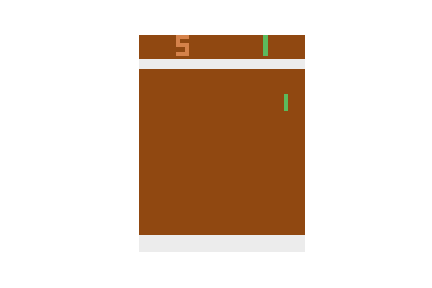
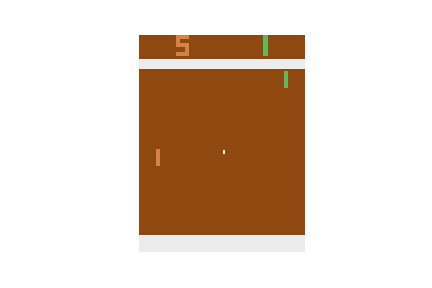
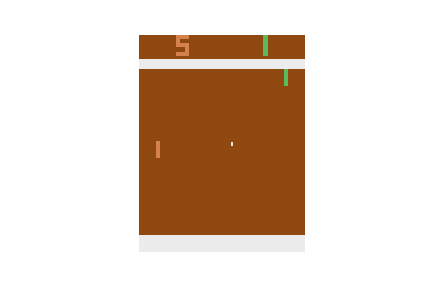
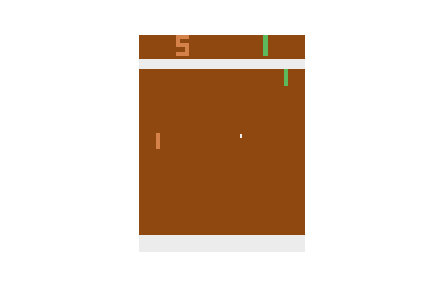
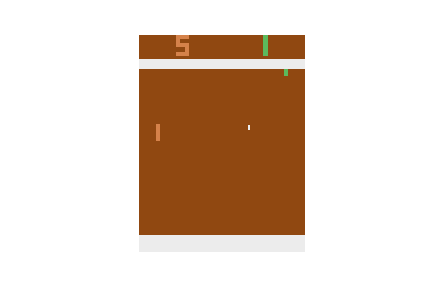
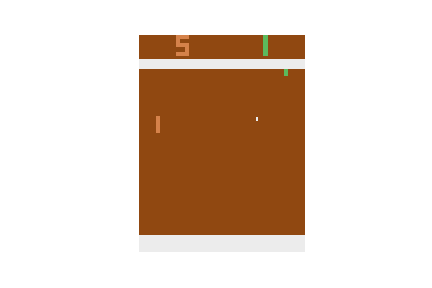
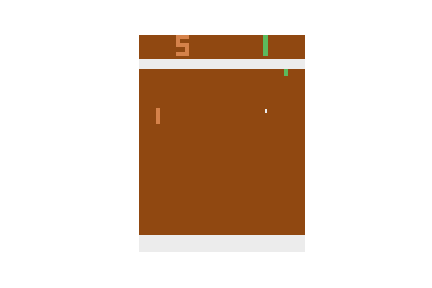
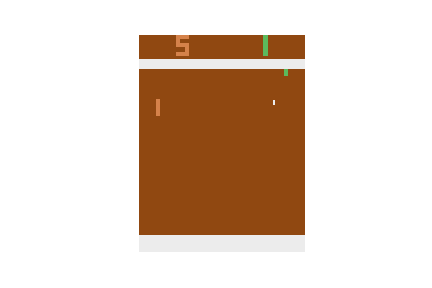
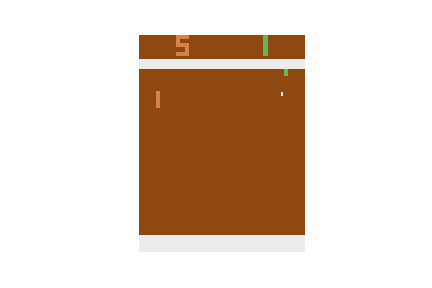
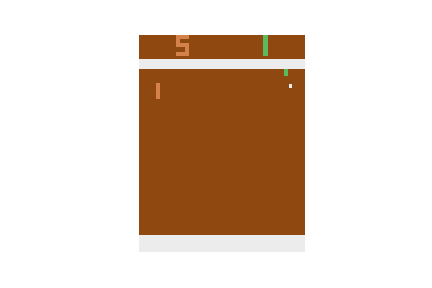
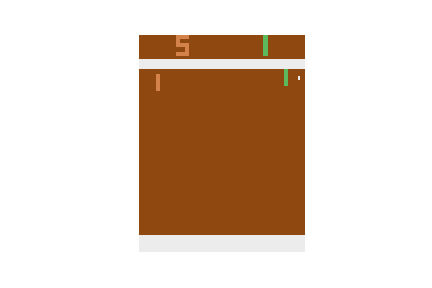
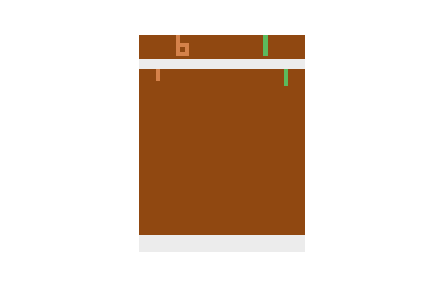
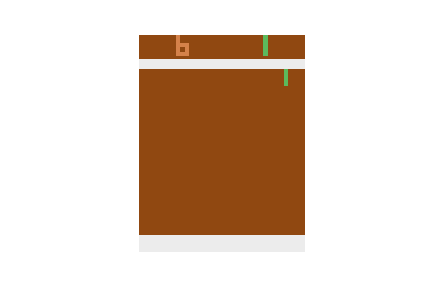
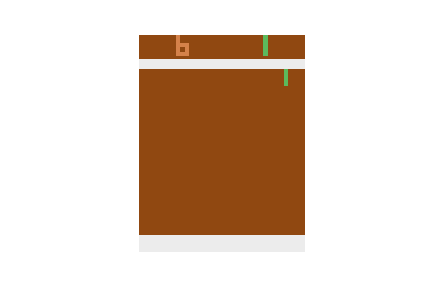
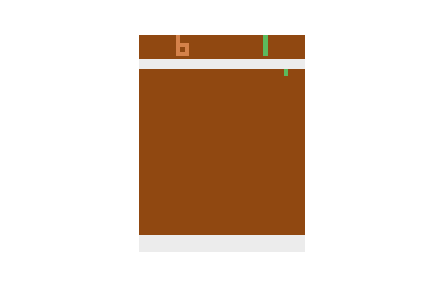
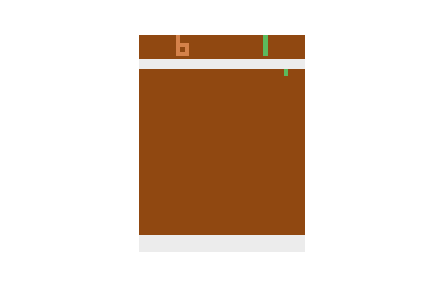
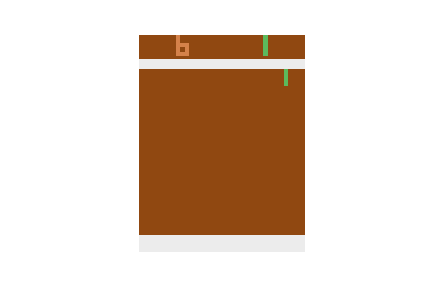
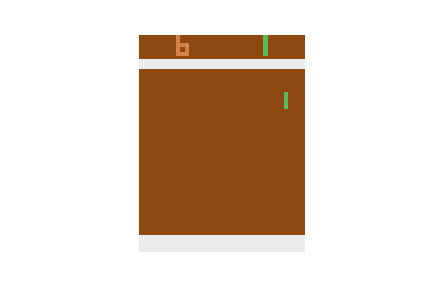
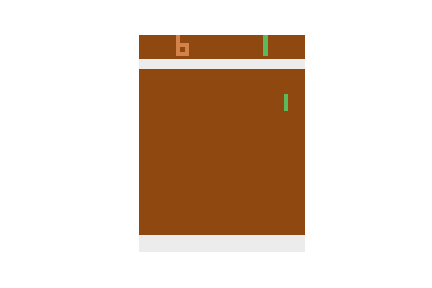
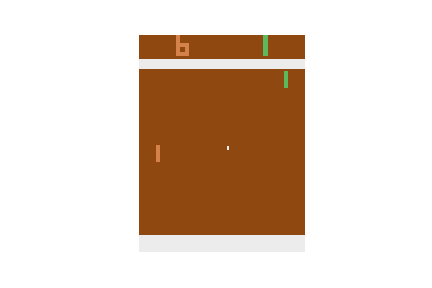
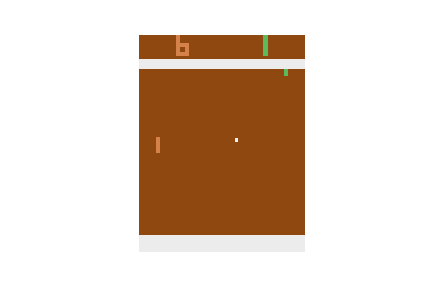
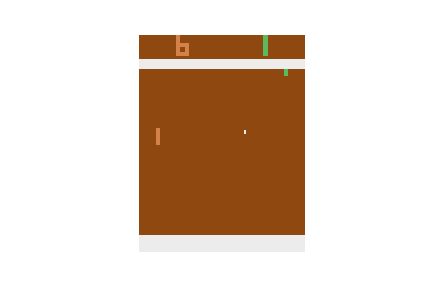
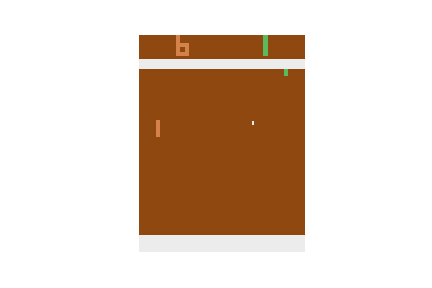
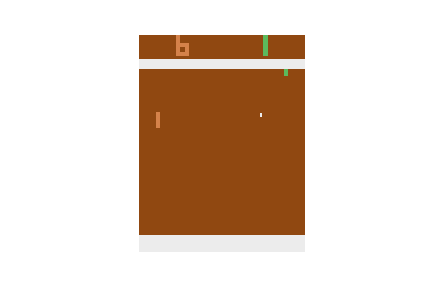
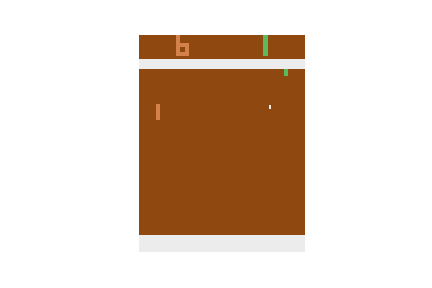
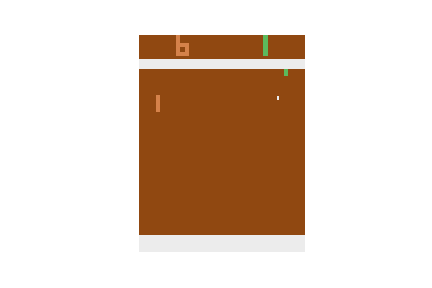
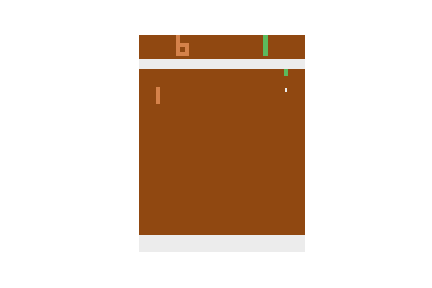
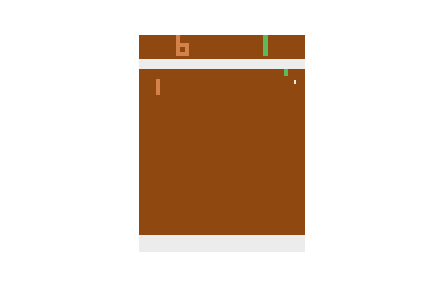
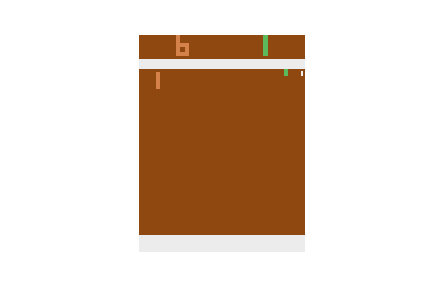
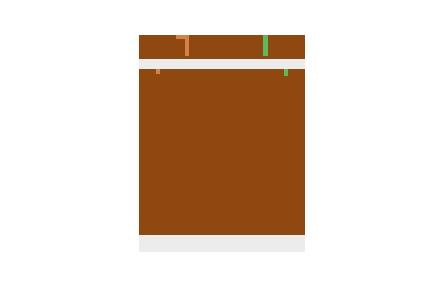
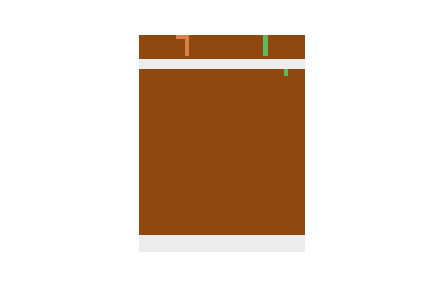
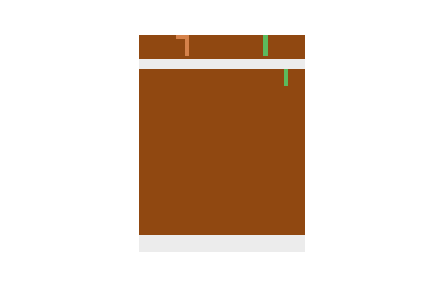
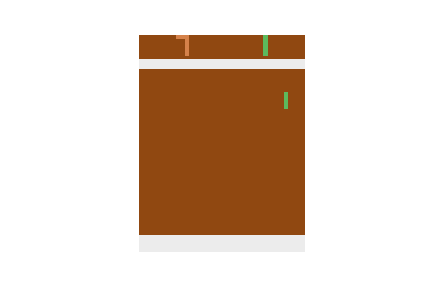
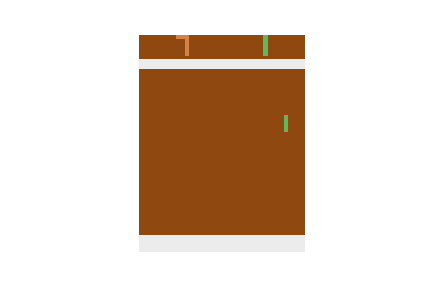
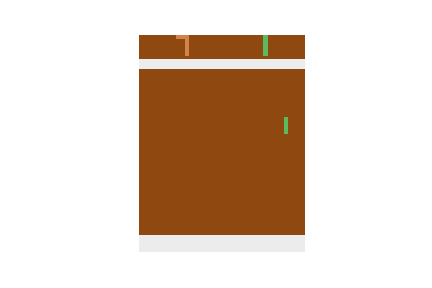
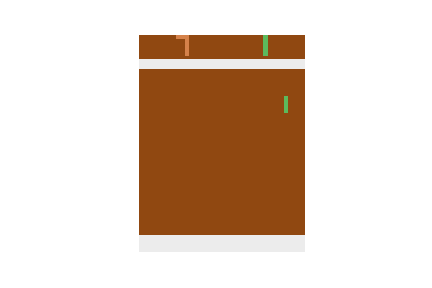
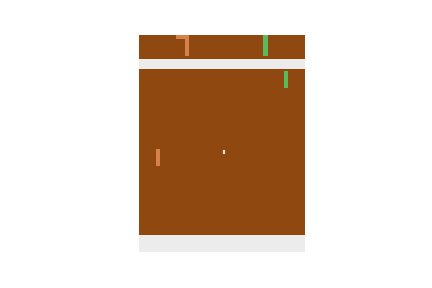
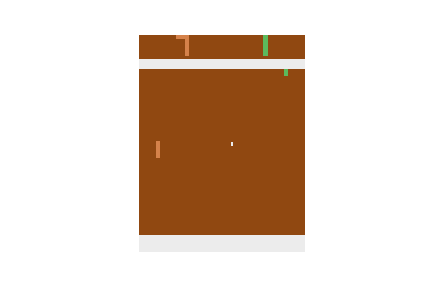
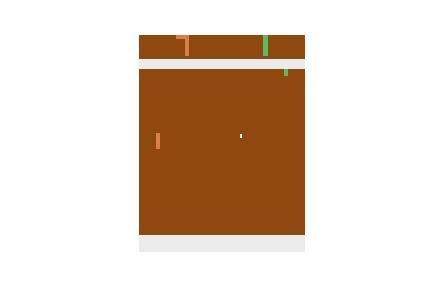
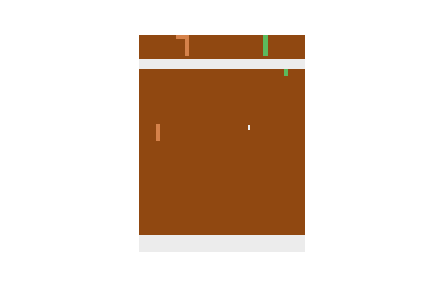
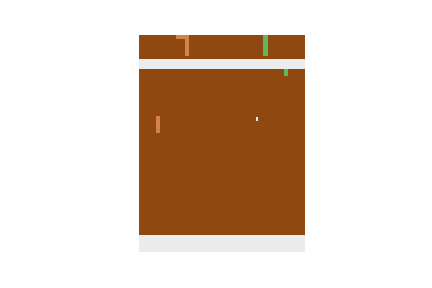
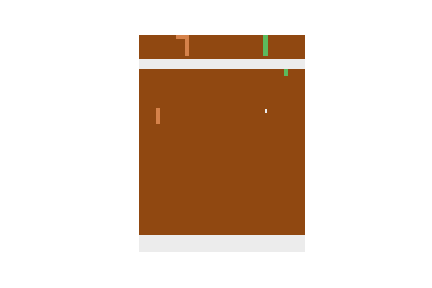
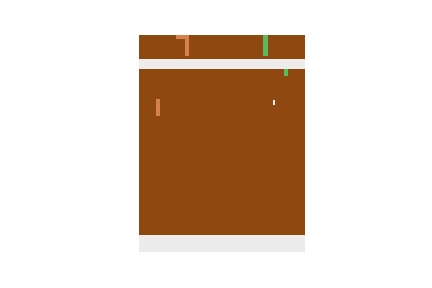
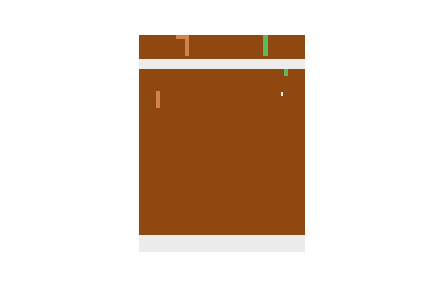
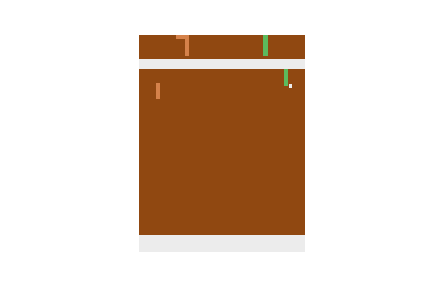
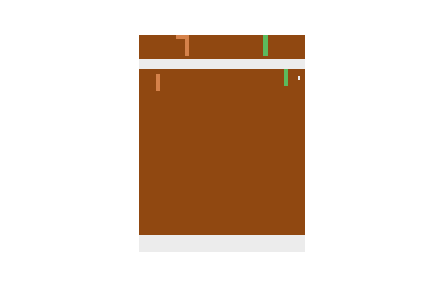
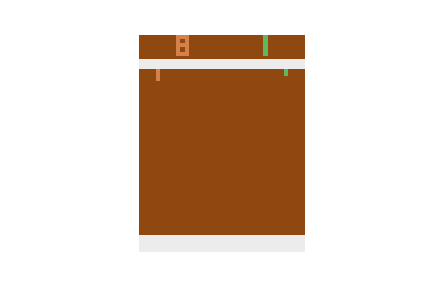
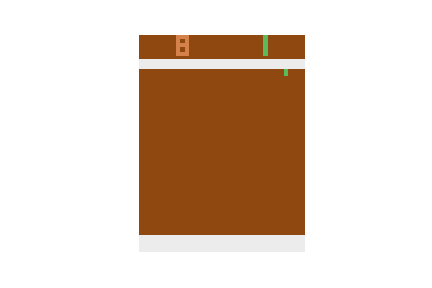
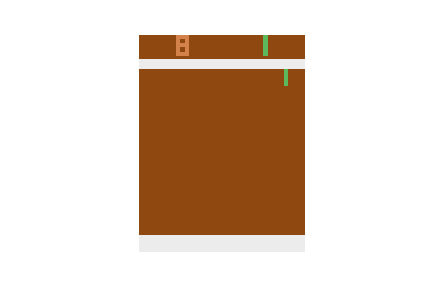
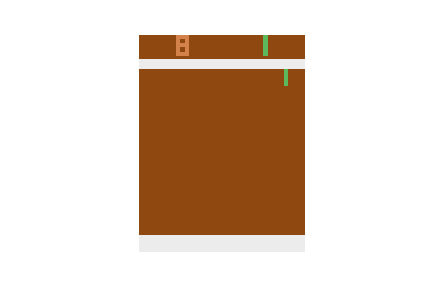
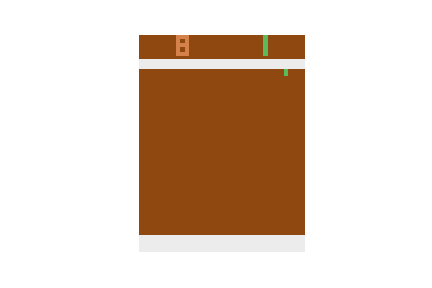
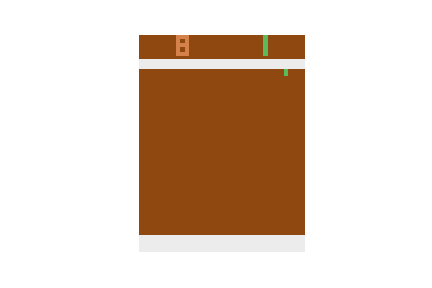
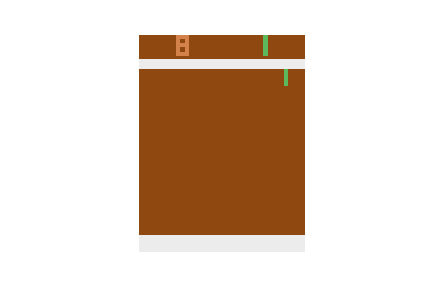
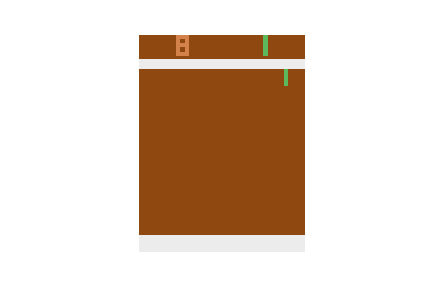
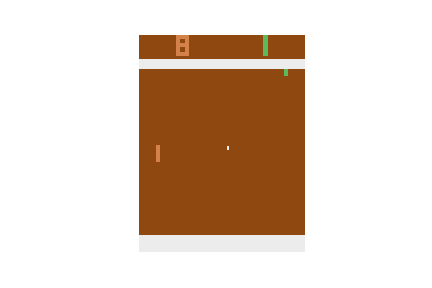
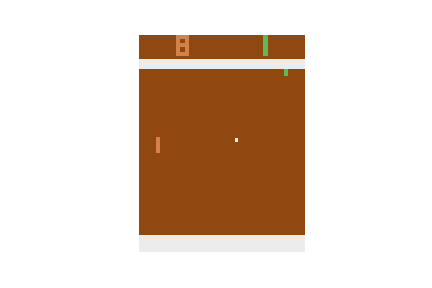
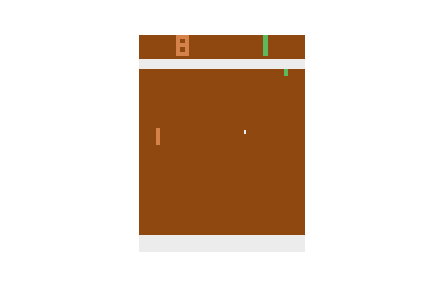
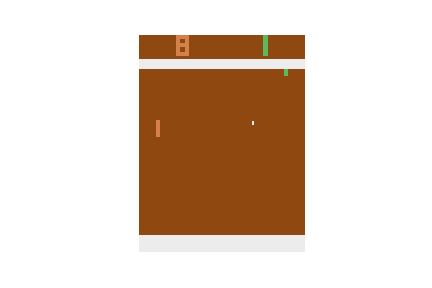
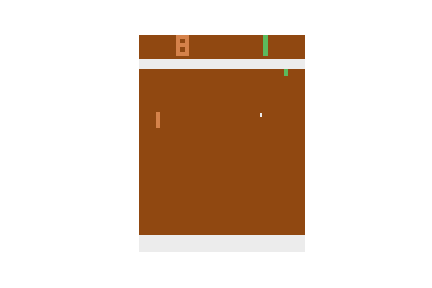
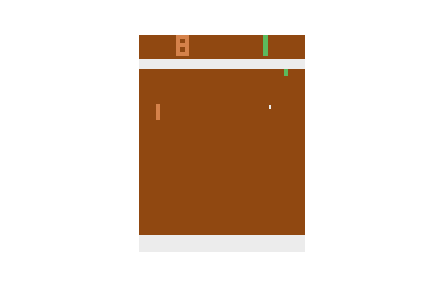
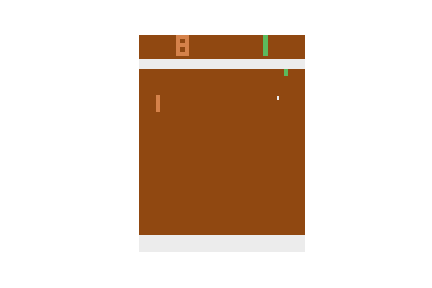
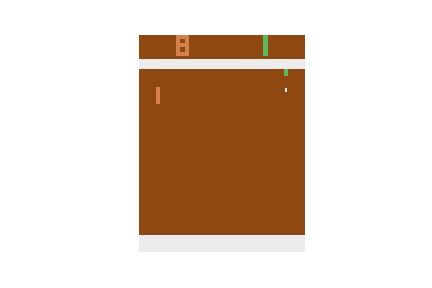
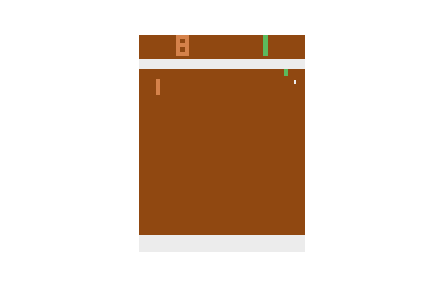
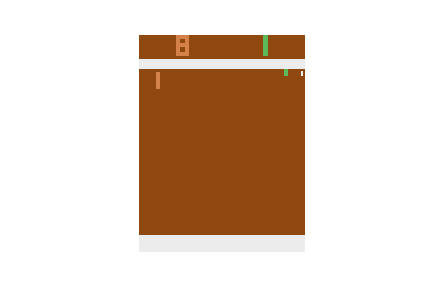
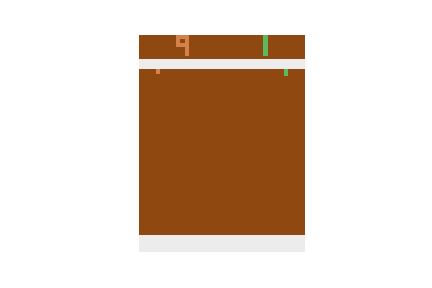
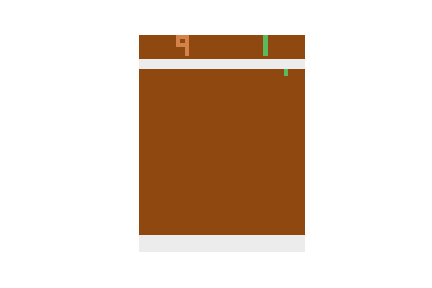
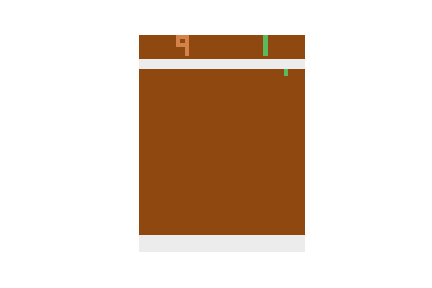
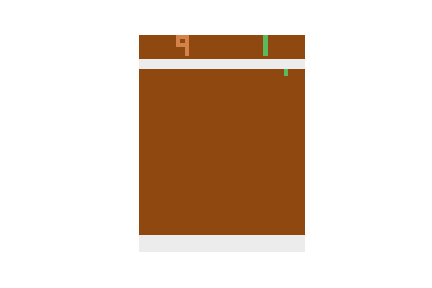
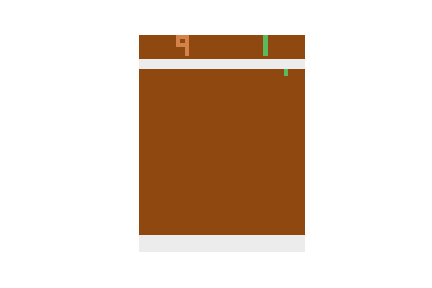
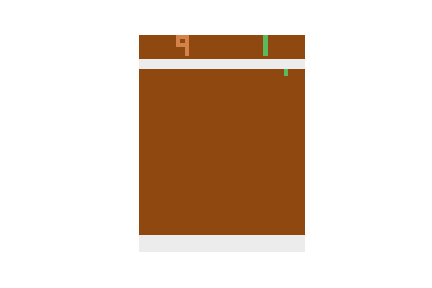
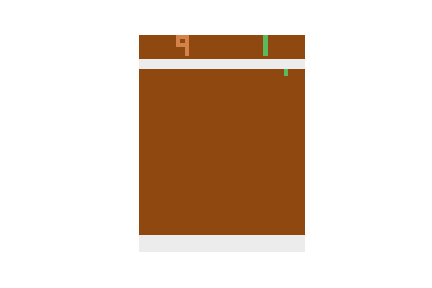
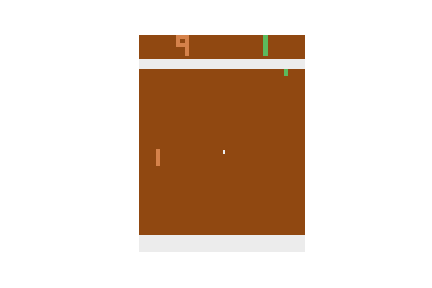
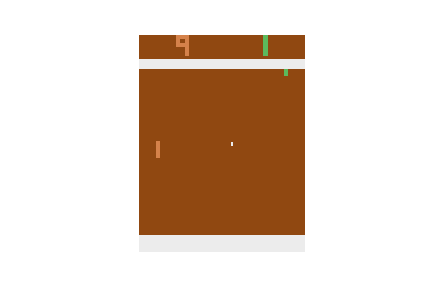
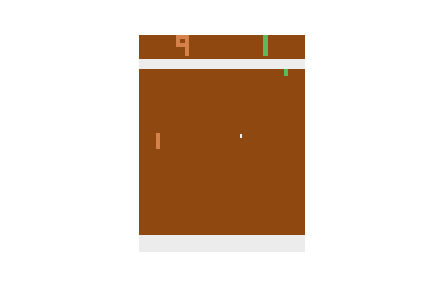
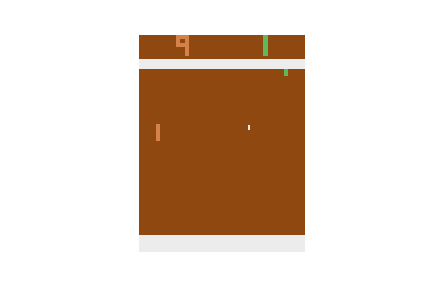
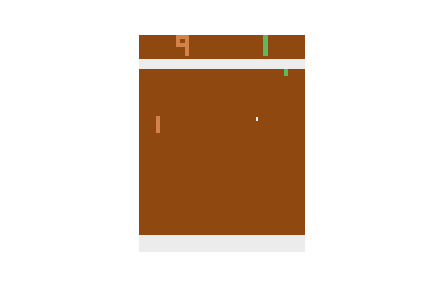
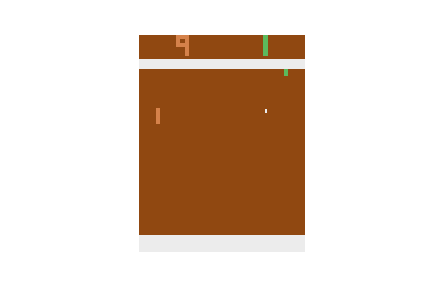
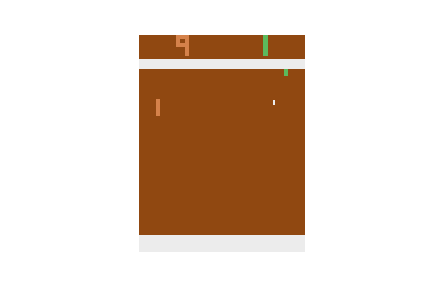
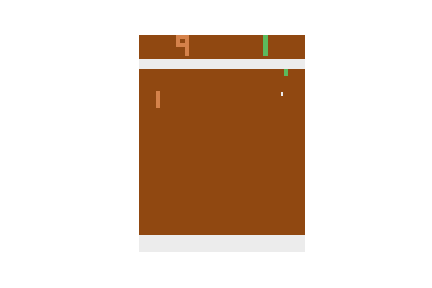
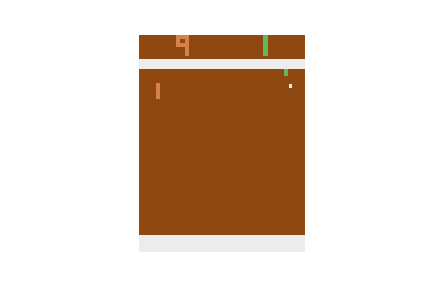
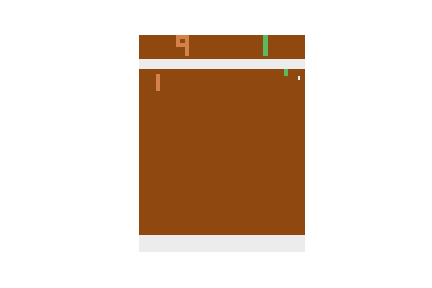
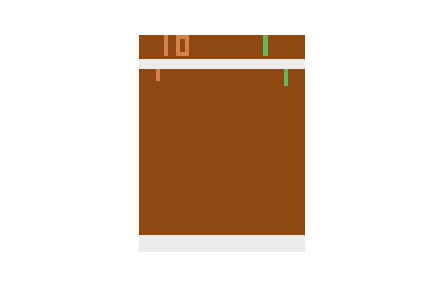
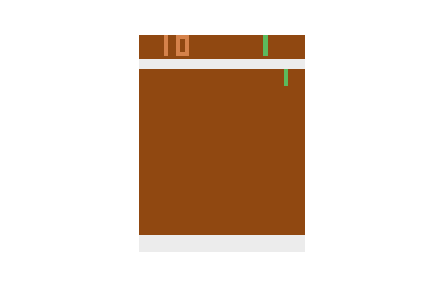
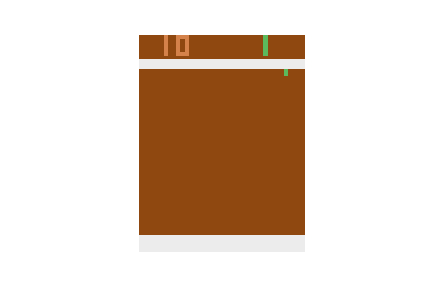
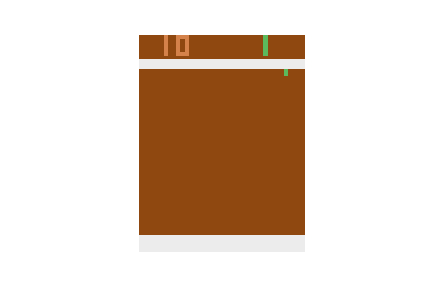
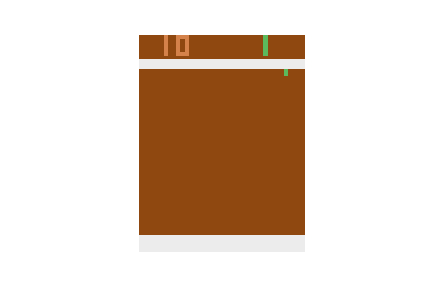
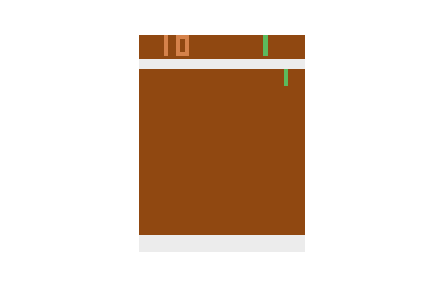
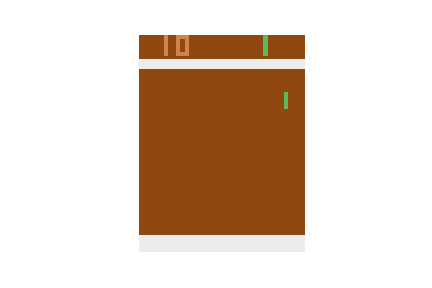
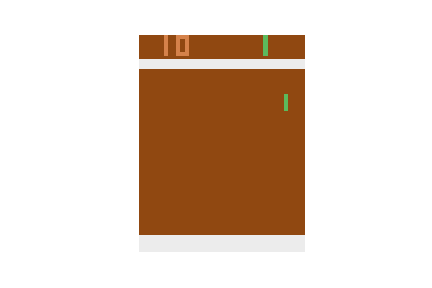
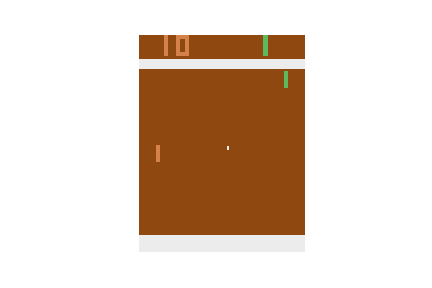
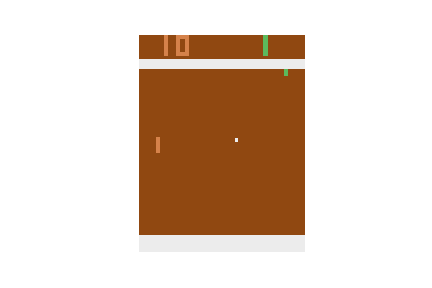
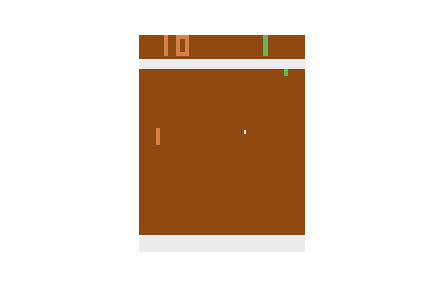
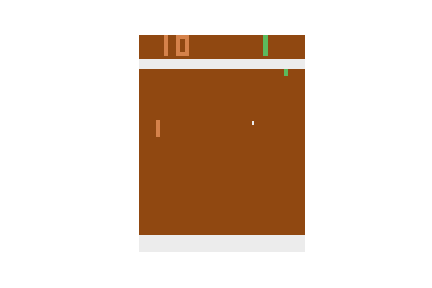
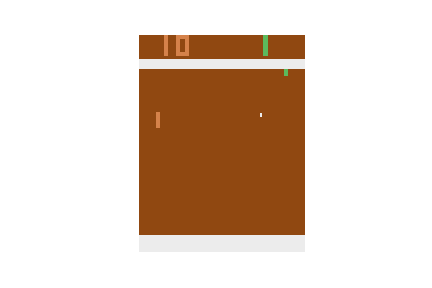
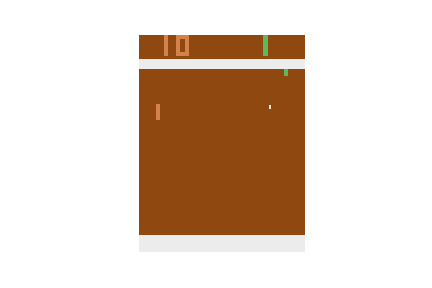
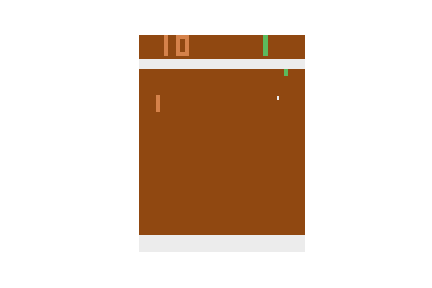
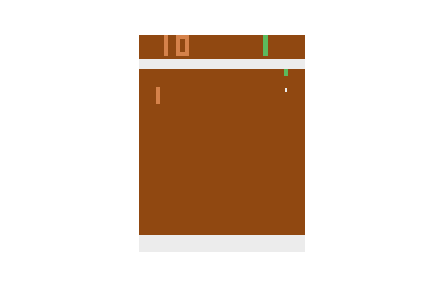
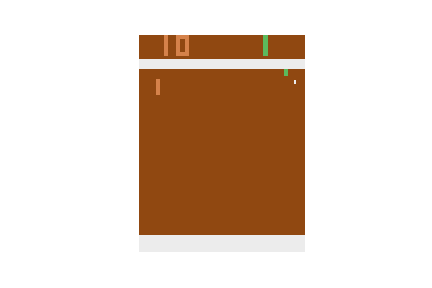
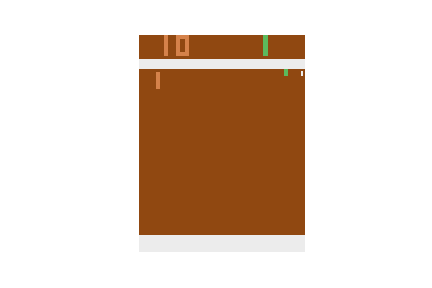
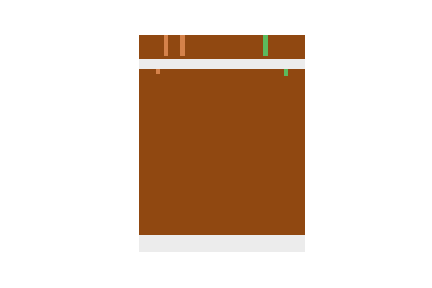
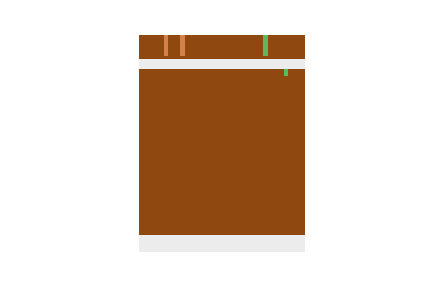
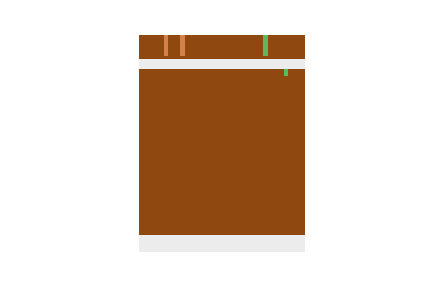
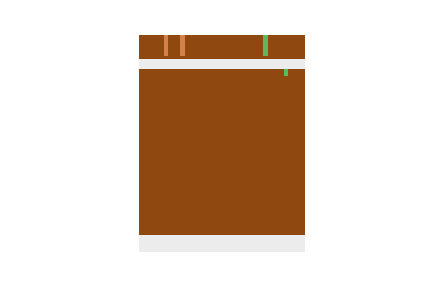
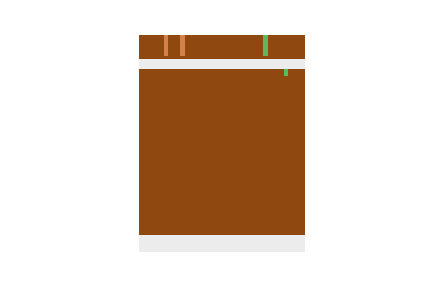
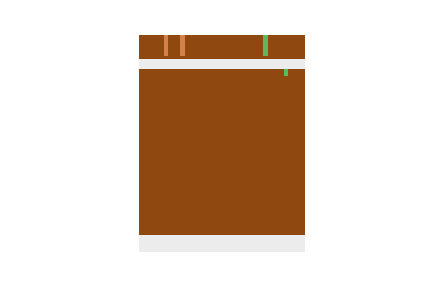
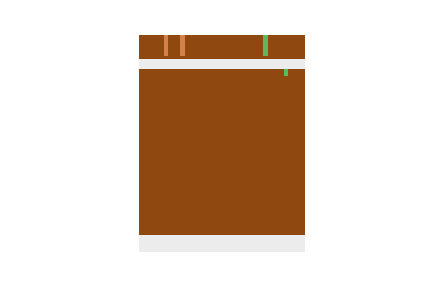
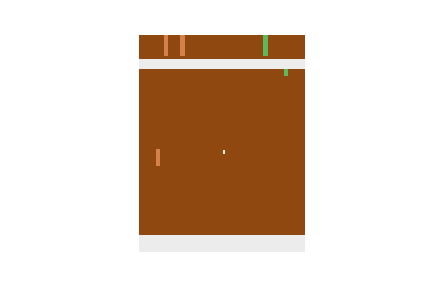
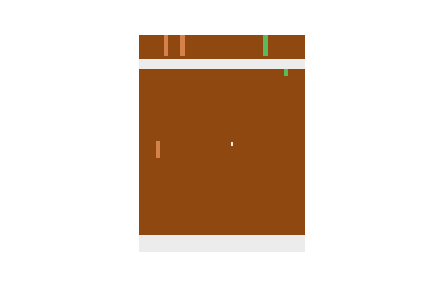
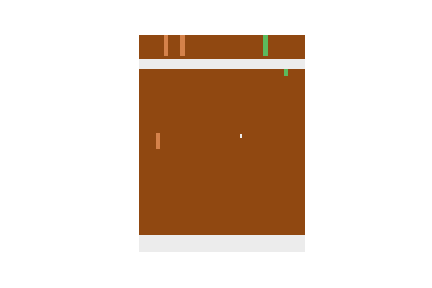
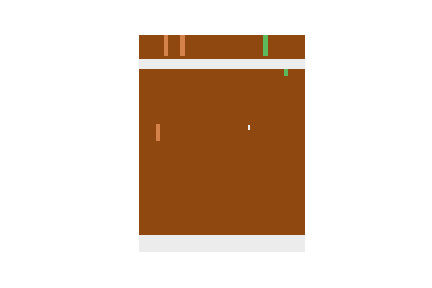
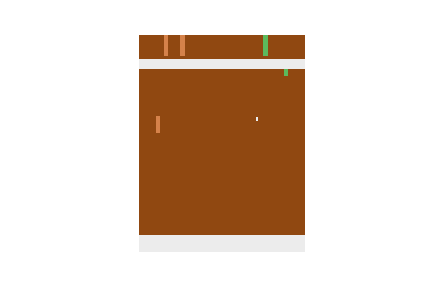
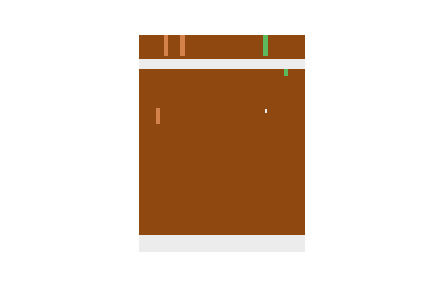
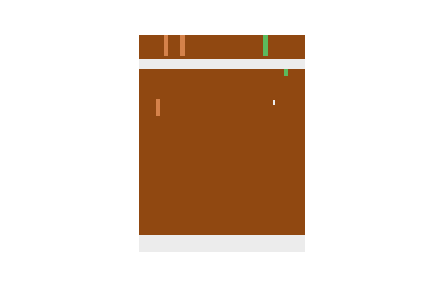
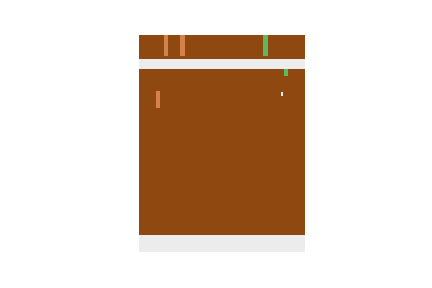
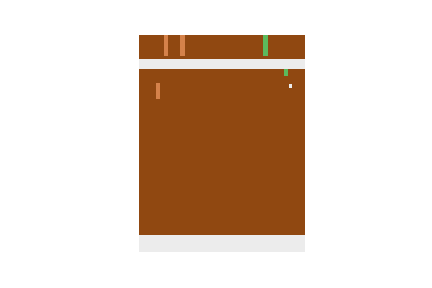
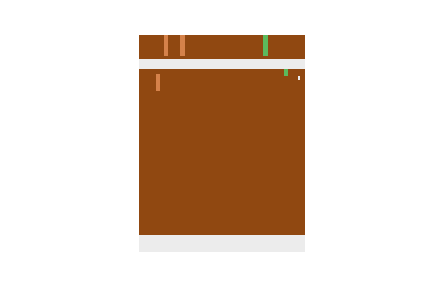
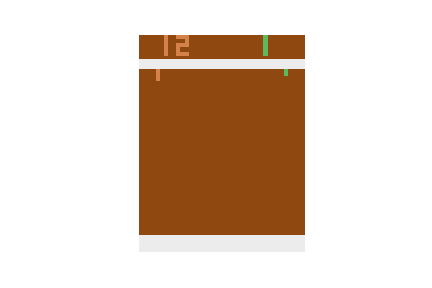
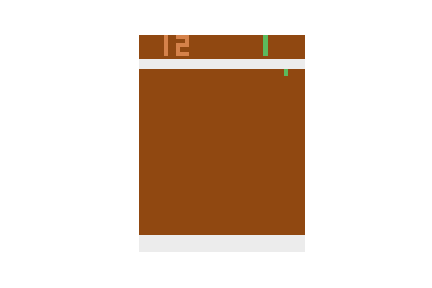
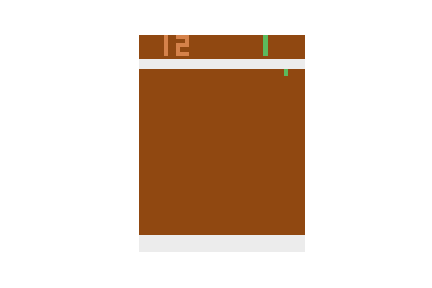
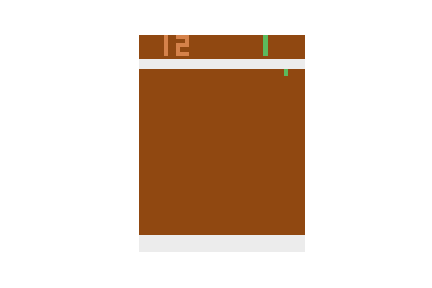
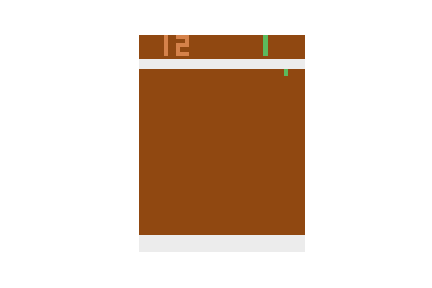
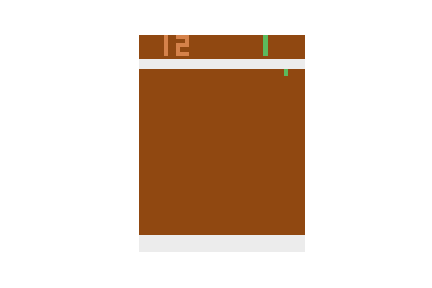
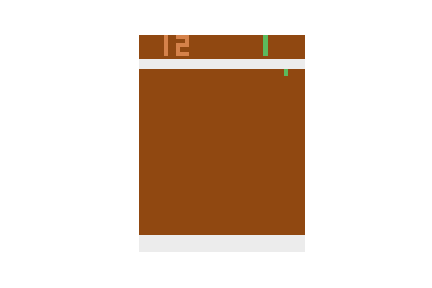
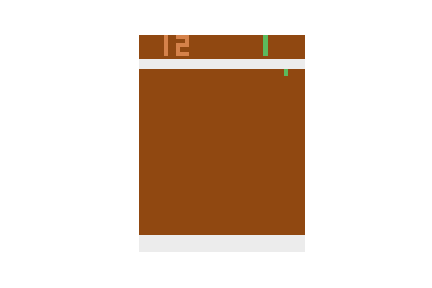
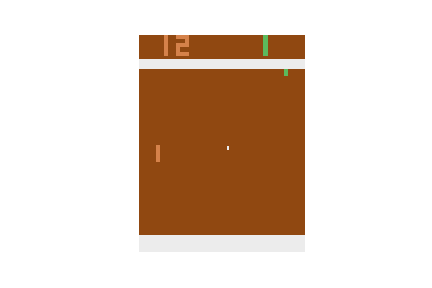
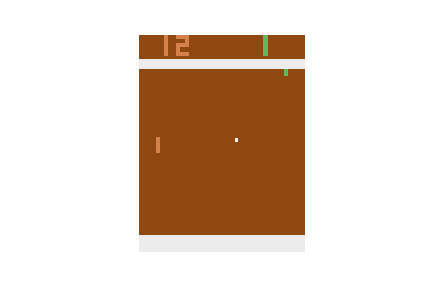
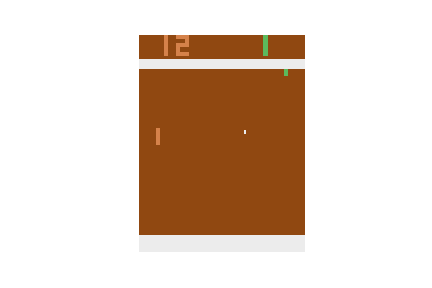
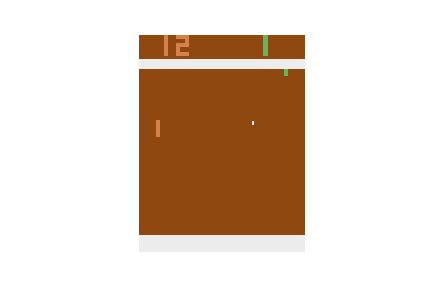
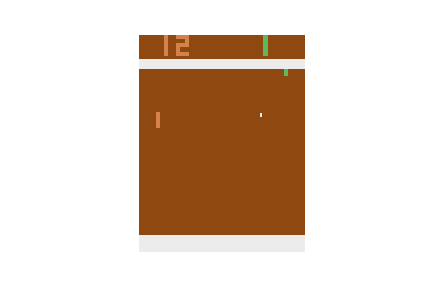
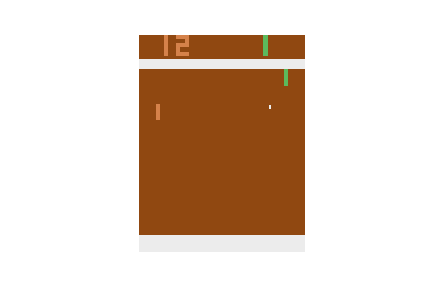
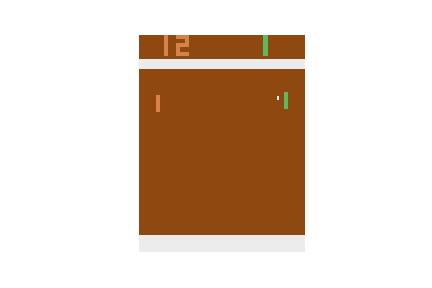
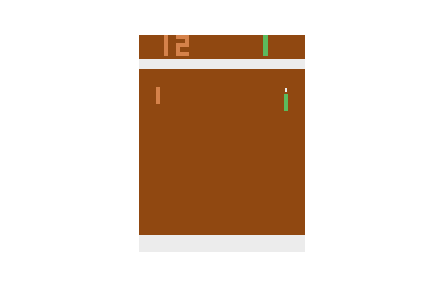
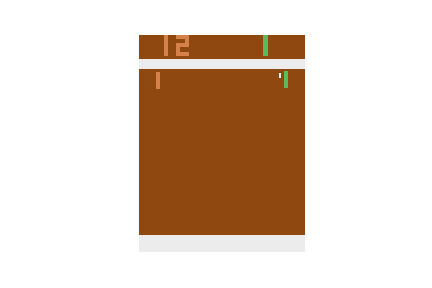
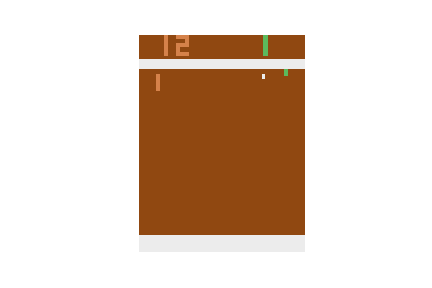
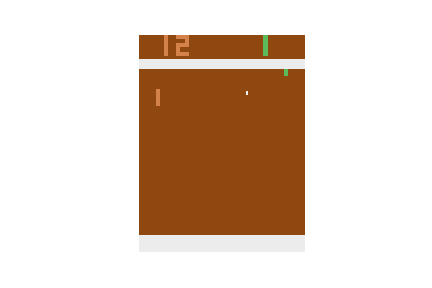
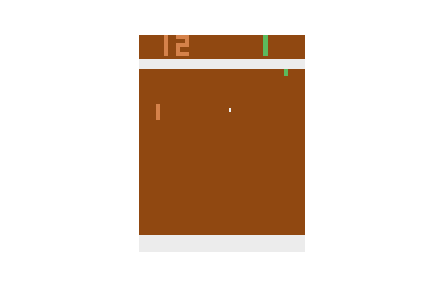
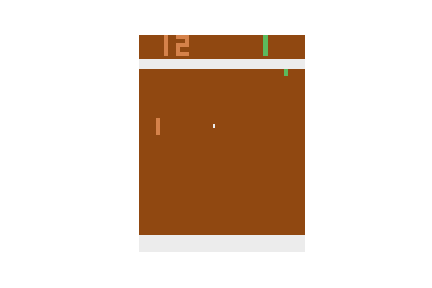
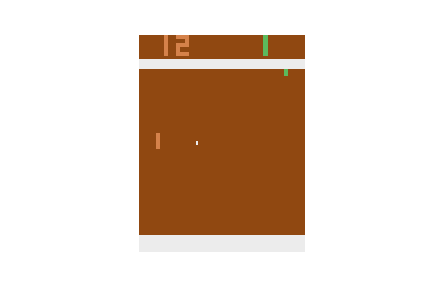
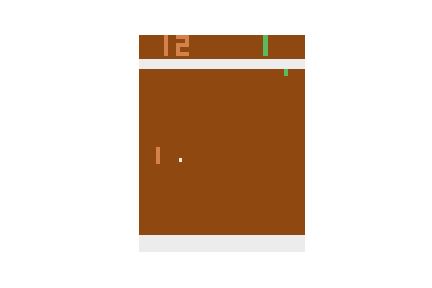
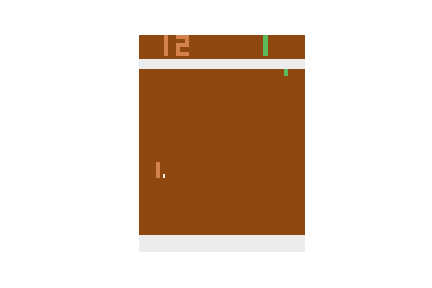
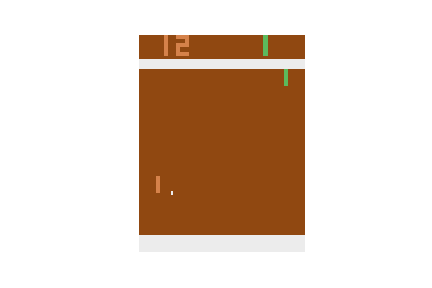
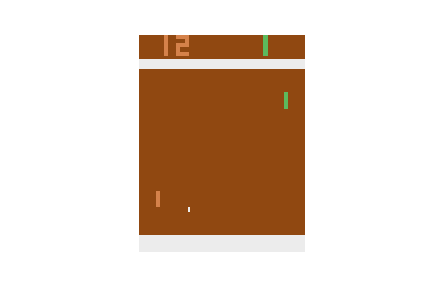
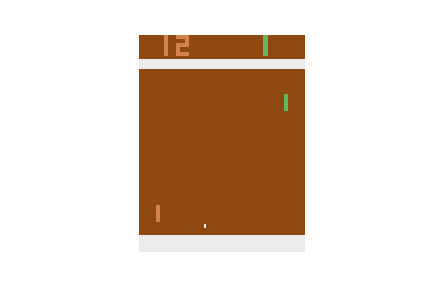
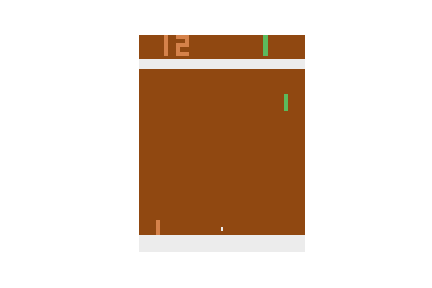
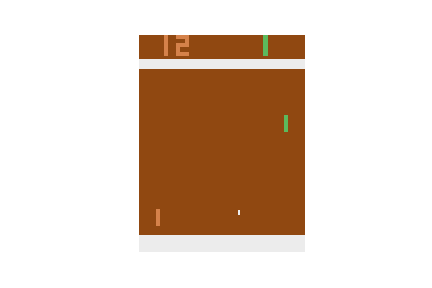
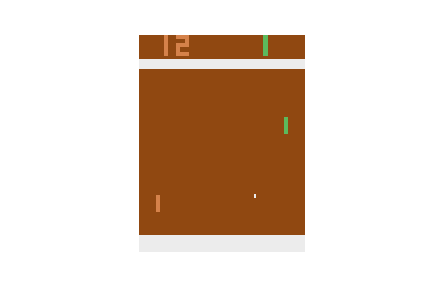
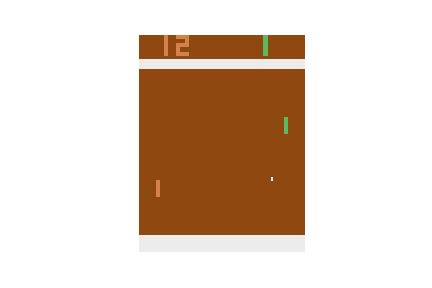
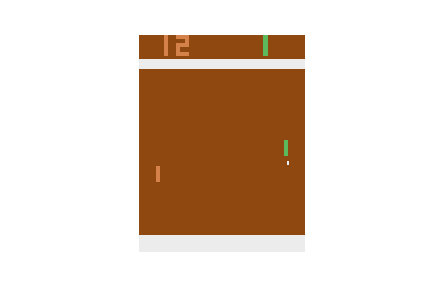
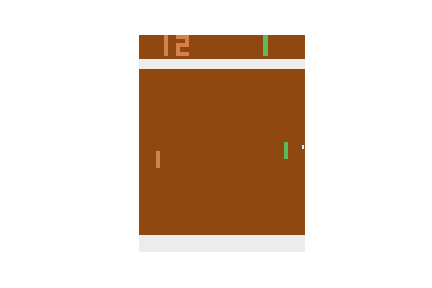
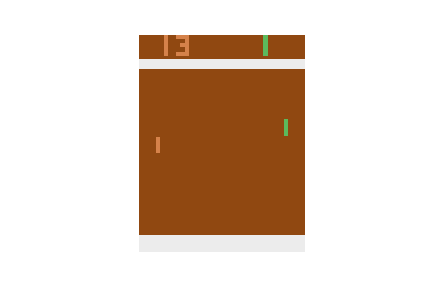
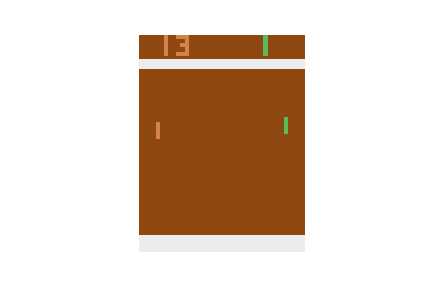
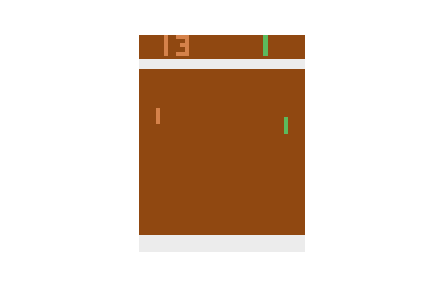
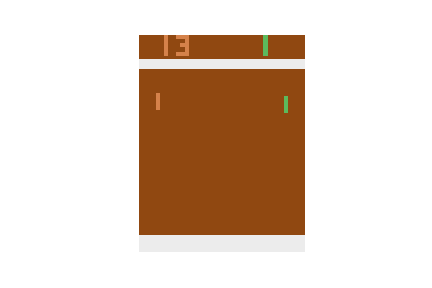
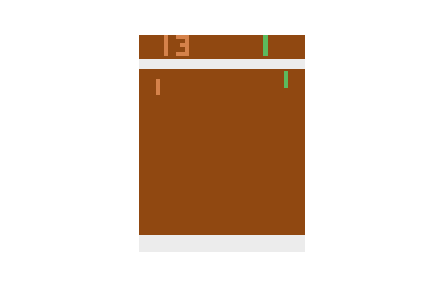
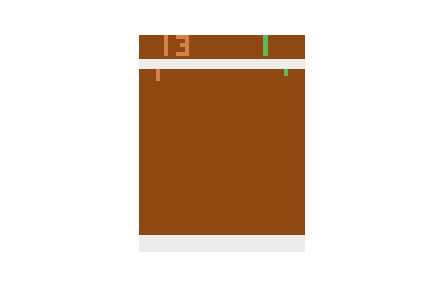
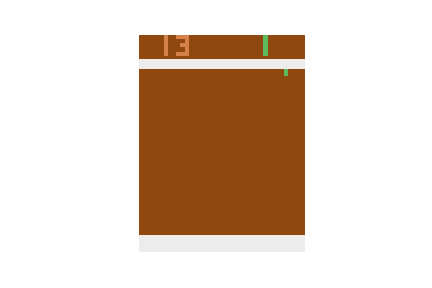
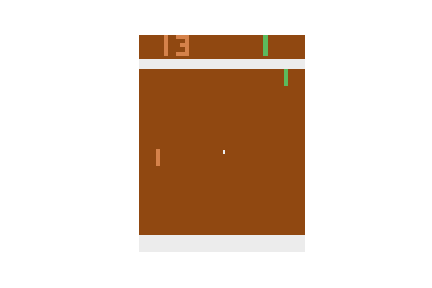
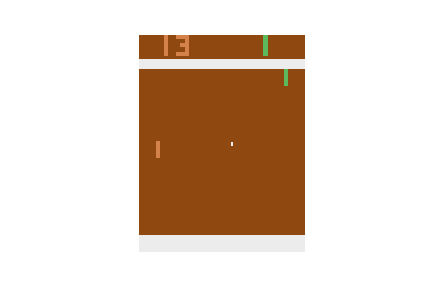
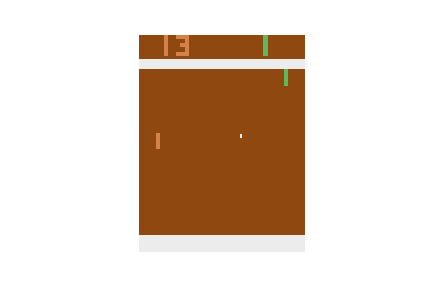
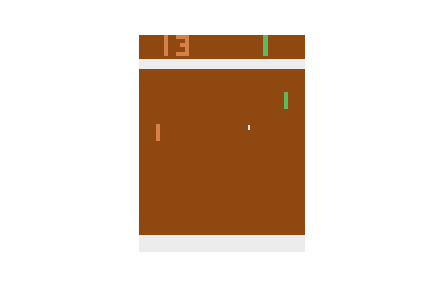
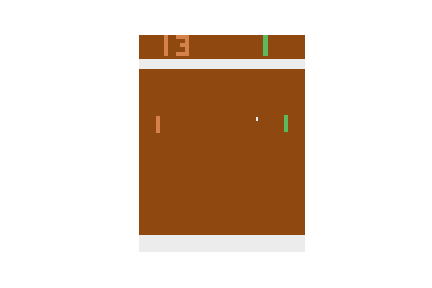
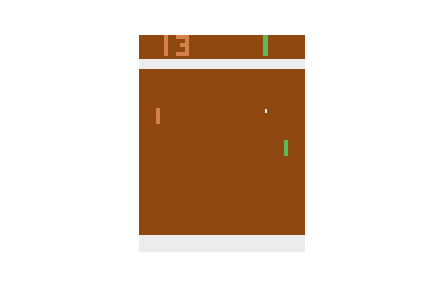
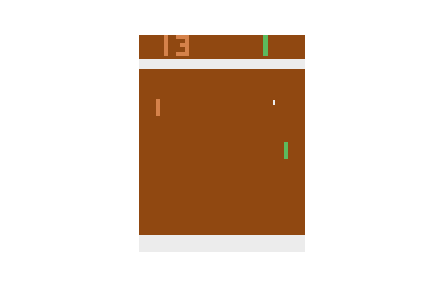
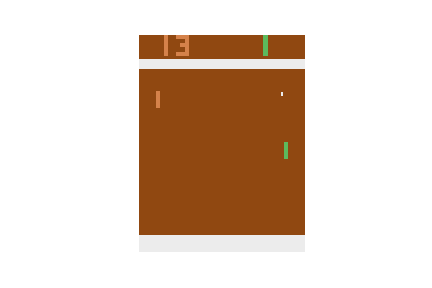
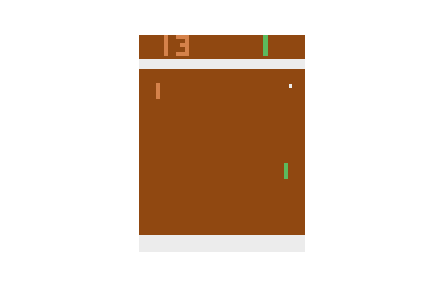
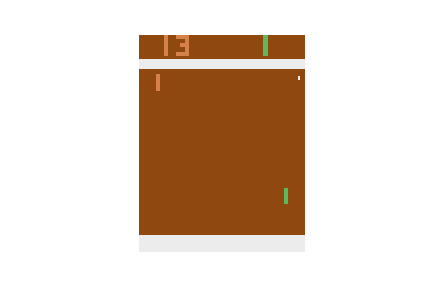
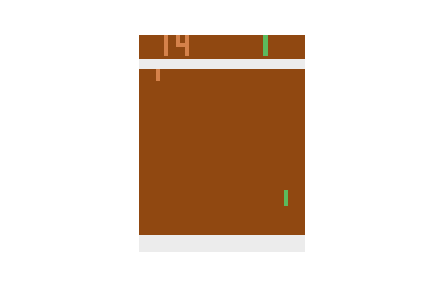
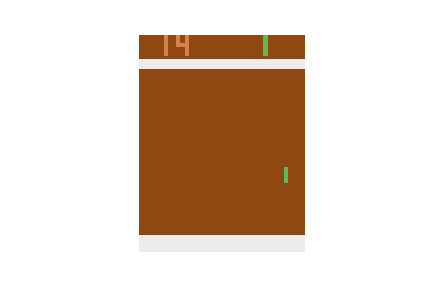
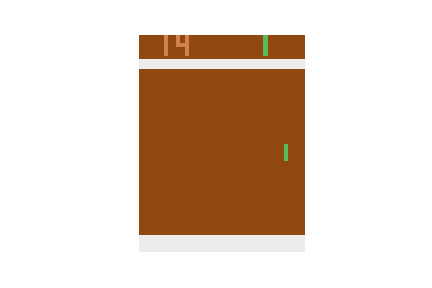
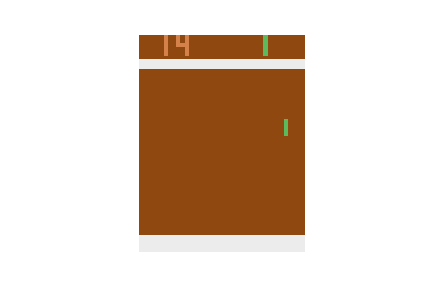
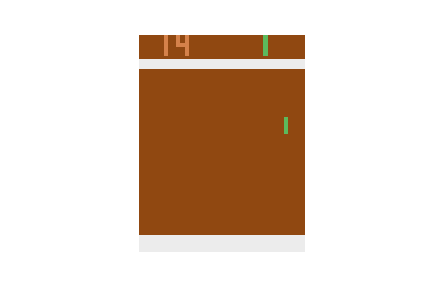
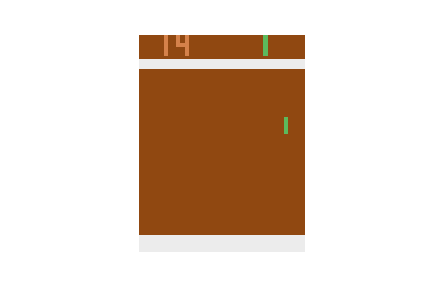
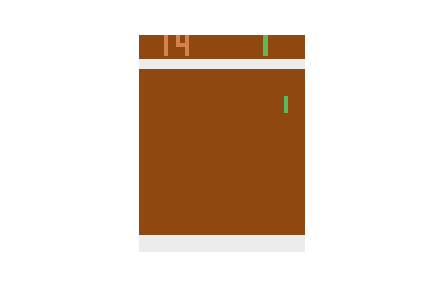
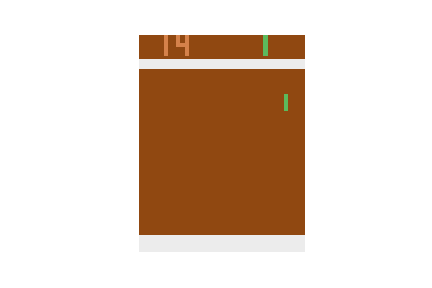
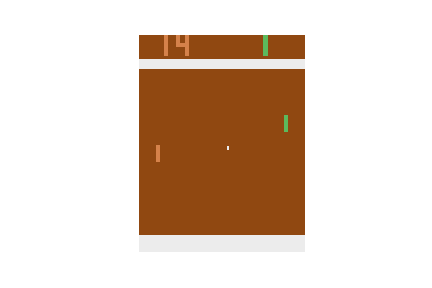
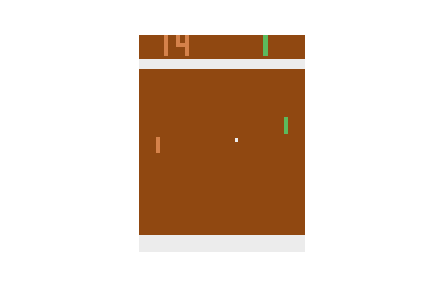
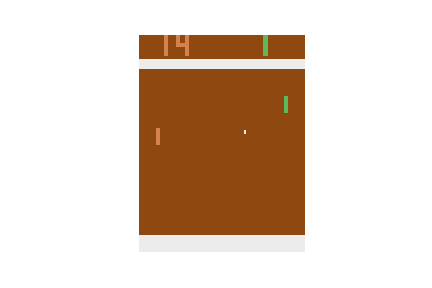
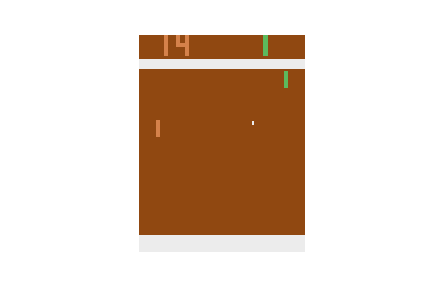
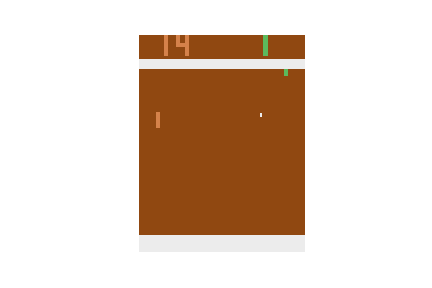
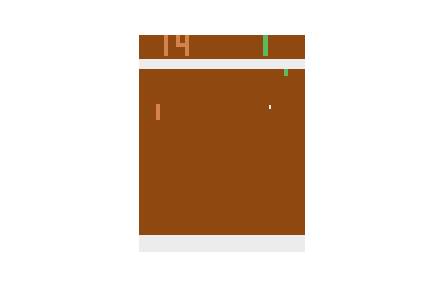
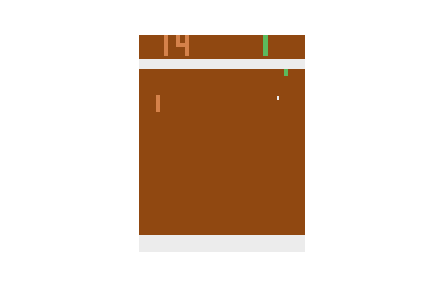
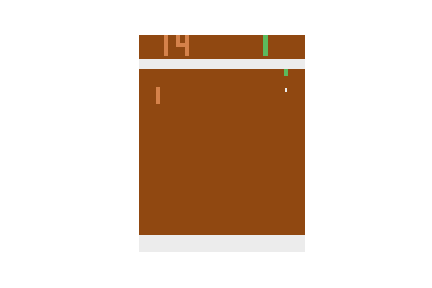
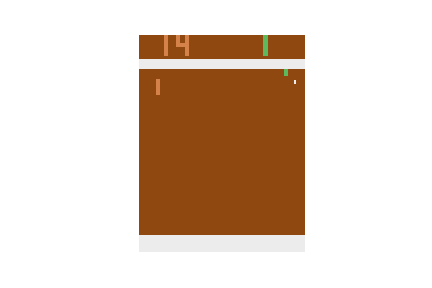
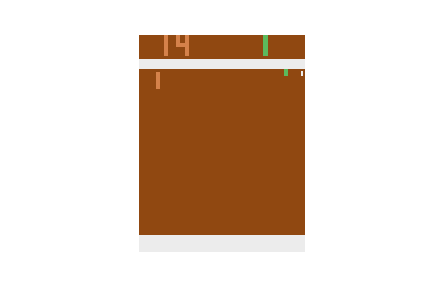
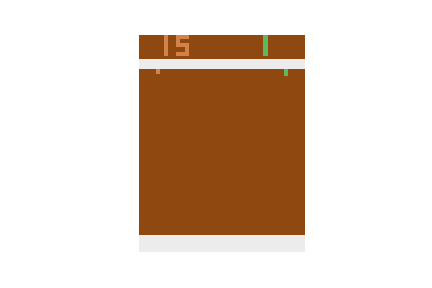
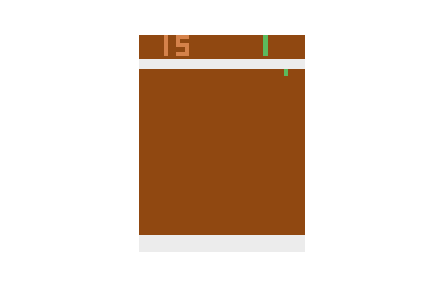
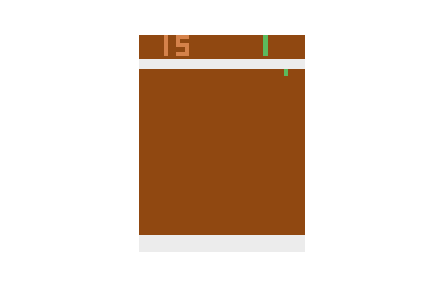
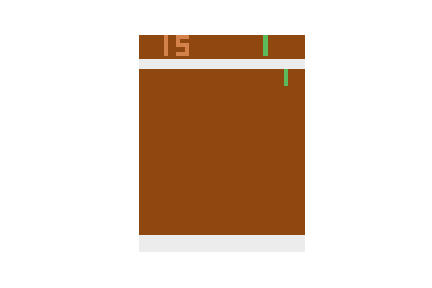
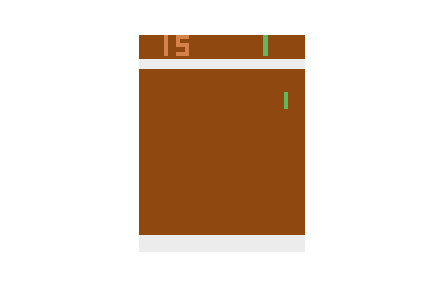
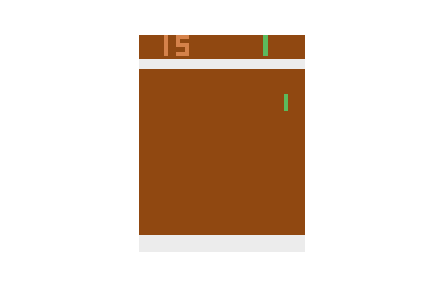
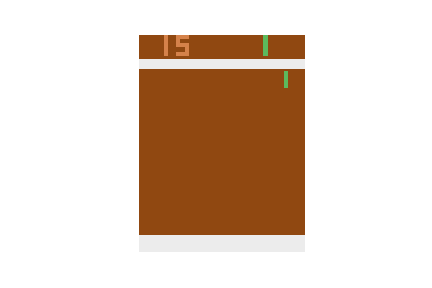
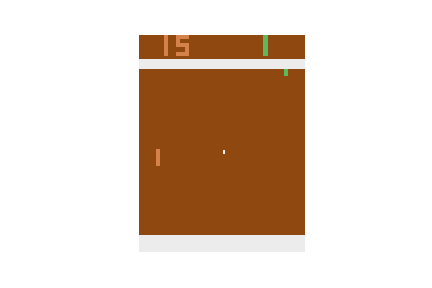
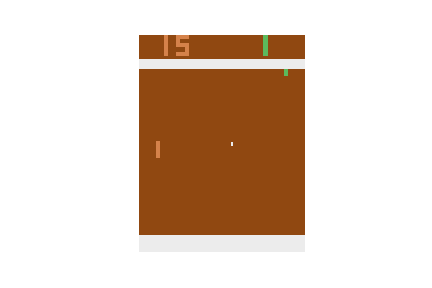
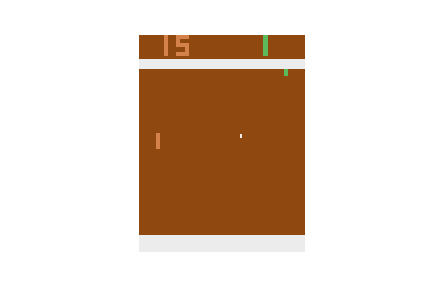
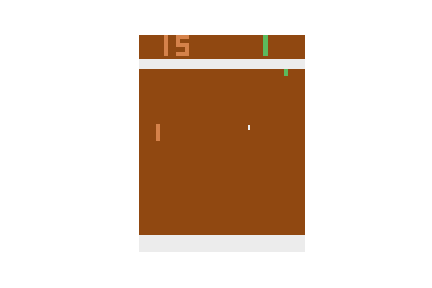
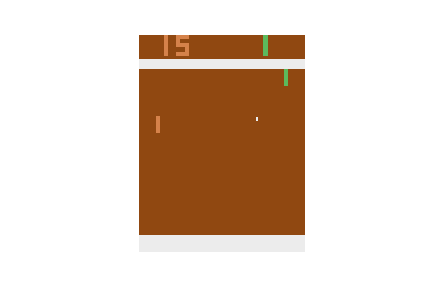
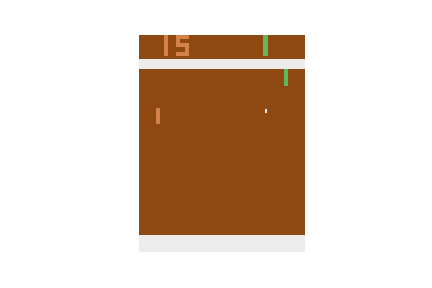
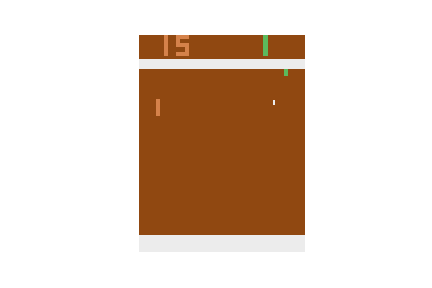
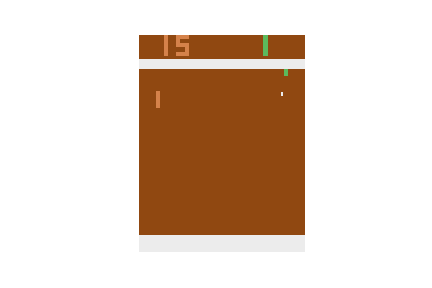
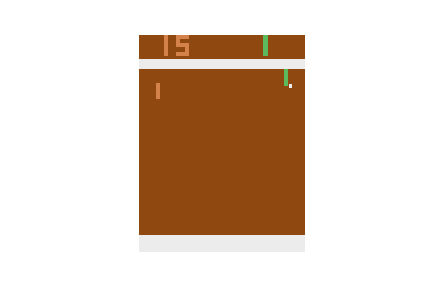
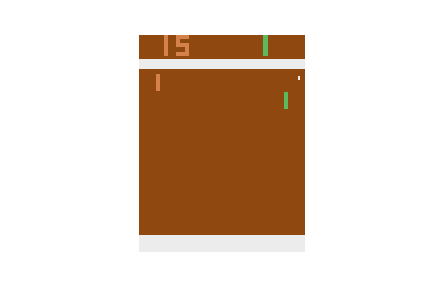
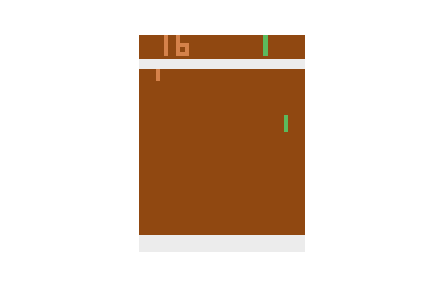
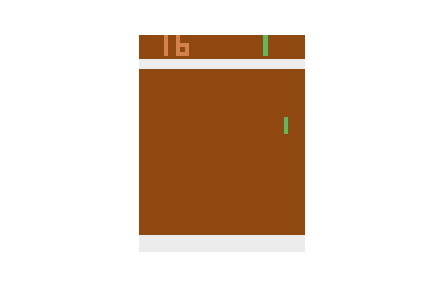
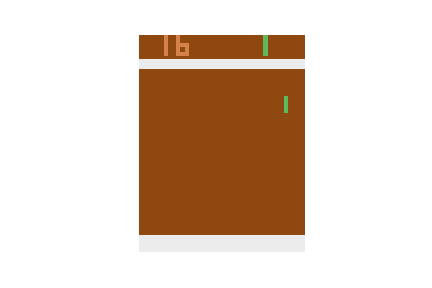
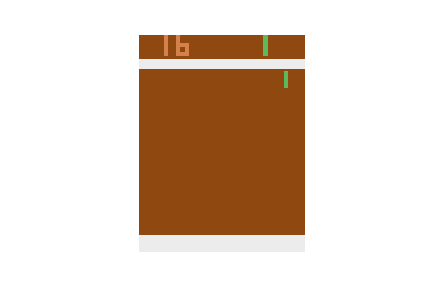
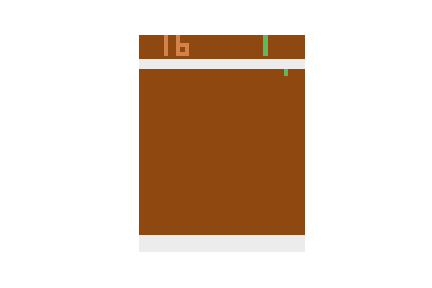
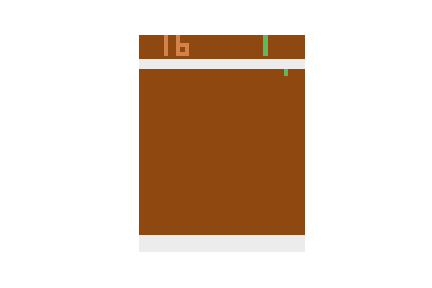
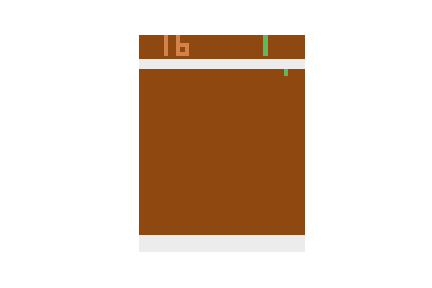
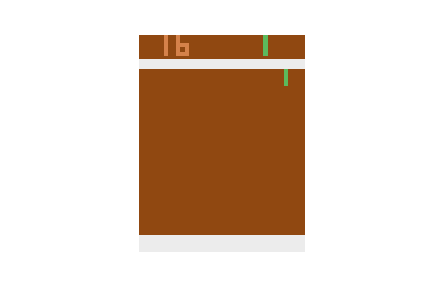
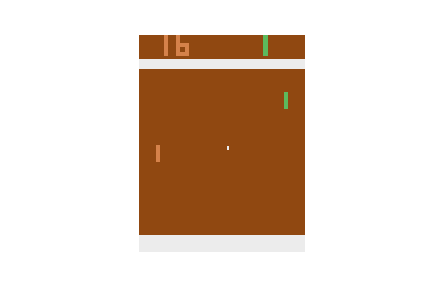
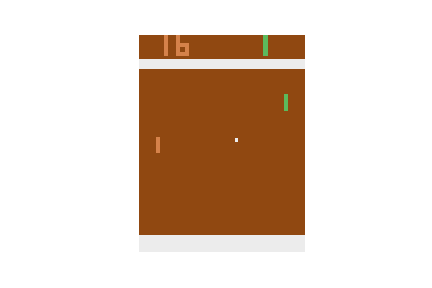
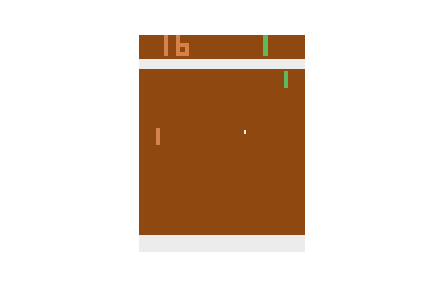
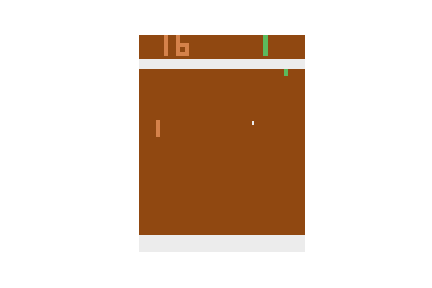
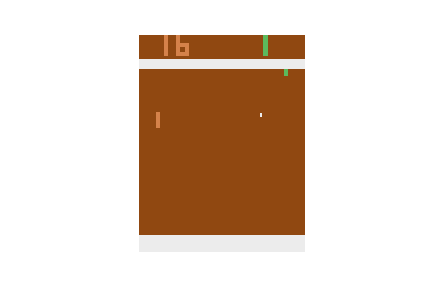
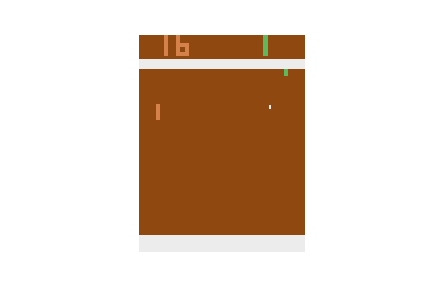
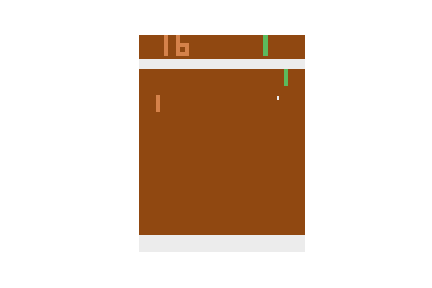
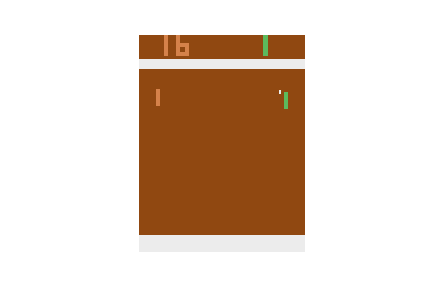
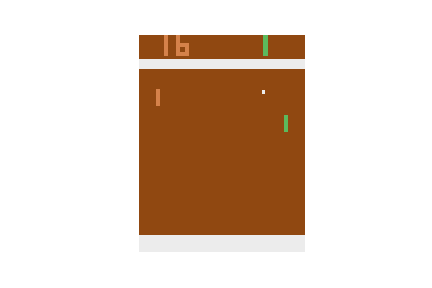
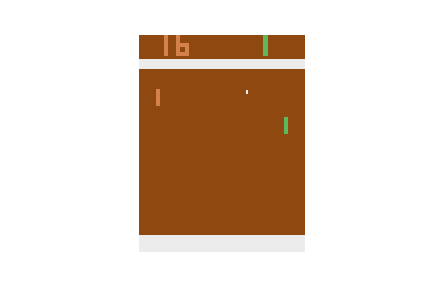
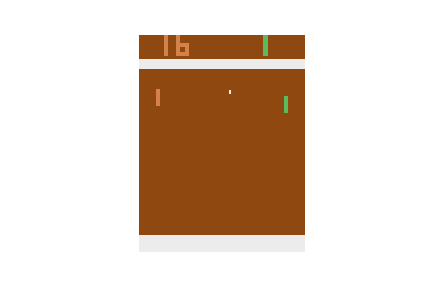
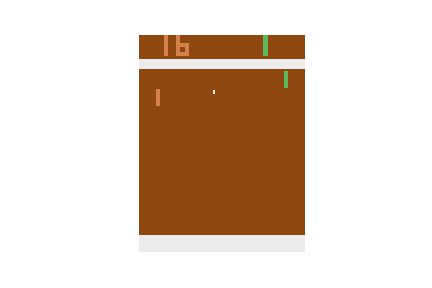
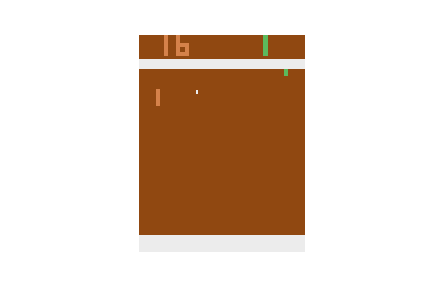
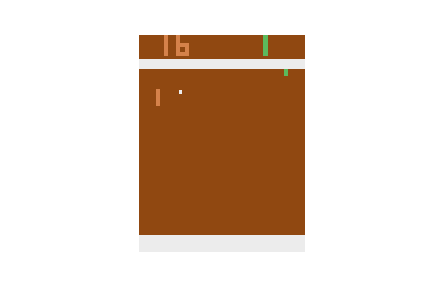
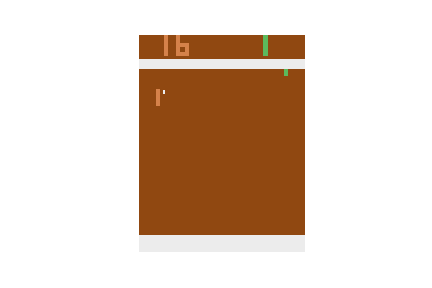
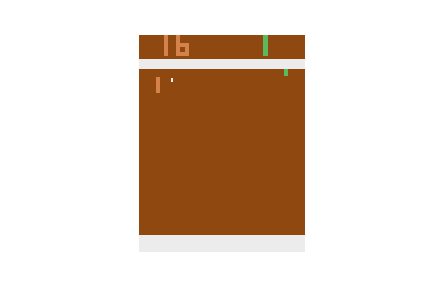
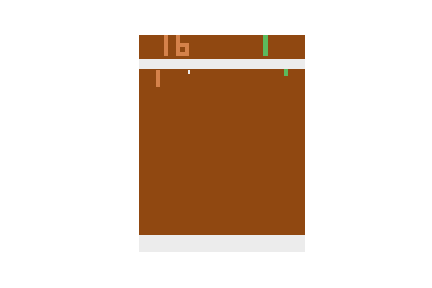
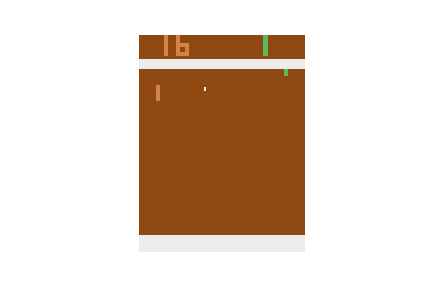
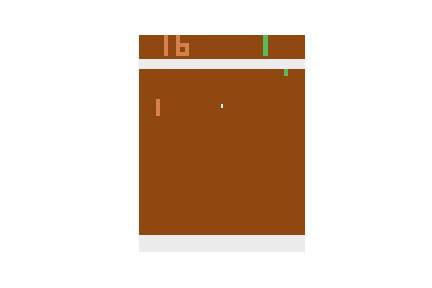
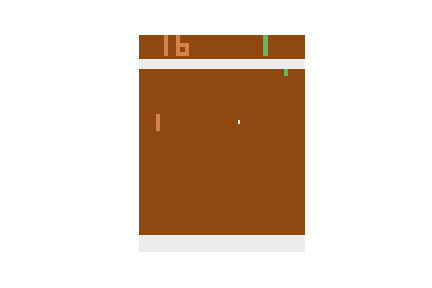
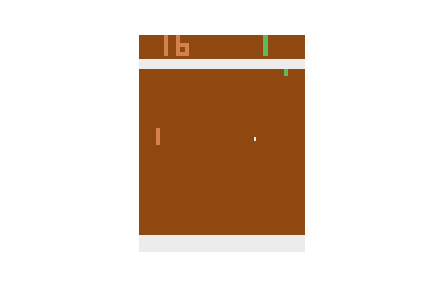
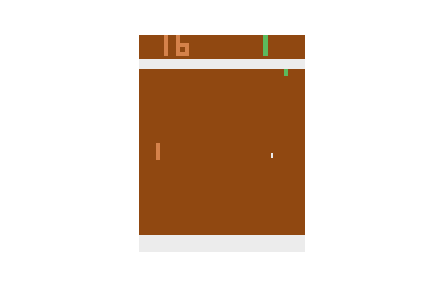
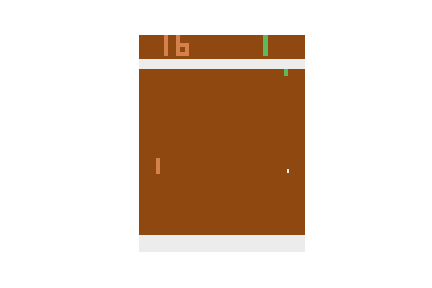
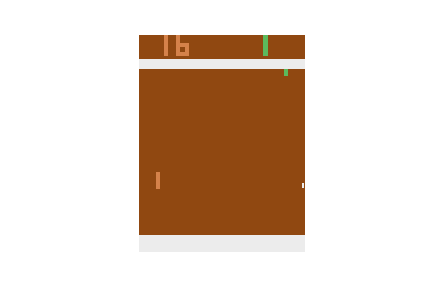
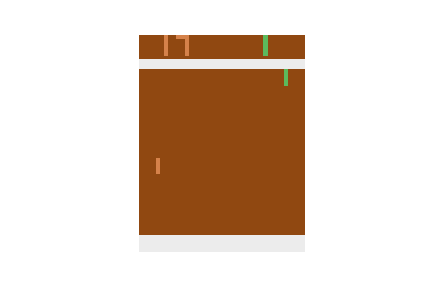
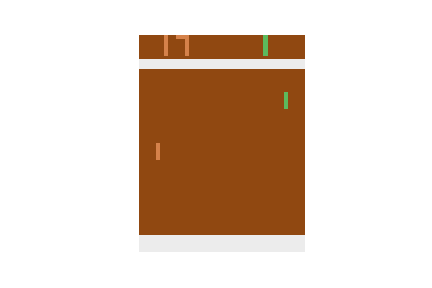
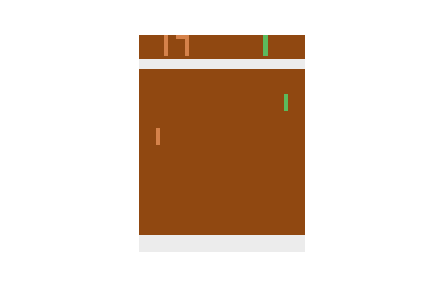
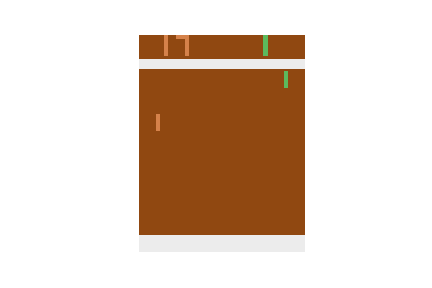
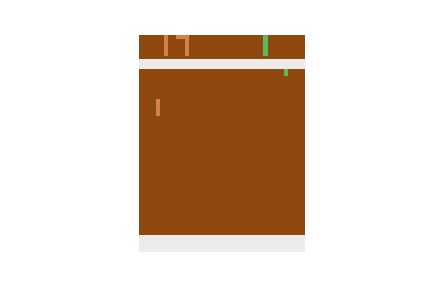
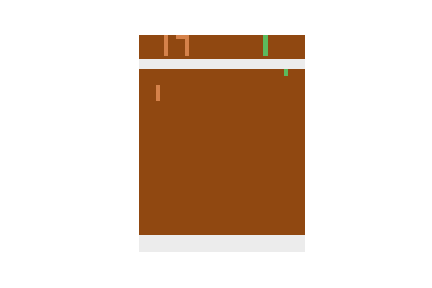
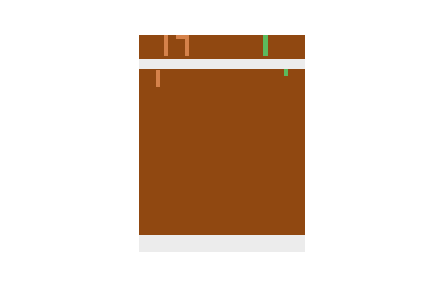
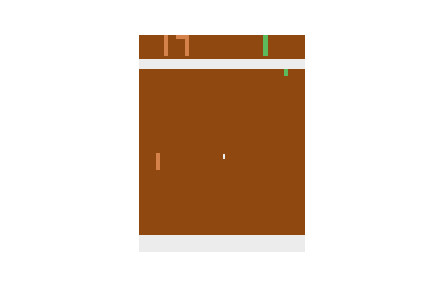
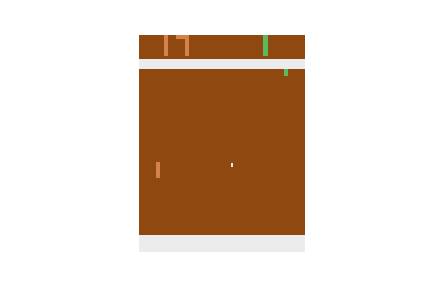
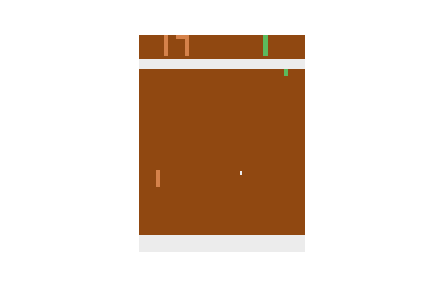
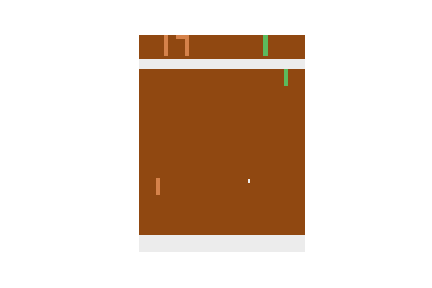
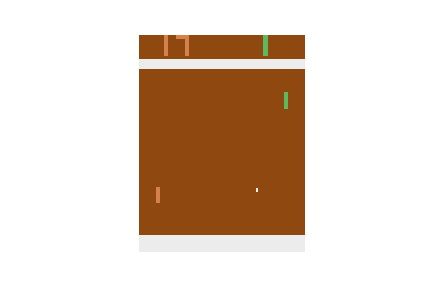
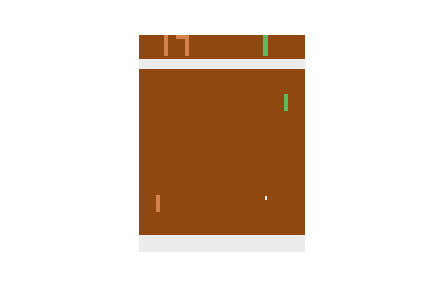
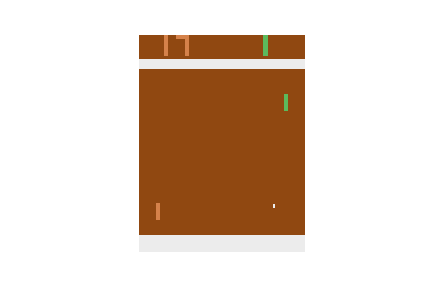
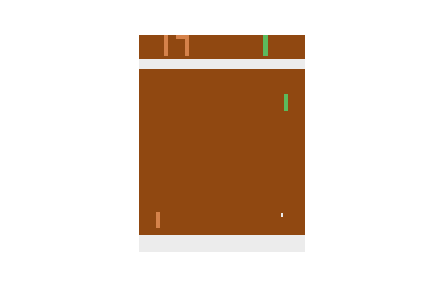
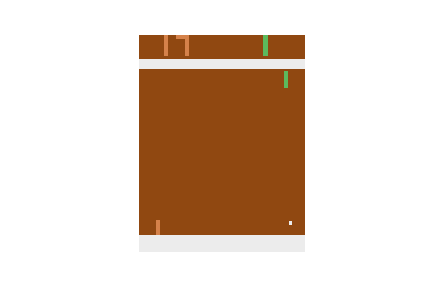
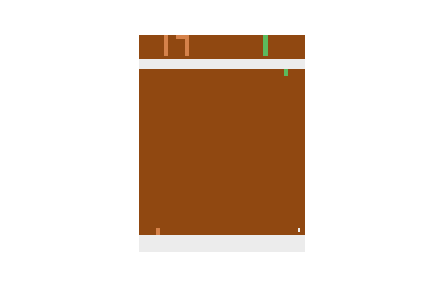
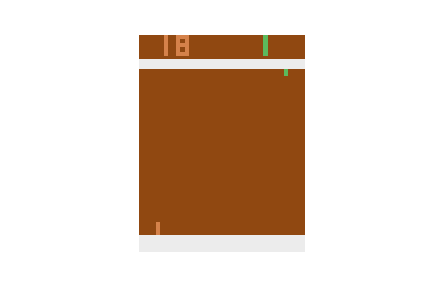
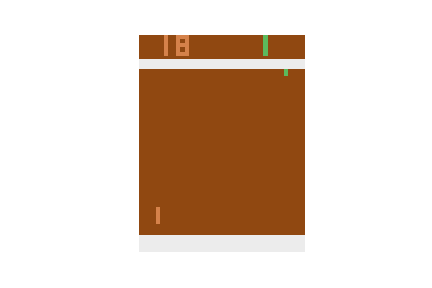
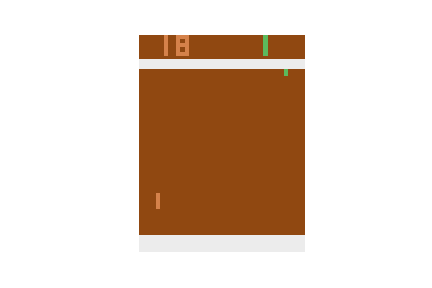
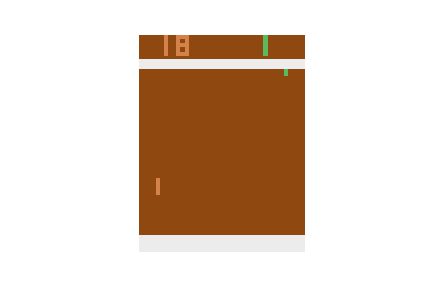
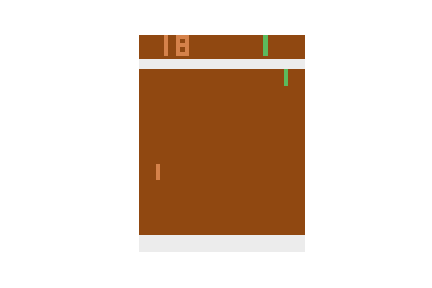
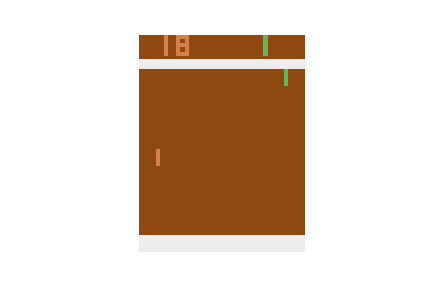
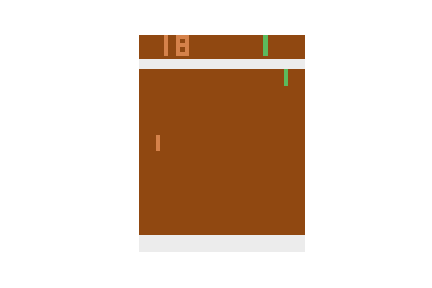
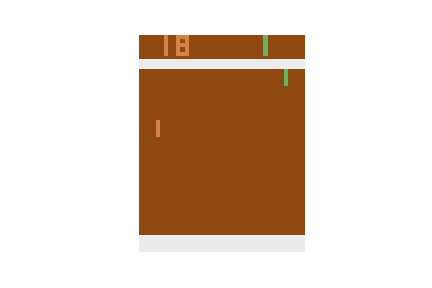
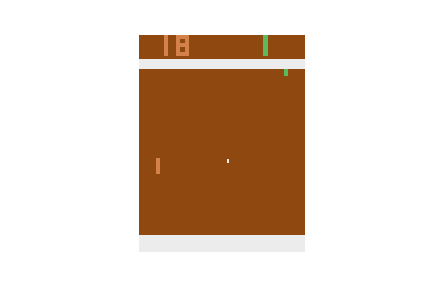
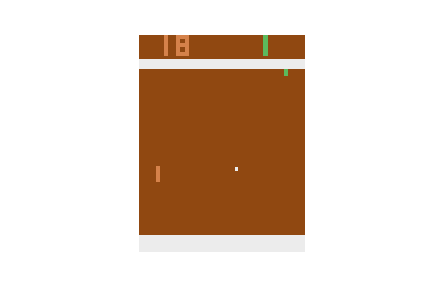
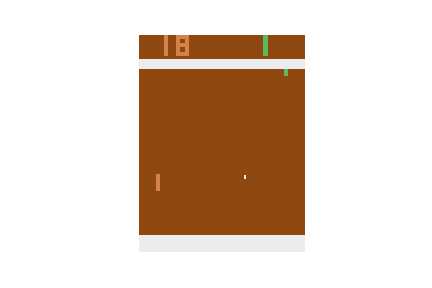
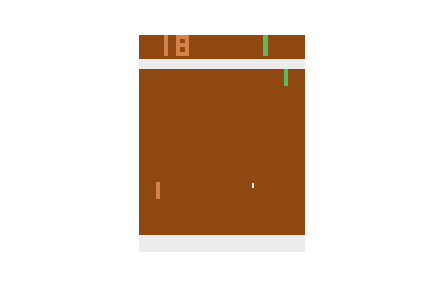
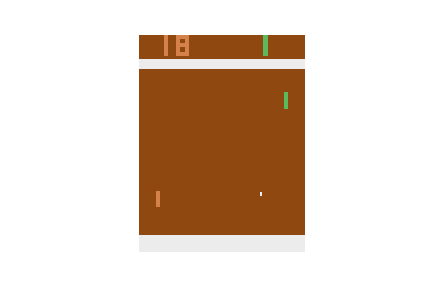
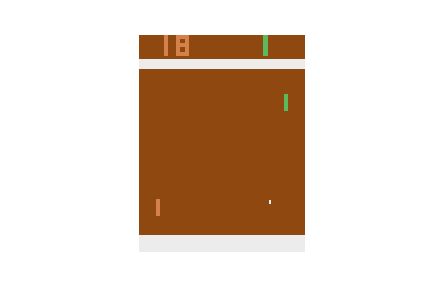
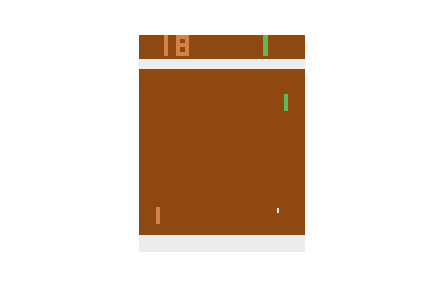
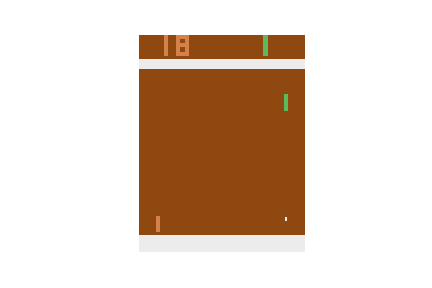
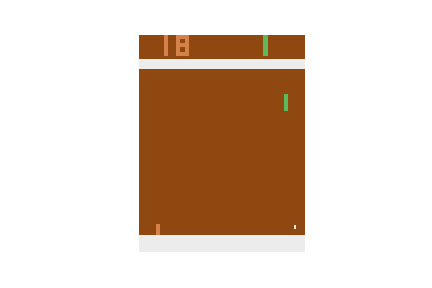
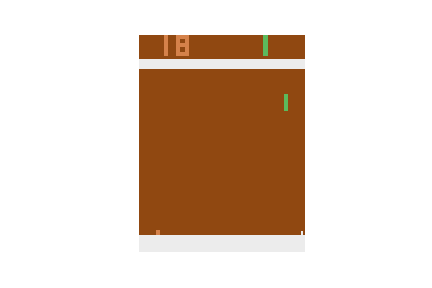
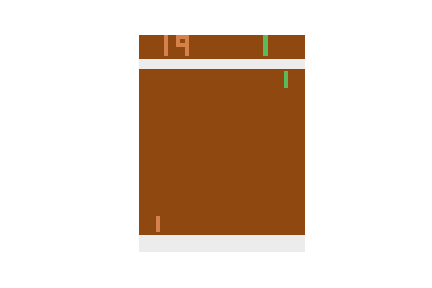
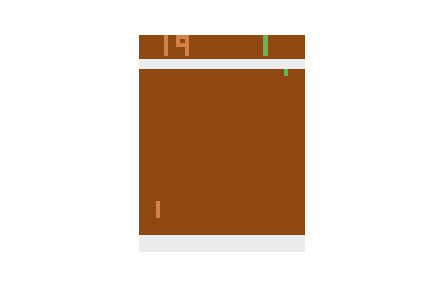
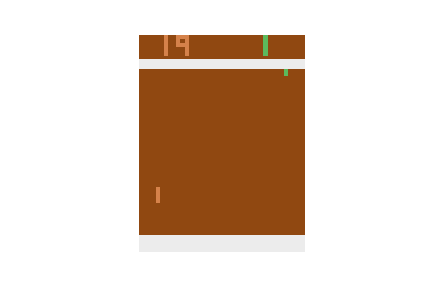
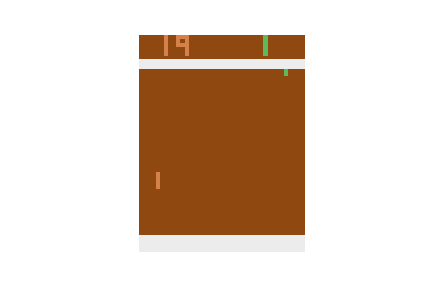
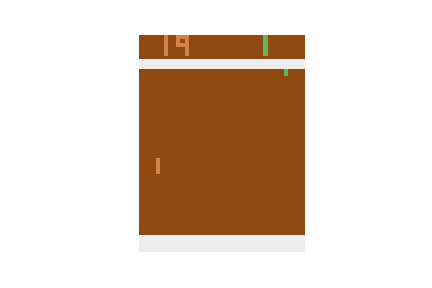
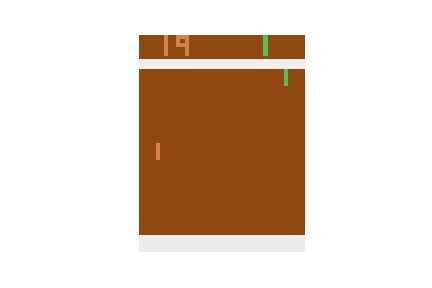
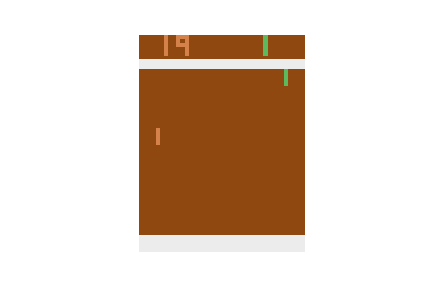
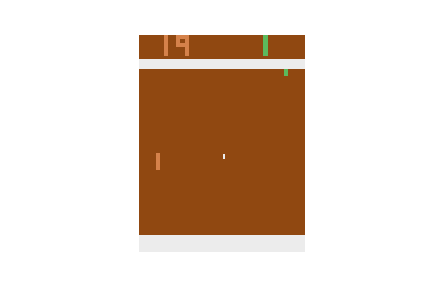
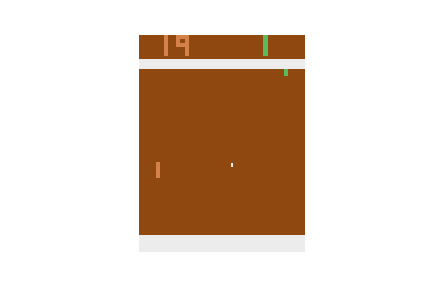
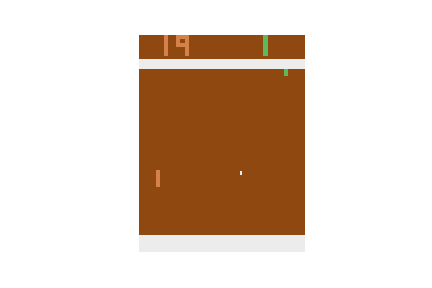
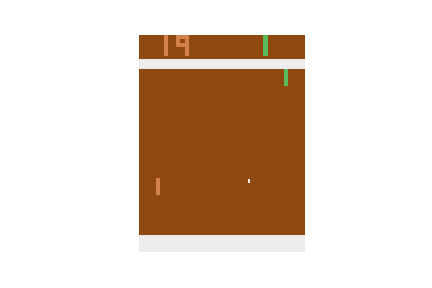
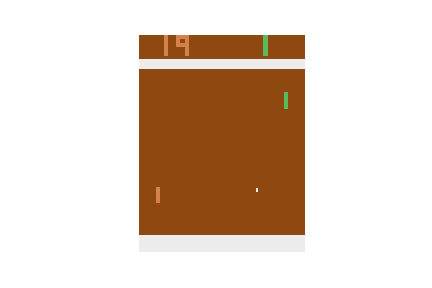
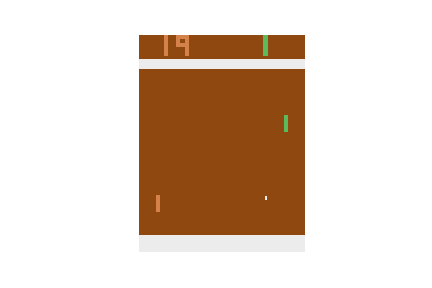
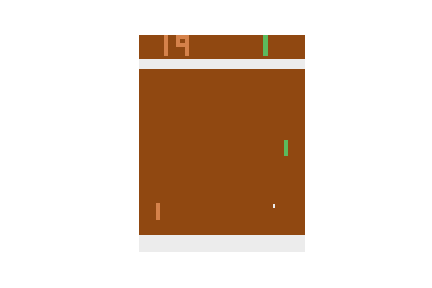
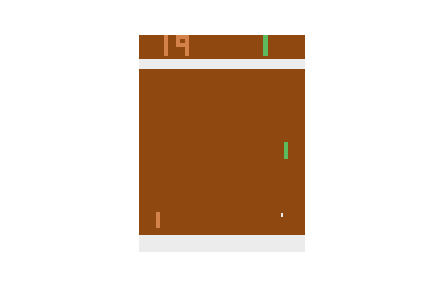
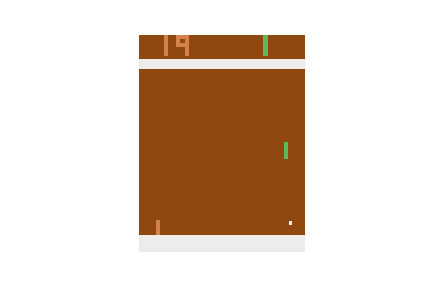
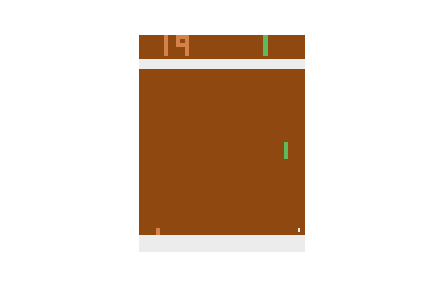
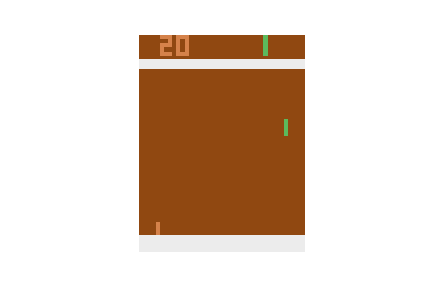
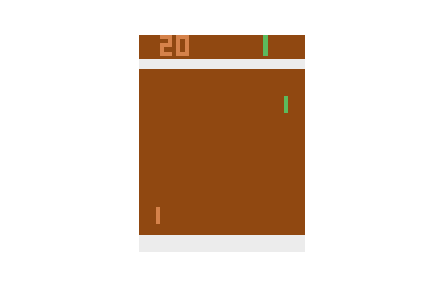
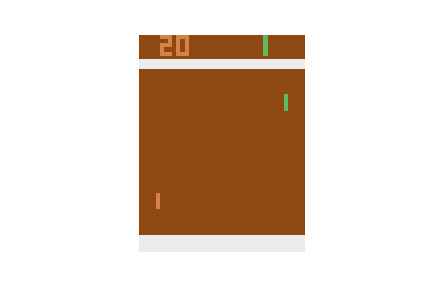
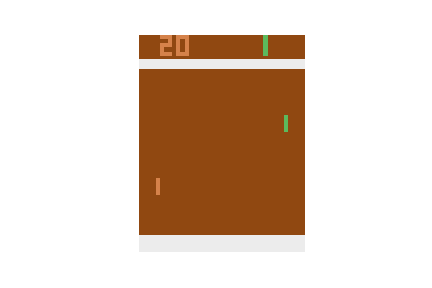
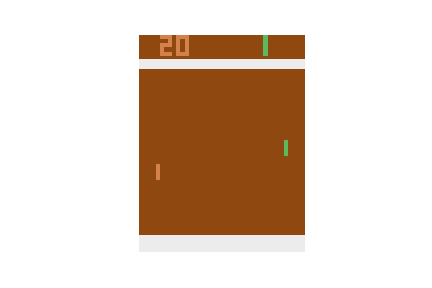
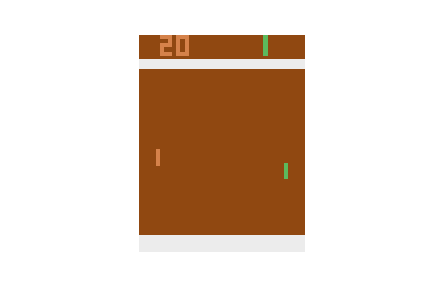
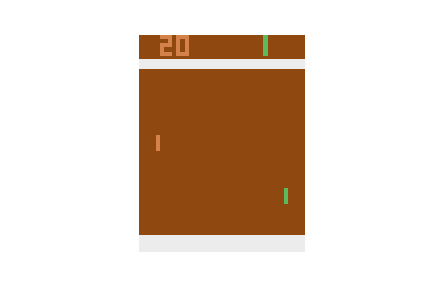
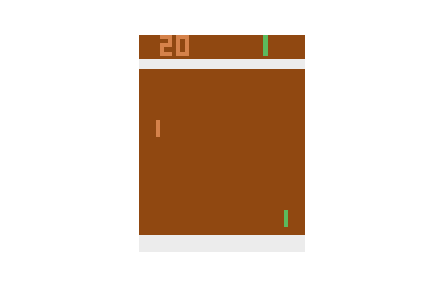
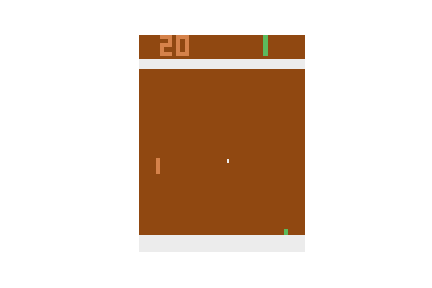
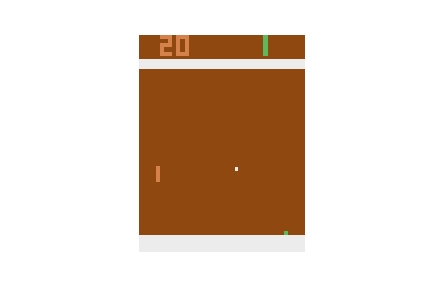
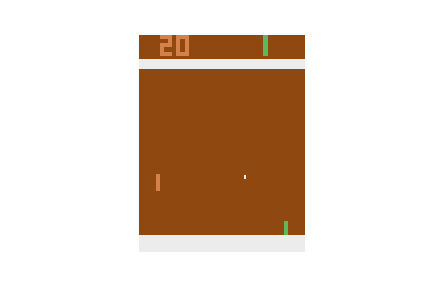
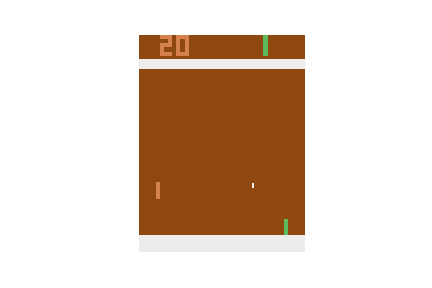
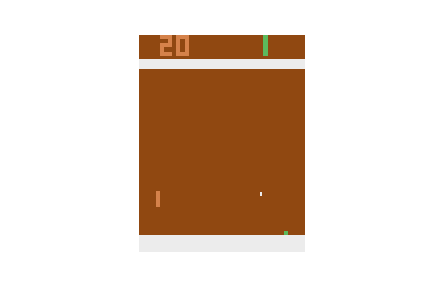
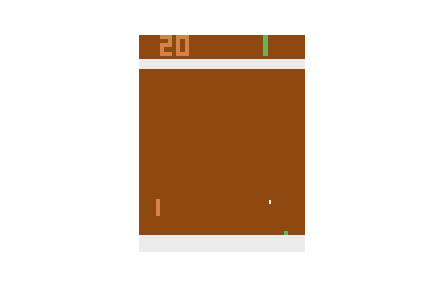
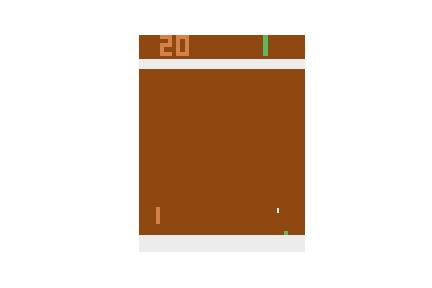
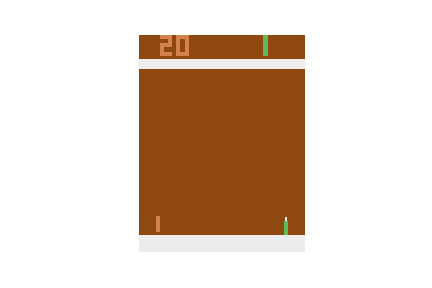
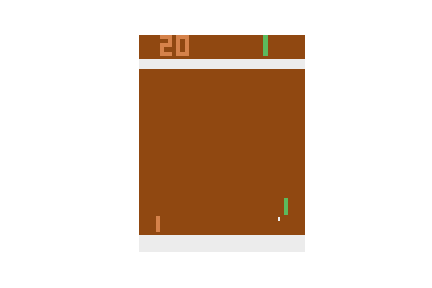
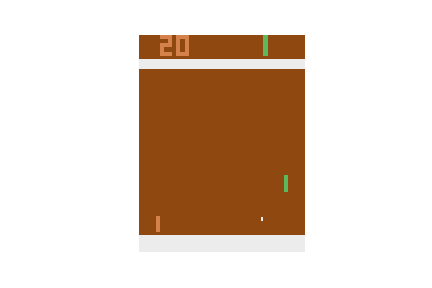
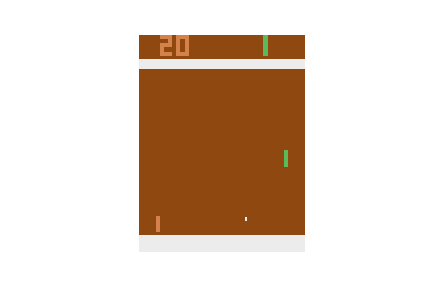
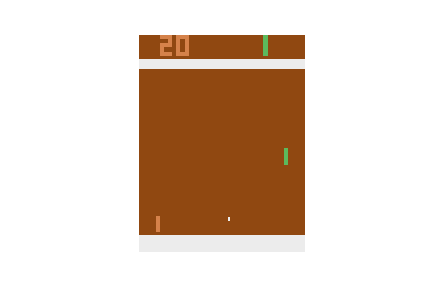
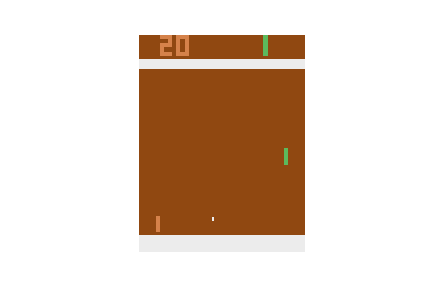
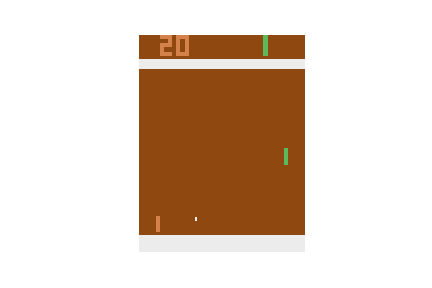
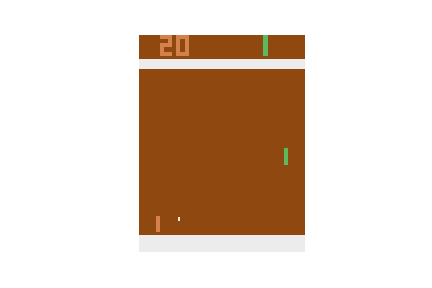
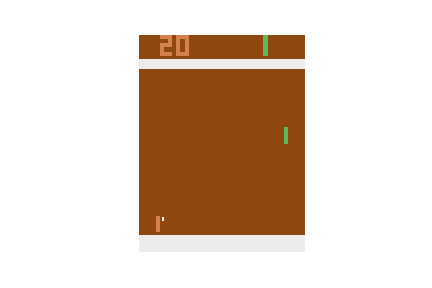
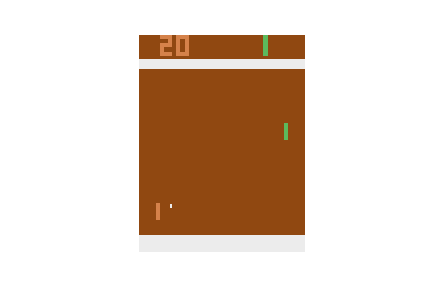
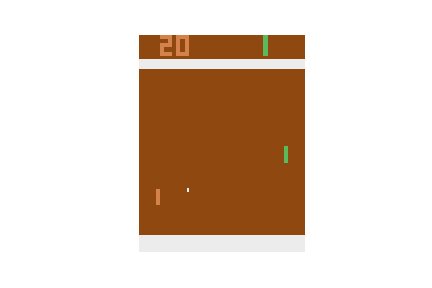
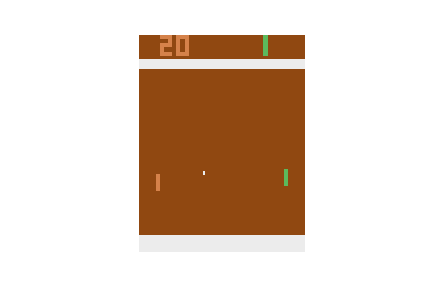
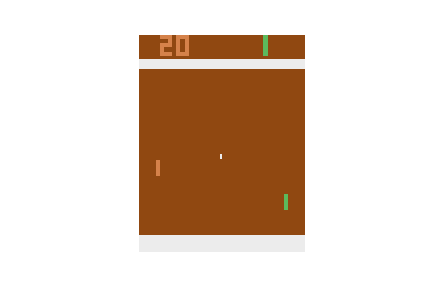
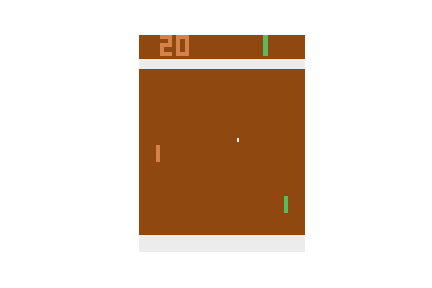
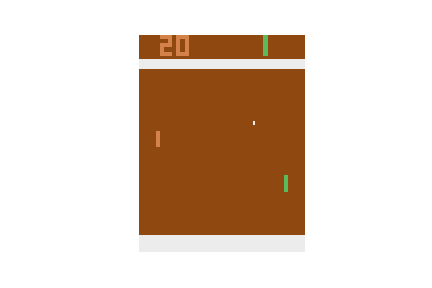
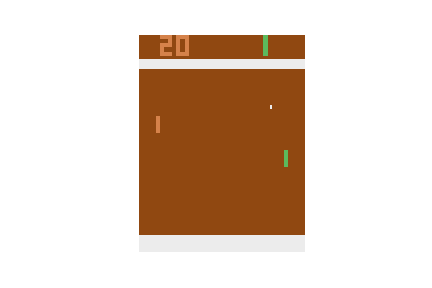
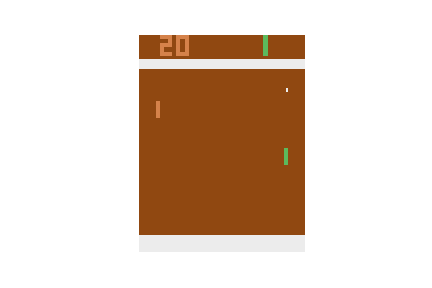
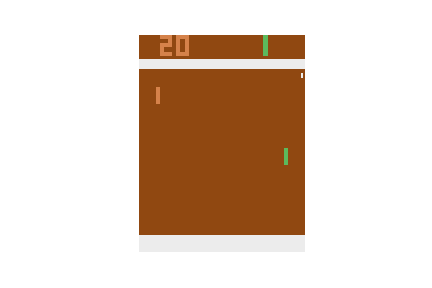

In [7]:
pong_utils.play(env, policy, time=1000) 

In [8]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
